In [1]:
from utils.alloys import vectorization_method_1
from utils.constants import alloy_max_len
from utils.ml import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

2023-10-27 11:39:42.835029: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-27 11:39:43.223916: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-27 11:39:43.905137: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/include:/usr/local/cuda-11.0/lib64:
2023-10-27 11:39:43.905385: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerro

In [2]:
df = pd.read_csv("final_df.csv")
X = []
for alloy in df["bmg_alloy"]:
    X.append(vectorization_method_1(alloy))
y = df["actual_d_max"]

In [3]:
X = np.array(X, dtype=np.int32)
y = np.array(y, dtype=np.int32)

# have a look at if the vectorization was done correctly - everything was as expected
print(df["bmg_alloy"][0])
print(X[0])
print(y[0])

Ti7.0Cu60.0Zr33.0
[22  7 29 60 40 33  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
3


In [4]:
VOCAB_SIZE = np.max(X) + 1
EMBEDDING_DIM = 32
INPUT_LENGTH = alloy_max_len
EPOCHS = 4000

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
def test(model, epochs, layer_name=None, test_all=True):
    tf.random.set_seed(42)
    model.compile(optimizer="adam", loss="mean_squared_error")
    global X_train, X_test, y_train, y_test
    history = model.fit(X_train, y_train, verbose=0, epochs=epochs, batch_size=64, validation_data=(X_test, y_test))
    plt.plot(history.history["loss"])
    plt.plot(history.history['val_loss'])
    y_hat = model.predict(X_test)
    print(f"RNN Score: {r2_score(y_test, y_hat)}")
    plt.figure()
    sns.regplot(x=y_test, y=y_hat)

    if (test_all == True):
        selected_layer = model.get_layer(layer_name)
        model_till_selected_layer = tf.keras.Model(inputs=model.input, outputs=selected_layer.output)
        X_train_2 = model_till_selected_layer.predict(X_train)
        X_test_2 = model_till_selected_layer.predict(X_test)
        X_train_2 = pd.DataFrame(data=X_train_2)
        X_test_2 = pd.DataFrame(data=X_test_2)
        y_train_2 = pd.DataFrame(data=y_train)
        y_test_2 = pd.DataFrame(data=y_test)

        display(X_train_2)
        display(X_test_2)
        
        scores = run_all_regressors_with_transformers(X_train=X_train_2, X_test=X_test_2, y_train=y_train_2, y_test=y_test_2, y_transform=True)
        display(scores[:10])

Now in the below section, I iteratively change the model starting with a simple embedding model (embedding, flatten, dense 128, and dense 1), I add LSTM/LSTMS, bi-directionality and dropout (to handle overfitting) and see the model become better.

In [7]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=INPUT_LENGTH),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1, activation='linear')
])
print(model_1.summary())

2023-10-27 11:40:21.717261: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-10-27 11:40:21.717385: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (laptop): /proc/driver/nvidia/version does not exist
2023-10-27 11:40:21.718529: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 32)            3168      
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense (Dense)               (None, 128)               82048     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 85,345
Trainable params: 85,345
Non-trainable params: 0
_________________________________________________________________
None


10/10 [==============================] - 0s 1ms/step
RNN Score: 0.20200831277061193
10/10 [==============================] - 0s 830us/step


,0,1,2,3,4,5,6,7,8,9,...,630,631,632,633,634,635,636,637,638,639
0,-0.03,0.11,-0.27,-0.01,0.04,-0.06,0.15,0.06,0.06,0.03,...,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00
1,-0.03,0.11,-0.27,-0.01,0.04,-0.06,0.15,0.06,0.06,0.03,...,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00
2,0.09,-0.12,0.46,-0.12,0.03,0.15,-0.32,-0.10,-0.05,0.12,...,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00
3,-0.04,-0.22,0.37,-0.09,-0.07,-0.01,-0.23,0.05,0.04,-0.03,...,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00
4,0.02,0.25,-0.12,0.31,0.22,0.02,0.03,-0.08,-0.15,0.03,...,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,-0.12,-0.08,0.09,-0.17,-1.29,-0.28,-0.16,0.17,0.03,-0.00,...,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00
1265,-0.03,0.11,-0.27,-0.01,0.04,-0.06,0.15,0.06,0.06,0.03,...,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00
1266,-0.04,-0.22,0.37,-0.09,-0.07,-0.01,-0.23,0.05,0.04,-0.03,...,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00
1267,-0.03,0.11,-0.27,-0.01,0.04,-0.06,0.15,0.06,0.06,0.03,...,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00


,0,1,2,3,4,5,6,7,8,9,...,630,631,632,633,634,635,636,637,638,639
0,-0.03,0.11,-0.27,-0.01,0.04,-0.06,0.15,0.06,0.06,0.03,...,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00
1,-0.03,0.11,-0.27,-0.01,0.04,-0.06,0.15,0.06,0.06,0.03,...,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00
2,-0.03,0.11,-0.27,-0.01,0.04,-0.06,0.15,0.06,0.06,0.03,...,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00
3,-0.04,-0.22,0.37,-0.09,-0.07,-0.01,-0.23,0.05,0.04,-0.03,...,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00
4,-0.04,-0.22,0.37,-0.09,-0.07,-0.01,-0.23,0.05,0.04,-0.03,...,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,-0.46,0.14,-0.10,-0.24,0.26,-0.32,-0.01,0.30,0.05,0.32,...,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00
314,-0.03,0.11,-0.27,-0.01,0.04,-0.06,0.15,0.06,0.06,0.03,...,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00
315,-0.03,0.11,-0.27,-0.01,0.04,-0.06,0.15,0.06,0.06,0.03,...,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00
316,0.02,0.25,-0.12,0.31,0.22,0.02,0.03,-0.08,-0.15,0.03,...,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00


  2%|██                                                                                  | 1/42 [00:01<00:49,  1.21s/it]

AdaBoostRegressor (StandardScaler) 0.3921933547949955



  7%|██████                                                                              | 3/42 [00:02<00:21,  1.78it/s]

BaggingRegressor (StandardScaler) 0.7553363196241308
BayesianRidge (StandardScaler) 0.37359414309377825



 10%|████████                                                                            | 4/42 [00:02<00:15,  2.48it/s]

DecisionTreeRegressor (StandardScaler) 0.5936182788969624
DummyRegressor (StandardScaler) -0.00010814299313310904
ElasticNet (StandardScaler) -0.00010814299313310904



 19%|████████████████                                                                    | 8/42 [00:04<00:18,  1.80it/s]

ElasticNetCV (StandardScaler) 0.37125481641884683
ExtraTreeRegressor (StandardScaler) 0.5147215836531869



 21%|██████████████████                                                                  | 9/42 [00:08<00:42,  1.30s/it]

ExtraTreesRegressor (StandardScaler) 0.8591851661316345
GammaRegressor (StandardScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 26%|█████████████████████▋                                                             | 11/42 [00:08<00:26,  1.15it/s]

GaussianProcessRegressor (StandardScaler) 0.008363660252517446



 29%|███████████████████████▋                                                           | 12/42 [00:12<00:41,  1.39s/it]

GradientBoostingRegressor (StandardScaler) 0.739103640925549



 31%|█████████████████████████▋                                                         | 13/42 [00:13<00:37,  1.30s/it]

HistGradientBoostingRegressor (StandardScaler) 0.752885719876677



 38%|███████████████████████████████▌                                                   | 16/42 [00:13<00:16,  1.60it/s]

HuberRegressor (StandardScaler) 0.3453436763332416
KNeighborsRegressor (StandardScaler) 0.7054051224990947
KernelRidge (StandardScaler) 0.1791083341555172



 40%|█████████████████████████████████▌                                                 | 17/42 [00:14<00:15,  1.62it/s]

Lars (StandardScaler) model failed to execute
int too large to convert to float



 43%|███████████████████████████████████▌                                               | 18/42 [00:14<00:14,  1.63it/s]

LarsCV (StandardScaler) model failed to execute
int too large to convert to float
Lasso (StandardScaler) -0.00010814299313310904



 48%|███████████████████████████████████████▌                                           | 20/42 [00:17<00:22,  1.01s/it]

LassoCV (StandardScaler) 0.3639444566739445
LassoLars (StandardScaler) -0.00010814299313310904



 52%|███████████████████████████████████████████▍                                       | 22/42 [00:20<00:20,  1.05s/it]

LassoLarsCV (StandardScaler) 0.36476999189044146



 57%|███████████████████████████████████████████████▍                                   | 24/42 [00:20<00:13,  1.35it/s]

LassoLarsIC (StandardScaler) 0.4567268175864073
LinearRegression (StandardScaler) -216152621.99255666



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:21<00:13,  1.22it/s]

LinearSVR (StandardScaler) 0.34494499671250645



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:22<00:12,  1.28it/s]

MLPRegressor (StandardScaler) 0.4754034934196565



 64%|█████████████████████████████████████████████████████▎                             | 27/42 [00:22<00:09,  1.55it/s]

NuSVR (StandardScaler) 0.6990879872842232
OrthogonalMatchingPursuit (StandardScaler) 0.37962469665009224



 74%|█████████████████████████████████████████████████████████████▎                     | 31/42 [00:23<00:03,  3.50it/s]

OrthogonalMatchingPursuitCV (StandardScaler) 0.37962469665009224
PassiveAggressiveRegressor (StandardScaler) 0.10798268973954273
PoissonRegressor (StandardScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.



 76%|███████████████████████████████████████████████████████████████▏                   | 32/42 [00:29<00:16,  1.69s/it]

RANSACRegressor (StandardScaler) -6676544.884869615



 79%|█████████████████████████████████████████████████████████████████▏                 | 33/42 [00:37<00:26,  2.97s/it]

RandomForestRegressor (StandardScaler) 0.769164591019708
Ridge (StandardScaler) 0.1790138945068086



 83%|█████████████████████████████████████████████████████████████████████▏             | 35/42 [00:37<00:12,  1.83s/it]

RidgeCV (StandardScaler) 0.2106448702762289
SGDRegressor (StandardScaler) -2.805743822646229e+25



 88%|█████████████████████████████████████████████████████████████████████████          | 37/42 [00:37<00:06,  1.21s/it]

SVR (StandardScaler) 0.6961367937587097
TransformedTargetRegressor (StandardScaler) -216152621.99255666



 93%|█████████████████████████████████████████████████████████████████████████████      | 39/42 [00:38<00:03,  1.02s/it]

TweedieRegressor (StandardScaler) 0.5844038262666844



 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [00:39<00:02,  1.01s/it]

XGBRegressor (StandardScaler) 0.7203401803648259



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:40<00:00,  1.19it/s]

LGBMRegressor (StandardScaler) 0.7508633437114292
Learning rate set to 0.042513
0:	learn: 0.9807725	total: 83.4ms	remaining: 1m 23s
1:	learn: 0.9638527	total: 88.3ms	remaining: 44.1s
2:	learn: 0.9456349	total: 92.9ms	remaining: 30.9s
3:	learn: 0.9291149	total: 97.9ms	remaining: 24.4s
4:	learn: 0.9117433	total: 103ms	remaining: 20.5s
5:	learn: 0.8960342	total: 108ms	remaining: 17.8s
6:	learn: 0.8807421	total: 113ms	remaining: 16s
7:	learn: 0.8662932	total: 117ms	remaining: 14.6s
8:	learn: 0.8535520	total: 123ms	remaining: 13.5s
9:	learn: 0.8409379	total: 128ms	remaining: 12.7s
10:	learn: 0.8281895	total: 133ms	remaining: 11.9s
11:	learn: 0.8170778	total: 138ms	remaining: 11.4s
12:	learn: 0.8053414	total: 145ms	remaining: 11s
13:	learn: 0.7957307	total: 151ms	remaining: 10.6s
14:	learn: 0.7841748	total: 156ms	remaining: 10.2s
15:	learn: 0.7755390	total: 161ms	remaining: 9.9s
16:	learn: 0.7661455	total: 166ms	remaining: 9.61s
17:	learn: 0.7563487	total: 171ms	remaining: 9.32s
18:	learn: 0

164:	learn: 0.3789622	total: 936ms	remaining: 4.74s
165:	learn: 0.3780441	total: 941ms	remaining: 4.73s
166:	learn: 0.3766778	total: 947ms	remaining: 4.72s
167:	learn: 0.3759371	total: 953ms	remaining: 4.72s
168:	learn: 0.3745614	total: 959ms	remaining: 4.72s
169:	learn: 0.3731224	total: 966ms	remaining: 4.71s
170:	learn: 0.3722652	total: 971ms	remaining: 4.71s
171:	learn: 0.3711839	total: 977ms	remaining: 4.7s
172:	learn: 0.3699457	total: 981ms	remaining: 4.69s
173:	learn: 0.3688439	total: 986ms	remaining: 4.68s
174:	learn: 0.3674669	total: 991ms	remaining: 4.67s
175:	learn: 0.3666405	total: 996ms	remaining: 4.66s
176:	learn: 0.3659421	total: 1s	remaining: 4.66s
177:	learn: 0.3646027	total: 1s	remaining: 4.64s
178:	learn: 0.3636153	total: 1.01s	remaining: 4.64s
179:	learn: 0.3621198	total: 1.02s	remaining: 4.63s
180:	learn: 0.3612003	total: 1.02s	remaining: 4.62s
181:	learn: 0.3602366	total: 1.03s	remaining: 4.61s
182:	learn: 0.3598767	total: 1.03s	remaining: 4.61s
183:	learn: 0.35873

353:	learn: 0.2401835	total: 1.93s	remaining: 3.52s
354:	learn: 0.2399179	total: 1.93s	remaining: 3.51s
355:	learn: 0.2398055	total: 1.94s	remaining: 3.51s
356:	learn: 0.2392407	total: 1.95s	remaining: 3.51s
357:	learn: 0.2387564	total: 1.95s	remaining: 3.5s
358:	learn: 0.2382492	total: 1.96s	remaining: 3.5s
359:	learn: 0.2379354	total: 1.96s	remaining: 3.49s
360:	learn: 0.2375882	total: 1.97s	remaining: 3.48s
361:	learn: 0.2374937	total: 1.97s	remaining: 3.48s
362:	learn: 0.2371392	total: 1.98s	remaining: 3.47s
363:	learn: 0.2363232	total: 1.98s	remaining: 3.46s
364:	learn: 0.2360177	total: 1.99s	remaining: 3.46s
365:	learn: 0.2355484	total: 1.99s	remaining: 3.45s
366:	learn: 0.2349931	total: 2s	remaining: 3.45s
367:	learn: 0.2345046	total: 2s	remaining: 3.44s
368:	learn: 0.2340224	total: 2.01s	remaining: 3.43s
369:	learn: 0.2338061	total: 2.01s	remaining: 3.43s
370:	learn: 0.2333603	total: 2.02s	remaining: 3.42s
371:	learn: 0.2331037	total: 2.02s	remaining: 3.42s
372:	learn: 0.232402

547:	learn: 0.1762211	total: 2.93s	remaining: 2.41s
548:	learn: 0.1761922	total: 2.93s	remaining: 2.41s
549:	learn: 0.1759165	total: 2.94s	remaining: 2.4s
550:	learn: 0.1756382	total: 2.94s	remaining: 2.4s
551:	learn: 0.1752107	total: 2.95s	remaining: 2.39s
552:	learn: 0.1747883	total: 2.96s	remaining: 2.39s
553:	learn: 0.1746051	total: 2.96s	remaining: 2.38s
554:	learn: 0.1743742	total: 2.97s	remaining: 2.38s
555:	learn: 0.1742272	total: 2.97s	remaining: 2.37s
556:	learn: 0.1738832	total: 2.98s	remaining: 2.37s
557:	learn: 0.1735112	total: 2.98s	remaining: 2.36s
558:	learn: 0.1733289	total: 2.99s	remaining: 2.36s
559:	learn: 0.1731976	total: 2.99s	remaining: 2.35s
560:	learn: 0.1728645	total: 3s	remaining: 2.35s
561:	learn: 0.1726037	total: 3s	remaining: 2.34s
562:	learn: 0.1721653	total: 3.01s	remaining: 2.33s
563:	learn: 0.1719364	total: 3.01s	remaining: 2.33s
564:	learn: 0.1717615	total: 3.02s	remaining: 2.32s
565:	learn: 0.1715335	total: 3.02s	remaining: 2.32s
566:	learn: 0.171241

735:	learn: 0.1397358	total: 3.91s	remaining: 1.4s
736:	learn: 0.1395069	total: 3.92s	remaining: 1.4s
737:	learn: 0.1394886	total: 3.92s	remaining: 1.39s
738:	learn: 0.1394743	total: 3.93s	remaining: 1.39s
739:	learn: 0.1393751	total: 3.93s	remaining: 1.38s
740:	learn: 0.1392936	total: 3.94s	remaining: 1.38s
741:	learn: 0.1391553	total: 3.95s	remaining: 1.37s
742:	learn: 0.1388176	total: 3.95s	remaining: 1.37s
743:	learn: 0.1388015	total: 3.96s	remaining: 1.36s
744:	learn: 0.1386210	total: 3.96s	remaining: 1.35s
745:	learn: 0.1383606	total: 3.97s	remaining: 1.35s
746:	learn: 0.1381682	total: 3.97s	remaining: 1.34s
747:	learn: 0.1381552	total: 3.98s	remaining: 1.34s
748:	learn: 0.1380938	total: 3.98s	remaining: 1.33s
749:	learn: 0.1380198	total: 3.99s	remaining: 1.33s
750:	learn: 0.1378995	total: 3.99s	remaining: 1.32s
751:	learn: 0.1377623	total: 4s	remaining: 1.32s
752:	learn: 0.1376418	total: 4s	remaining: 1.31s
753:	learn: 0.1373125	total: 4.01s	remaining: 1.31s
754:	learn: 0.136979

923:	learn: 0.1151705	total: 4.91s	remaining: 404ms
924:	learn: 0.1151589	total: 4.91s	remaining: 398ms
925:	learn: 0.1149267	total: 4.92s	remaining: 393ms
926:	learn: 0.1147217	total: 4.92s	remaining: 388ms
927:	learn: 0.1146811	total: 4.93s	remaining: 383ms
928:	learn: 0.1146705	total: 4.94s	remaining: 377ms
929:	learn: 0.1146604	total: 4.94s	remaining: 372ms
930:	learn: 0.1144733	total: 4.95s	remaining: 367ms
931:	learn: 0.1143683	total: 4.95s	remaining: 361ms
932:	learn: 0.1143559	total: 4.96s	remaining: 356ms
933:	learn: 0.1143372	total: 4.96s	remaining: 351ms
934:	learn: 0.1142870	total: 4.97s	remaining: 345ms
935:	learn: 0.1142708	total: 4.97s	remaining: 340ms
936:	learn: 0.1142499	total: 4.98s	remaining: 335ms
937:	learn: 0.1142363	total: 4.98s	remaining: 329ms
938:	learn: 0.1142280	total: 4.99s	remaining: 324ms
939:	learn: 0.1140609	total: 4.99s	remaining: 319ms
940:	learn: 0.1140524	total: 5s	remaining: 313ms
941:	learn: 0.1139985	total: 5s	remaining: 308ms
942:	learn: 0.1138


 17%|██████████████▏                                                                      | 1/6 [00:45<03:48, 45.68s/it]

999:	learn: 0.1081026	total: 5.31s	remaining: 0us
CatBoostRegressor (StandardScaler) 0.8027314821548077



  2%|██                                                                                  | 1/42 [00:01<00:50,  1.22s/it]

AdaBoostRegressor (MinMaxScaler) 0.3952600119905223



  7%|██████                                                                              | 3/42 [00:02<00:21,  1.78it/s]

BaggingRegressor (MinMaxScaler) 0.7303251780111717
BayesianRidge (MinMaxScaler) 0.4492458737988011



 10%|████████                                                                            | 4/42 [00:02<00:15,  2.47it/s]

DecisionTreeRegressor (MinMaxScaler) 0.6052332322362617
DummyRegressor (MinMaxScaler) -0.000108142993132887
ElasticNet (MinMaxScaler) -0.00010814289571348112



 17%|██████████████                                                                      | 7/42 [00:04<00:22,  1.58it/s]

ElasticNetCV (MinMaxScaler) 0.4195901366606237
ExtraTreeRegressor (MinMaxScaler) 0.6254885776938198



 21%|██████████████████                                                                  | 9/42 [00:08<00:35,  1.07s/it]

ExtraTreesRegressor (MinMaxScaler) 0.8556426179538839
GammaRegressor (MinMaxScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 26%|█████████████████████▋                                                             | 11/42 [00:08<00:24,  1.27it/s]

GaussianProcessRegressor (MinMaxScaler) 0.5692303832397518



 29%|███████████████████████▋                                                           | 12/42 [00:11<00:37,  1.26s/it]

GradientBoostingRegressor (MinMaxScaler) 0.7382712197285983



 31%|█████████████████████████▋                                                         | 13/42 [00:12<00:34,  1.20s/it]

HistGradientBoostingRegressor (MinMaxScaler) 0.7596646120255821



 38%|███████████████████████████████▌                                                   | 16/42 [00:13<00:15,  1.63it/s]

HuberRegressor (MinMaxScaler) 0.511660347303227
KNeighborsRegressor (MinMaxScaler) 0.7562729522943274
KernelRidge (MinMaxScaler) 0.42100197288087093



 40%|█████████████████████████████████▌                                                 | 17/42 [00:13<00:14,  1.73it/s]

Lars (MinMaxScaler) model failed to execute
int too large to convert to float



 43%|███████████████████████████████████▌                                               | 18/42 [00:14<00:13,  1.83it/s]

LarsCV (MinMaxScaler) model failed to execute
int too large to convert to float
Lasso (MinMaxScaler) -0.00010814289571348112



 48%|███████████████████████████████████████▌                                           | 20/42 [00:16<00:18,  1.17it/s]

LassoCV (MinMaxScaler) 0.4099642546985165
LassoLars (MinMaxScaler) -0.00010814289571348112



 52%|███████████████████████████████████████████▍                                       | 22/42 [00:18<00:18,  1.07it/s]

LassoLarsCV (MinMaxScaler) 0.40978538846772594



 57%|███████████████████████████████████████████████▍                                   | 24/42 [00:19<00:11,  1.52it/s]

LassoLarsIC (MinMaxScaler) 0.47401207625976394
LinearRegression (MinMaxScaler) -2410116.6726948023



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:20<00:12,  1.32it/s]

LinearSVR (MinMaxScaler) 0.30514401772663935



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:21<00:13,  1.15it/s]

MLPRegressor (MinMaxScaler) 0.5319279564058951



 64%|█████████████████████████████████████████████████████▎                             | 27/42 [00:21<00:10,  1.40it/s]

NuSVR (MinMaxScaler) 0.6708466039071742
OrthogonalMatchingPursuit (MinMaxScaler) 0.44582306046261955



 69%|█████████████████████████████████████████████████████████▎                         | 29/42 [00:22<00:06,  2.15it/s]

OrthogonalMatchingPursuitCV (MinMaxScaler) 0.44582306046261955
PassiveAggressiveRegressor (MinMaxScaler) 0.5397793048247364



 74%|█████████████████████████████████████████████████████████████▎                     | 31/42 [00:23<00:05,  1.91it/s]

PoissonRegressor (MinMaxScaler) 0.02335466490064031



 76%|███████████████████████████████████████████████████████████████▏                   | 32/42 [00:30<00:18,  1.89s/it]

RANSACRegressor (MinMaxScaler) -124922.44497658187



 79%|█████████████████████████████████████████████████████████████████▏                 | 33/42 [00:37<00:27,  3.06s/it]

RandomForestRegressor (MinMaxScaler) 0.7711387359470909
Ridge (MinMaxScaler) 0.42087745178026903



 88%|█████████████████████████████████████████████████████████████████████████          | 37/42 [00:37<00:06,  1.23s/it]

RidgeCV (MinMaxScaler) 0.42088010592524294
SGDRegressor (MinMaxScaler) 0.46520040997371725
SVR (MinMaxScaler) 0.580571193332054
TransformedTargetRegressor (MinMaxScaler) -2410116.6726948023



 93%|█████████████████████████████████████████████████████████████████████████████      | 39/42 [00:38<00:02,  1.04it/s]

TweedieRegressor (MinMaxScaler) 0.17634416787311225



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:39<00:00,  1.31it/s]

XGBRegressor (MinMaxScaler) 0.7463232789238361
LGBMRegressor (MinMaxScaler) 0.7559100636626471
Learning rate set to 0.042513
0:	learn: 0.1428699	total: 64.5ms	remaining: 1m 4s
1:	learn: 0.1404052	total: 69ms	remaining: 34.4s
2:	learn: 0.1377514	total: 73.9ms	remaining: 24.6s
3:	learn: 0.1353449	total: 78.8ms	remaining: 19.6s
4:	learn: 0.1328144	total: 83.6ms	remaining: 16.6s
5:	learn: 0.1305260	total: 88.3ms	remaining: 14.6s
6:	learn: 0.1282984	total: 93ms	remaining: 13.2s
7:	learn: 0.1261936	total: 98.4ms	remaining: 12.2s
8:	learn: 0.1243376	total: 103ms	remaining: 11.4s
9:	learn: 0.1225001	total: 108ms	remaining: 10.7s
10:	learn: 0.1206430	total: 113ms	remaining: 10.2s
11:	learn: 0.1190244	total: 117ms	remaining: 9.67s
12:	learn: 0.1173147	total: 123ms	remaining: 9.31s
13:	learn: 0.1159147	total: 128ms	remaining: 8.98s
14:	learn: 0.1142314	total: 132ms	remaining: 8.67s
15:	learn: 0.1129734	total: 137ms	remaining: 8.42s
16:	learn: 0.1116050	total: 141ms	remaining: 8.18s
17:	learn: 0.1

179:	learn: 0.0527503	total: 987ms	remaining: 4.5s
180:	learn: 0.0526163	total: 993ms	remaining: 4.49s
181:	learn: 0.0524759	total: 998ms	remaining: 4.49s
182:	learn: 0.0524235	total: 1s	remaining: 4.48s
183:	learn: 0.0522572	total: 1.01s	remaining: 4.48s
184:	learn: 0.0521759	total: 1.01s	remaining: 4.47s
185:	learn: 0.0520094	total: 1.02s	remaining: 4.47s
186:	learn: 0.0519011	total: 1.03s	remaining: 4.46s
187:	learn: 0.0516746	total: 1.03s	remaining: 4.46s
188:	learn: 0.0515073	total: 1.04s	remaining: 4.45s
189:	learn: 0.0514310	total: 1.04s	remaining: 4.44s
190:	learn: 0.0513055	total: 1.05s	remaining: 4.43s
191:	learn: 0.0511898	total: 1.05s	remaining: 4.43s
192:	learn: 0.0511000	total: 1.06s	remaining: 4.42s
193:	learn: 0.0509560	total: 1.06s	remaining: 4.41s
194:	learn: 0.0507570	total: 1.07s	remaining: 4.4s
195:	learn: 0.0506095	total: 1.07s	remaining: 4.4s
196:	learn: 0.0505459	total: 1.08s	remaining: 4.39s
197:	learn: 0.0504531	total: 1.08s	remaining: 4.38s
198:	learn: 0.0502

370:	learn: 0.0339938	total: 1.98s	remaining: 3.35s
371:	learn: 0.0339564	total: 1.99s	remaining: 3.35s
372:	learn: 0.0338542	total: 1.99s	remaining: 3.35s
373:	learn: 0.0338339	total: 2s	remaining: 3.34s
374:	learn: 0.0337907	total: 2s	remaining: 3.34s
375:	learn: 0.0336826	total: 2.01s	remaining: 3.33s
376:	learn: 0.0335892	total: 2.01s	remaining: 3.33s
377:	learn: 0.0334640	total: 2.02s	remaining: 3.32s
378:	learn: 0.0334328	total: 2.02s	remaining: 3.31s
379:	learn: 0.0333568	total: 2.03s	remaining: 3.31s
380:	learn: 0.0332760	total: 2.03s	remaining: 3.3s
381:	learn: 0.0332595	total: 2.04s	remaining: 3.3s
382:	learn: 0.0331862	total: 2.04s	remaining: 3.29s
383:	learn: 0.0331332	total: 2.05s	remaining: 3.29s
384:	learn: 0.0330691	total: 2.05s	remaining: 3.28s
385:	learn: 0.0329755	total: 2.06s	remaining: 3.28s
386:	learn: 0.0329157	total: 2.06s	remaining: 3.27s
387:	learn: 0.0328846	total: 2.07s	remaining: 3.26s
388:	learn: 0.0327813	total: 2.07s	remaining: 3.26s
389:	learn: 0.032744

559:	learn: 0.0252298	total: 2.97s	remaining: 2.33s
560:	learn: 0.0251813	total: 2.98s	remaining: 2.33s
561:	learn: 0.0251433	total: 2.98s	remaining: 2.33s
562:	learn: 0.0250795	total: 2.99s	remaining: 2.32s
563:	learn: 0.0250461	total: 3s	remaining: 2.31s
564:	learn: 0.0250206	total: 3s	remaining: 2.31s
565:	learn: 0.0249874	total: 3s	remaining: 2.3s
566:	learn: 0.0249449	total: 3.01s	remaining: 2.3s
567:	learn: 0.0249151	total: 3.02s	remaining: 2.29s
568:	learn: 0.0249049	total: 3.02s	remaining: 2.29s
569:	learn: 0.0248624	total: 3.03s	remaining: 2.28s
570:	learn: 0.0248253	total: 3.03s	remaining: 2.28s
571:	learn: 0.0248183	total: 3.04s	remaining: 2.27s
572:	learn: 0.0247861	total: 3.04s	remaining: 2.27s
573:	learn: 0.0247472	total: 3.05s	remaining: 2.26s
574:	learn: 0.0247202	total: 3.05s	remaining: 2.26s
575:	learn: 0.0246653	total: 3.06s	remaining: 2.25s
576:	learn: 0.0246361	total: 3.06s	remaining: 2.25s
577:	learn: 0.0246157	total: 3.07s	remaining: 2.24s
578:	learn: 0.0245710	t

749:	learn: 0.0201055	total: 3.97s	remaining: 1.32s
750:	learn: 0.0200879	total: 3.97s	remaining: 1.32s
751:	learn: 0.0200679	total: 3.98s	remaining: 1.31s
752:	learn: 0.0200504	total: 3.99s	remaining: 1.31s
753:	learn: 0.0200024	total: 3.99s	remaining: 1.3s
754:	learn: 0.0199539	total: 4s	remaining: 1.3s
755:	learn: 0.0199382	total: 4s	remaining: 1.29s
756:	learn: 0.0199138	total: 4.01s	remaining: 1.29s
757:	learn: 0.0199075	total: 4.01s	remaining: 1.28s
758:	learn: 0.0199055	total: 4.02s	remaining: 1.28s
759:	learn: 0.0198705	total: 4.02s	remaining: 1.27s
760:	learn: 0.0198669	total: 4.03s	remaining: 1.26s
761:	learn: 0.0198643	total: 4.03s	remaining: 1.26s
762:	learn: 0.0198378	total: 4.04s	remaining: 1.25s
763:	learn: 0.0198351	total: 4.04s	remaining: 1.25s
764:	learn: 0.0198063	total: 4.05s	remaining: 1.24s
765:	learn: 0.0197660	total: 4.05s	remaining: 1.24s
766:	learn: 0.0197636	total: 4.06s	remaining: 1.23s
767:	learn: 0.0197616	total: 4.06s	remaining: 1.23s
768:	learn: 0.019740

938:	learn: 0.0165893	total: 4.96s	remaining: 322ms
939:	learn: 0.0165652	total: 4.96s	remaining: 317ms
940:	learn: 0.0165639	total: 4.97s	remaining: 312ms
941:	learn: 0.0165387	total: 4.97s	remaining: 306ms
942:	learn: 0.0165059	total: 4.98s	remaining: 301ms
943:	learn: 0.0164815	total: 4.99s	remaining: 296ms
944:	learn: 0.0164563	total: 4.99s	remaining: 291ms
945:	learn: 0.0164411	total: 5s	remaining: 285ms
946:	learn: 0.0164273	total: 5s	remaining: 280ms
947:	learn: 0.0164046	total: 5.01s	remaining: 275ms
948:	learn: 0.0164028	total: 5.01s	remaining: 269ms
949:	learn: 0.0163851	total: 5.02s	remaining: 264ms
950:	learn: 0.0163835	total: 5.02s	remaining: 259ms
951:	learn: 0.0163572	total: 5.03s	remaining: 254ms
952:	learn: 0.0163301	total: 5.03s	remaining: 248ms
953:	learn: 0.0163147	total: 5.04s	remaining: 243ms
954:	learn: 0.0163072	total: 5.04s	remaining: 238ms
955:	learn: 0.0163000	total: 5.05s	remaining: 232ms
956:	learn: 0.0162985	total: 5.05s	remaining: 227ms
957:	learn: 0.0162


 33%|████████████████████████████▎                                                        | 2/6 [01:30<03:01, 45.28s/it]

975:	learn: 0.0159631	total: 5.15s	remaining: 127ms
976:	learn: 0.0159257	total: 5.16s	remaining: 121ms
977:	learn: 0.0159223	total: 5.17s	remaining: 116ms
978:	learn: 0.0159204	total: 5.17s	remaining: 111ms
979:	learn: 0.0159099	total: 5.18s	remaining: 106ms
980:	learn: 0.0158884	total: 5.18s	remaining: 100ms
981:	learn: 0.0158688	total: 5.19s	remaining: 95.1ms
982:	learn: 0.0158340	total: 5.19s	remaining: 89.8ms
983:	learn: 0.0158167	total: 5.2s	remaining: 84.6ms
984:	learn: 0.0158157	total: 5.21s	remaining: 79.3ms
985:	learn: 0.0158078	total: 5.21s	remaining: 74ms
986:	learn: 0.0157798	total: 5.22s	remaining: 68.7ms
987:	learn: 0.0157685	total: 5.22s	remaining: 63.4ms
988:	learn: 0.0157528	total: 5.23s	remaining: 58.1ms
989:	learn: 0.0157253	total: 5.23s	remaining: 52.8ms
990:	learn: 0.0157139	total: 5.24s	remaining: 47.6ms
991:	learn: 0.0157057	total: 5.24s	remaining: 42.3ms
992:	learn: 0.0156830	total: 5.25s	remaining: 37ms
993:	learn: 0.0156741	total: 5.25s	remaining: 31.7ms
994:


  2%|██                                                                                  | 1/42 [00:01<00:50,  1.22s/it]

AdaBoostRegressor (MaxAbsScaler) 0.40986758866018347



  7%|██████                                                                              | 3/42 [00:02<00:22,  1.75it/s]

BaggingRegressor (MaxAbsScaler) 0.7322186672201839
BayesianRidge (MaxAbsScaler) 0.4500949447204834



 10%|████████                                                                            | 4/42 [00:02<00:15,  2.42it/s]

DecisionTreeRegressor (MaxAbsScaler) 0.5025400472241661
DummyRegressor (MaxAbsScaler) -0.000108142993132887
ElasticNet (MaxAbsScaler) -0.00010814289571348112



 19%|████████████████                                                                    | 8/42 [00:05<00:21,  1.58it/s]

ElasticNetCV (MaxAbsScaler) 0.40187434920787746
ExtraTreeRegressor (MaxAbsScaler) 0.41096998995265266



 21%|██████████████████                                                                  | 9/42 [00:08<00:44,  1.35s/it]

ExtraTreesRegressor (MaxAbsScaler) 0.8587192601354307
GammaRegressor (MaxAbsScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 26%|█████████████████████▋                                                             | 11/42 [00:09<00:27,  1.12it/s]

GaussianProcessRegressor (MaxAbsScaler) -0.16645457211465442



 29%|███████████████████████▋                                                           | 12/42 [00:12<00:42,  1.42s/it]

GradientBoostingRegressor (MaxAbsScaler) 0.7362694792976079



 31%|█████████████████████████▋                                                         | 13/42 [00:13<00:37,  1.29s/it]

HistGradientBoostingRegressor (MaxAbsScaler) 0.7596646120255821



 38%|███████████████████████████████▌                                                   | 16/42 [00:13<00:16,  1.61it/s]

HuberRegressor (MaxAbsScaler) 0.4438828274081791
KNeighborsRegressor (MaxAbsScaler) 0.7468450096813549
KernelRidge (MaxAbsScaler) 0.3363680776981425



 40%|█████████████████████████████████▌                                                 | 17/42 [00:14<00:14,  1.76it/s]

Lars (MaxAbsScaler) model failed to execute
int too large to convert to float



 43%|███████████████████████████████████▌                                               | 18/42 [00:14<00:12,  1.91it/s]

LarsCV (MaxAbsScaler) model failed to execute
int too large to convert to float
Lasso (MaxAbsScaler) -0.00010814289571348112



 48%|███████████████████████████████████████▌                                           | 20/42 [00:18<00:22,  1.01s/it]

LassoCV (MaxAbsScaler) 0.3991193777149967
LassoLars (MaxAbsScaler) -0.00010814289571348112



 52%|███████████████████████████████████████████▍                                       | 22/42 [00:20<00:20,  1.03s/it]

LassoLarsCV (MaxAbsScaler) 0.40257171994161023



 57%|███████████████████████████████████████████████▍                                   | 24/42 [00:20<00:13,  1.36it/s]

LassoLarsIC (MaxAbsScaler) 0.4290921504042141
LinearRegression (MaxAbsScaler) -30699.436542626856



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:22<00:14,  1.15it/s]

LinearSVR (MaxAbsScaler) 0.26687177965319675



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:22<00:12,  1.26it/s]

MLPRegressor (MaxAbsScaler) 0.5034013979250724



 64%|█████████████████████████████████████████████████████▎                             | 27/42 [00:23<00:10,  1.49it/s]

NuSVR (MaxAbsScaler) 0.7190265258763837
OrthogonalMatchingPursuit (MaxAbsScaler) 0.4878353969532726



 69%|█████████████████████████████████████████████████████████▎                         | 29/42 [00:23<00:05,  2.26it/s]

OrthogonalMatchingPursuitCV (MaxAbsScaler) 0.48455724482995155
PassiveAggressiveRegressor (MaxAbsScaler) 0.3951148149953174



 74%|█████████████████████████████████████████████████████████████▎                     | 31/42 [00:24<00:04,  2.29it/s]

PoissonRegressor (MaxAbsScaler) 0.06275342342277013



 76%|███████████████████████████████████████████████████████████████▏                   | 32/42 [00:31<00:18,  1.86s/it]

RANSACRegressor (MaxAbsScaler) -38790.39744750926



 79%|█████████████████████████████████████████████████████████████████▏                 | 33/42 [00:38<00:27,  3.07s/it]

RandomForestRegressor (MaxAbsScaler) 0.7531841708143341
Ridge (MaxAbsScaler) 0.33634756042437286



 88%|█████████████████████████████████████████████████████████████████████████          | 37/42 [00:38<00:06,  1.23s/it]

RidgeCV (MaxAbsScaler) 0.3363474683707647
SGDRegressor (MaxAbsScaler) 0.5826262985424837
SVR (MaxAbsScaler) 0.579387515097963
TransformedTargetRegressor (MaxAbsScaler) -30699.436542626856



 93%|█████████████████████████████████████████████████████████████████████████████      | 39/42 [00:39<00:02,  1.02it/s]

TweedieRegressor (MaxAbsScaler) 0.33441654393376885



 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [00:40<00:01,  1.08it/s]

XGBRegressor (MaxAbsScaler) 0.7463232789238361



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:40<00:00,  1.29it/s]

LGBMRegressor (MaxAbsScaler) 0.7644391954342835
Learning rate set to 0.042513
0:	learn: 0.1428699	total: 63ms	remaining: 1m 2s
1:	learn: 0.1404052	total: 67.6ms	remaining: 33.7s
2:	learn: 0.1377514	total: 72.4ms	remaining: 24.1s
3:	learn: 0.1353449	total: 76.9ms	remaining: 19.2s
4:	learn: 0.1328144	total: 81.9ms	remaining: 16.3s
5:	learn: 0.1305260	total: 86.5ms	remaining: 14.3s
6:	learn: 0.1282984	total: 91.1ms	remaining: 12.9s
7:	learn: 0.1261936	total: 95.9ms	remaining: 11.9s
8:	learn: 0.1243376	total: 101ms	remaining: 11.1s
9:	learn: 0.1225001	total: 107ms	remaining: 10.6s
10:	learn: 0.1206430	total: 112ms	remaining: 10.1s
11:	learn: 0.1190244	total: 117ms	remaining: 9.61s
12:	learn: 0.1173147	total: 122ms	remaining: 9.27s
13:	learn: 0.1159147	total: 127ms	remaining: 8.94s
14:	learn: 0.1142314	total: 132ms	remaining: 8.67s
15:	learn: 0.1129734	total: 137ms	remaining: 8.43s
16:	learn: 0.1116050	total: 142ms	remaining: 8.23s
17:	learn: 0.1101779	total: 148ms	remaining: 8.05s
18:	lear

173:	learn: 0.0537298	total: 942ms	remaining: 4.47s
174:	learn: 0.0535292	total: 948ms	remaining: 4.47s
175:	learn: 0.0534088	total: 953ms	remaining: 4.46s
176:	learn: 0.0533071	total: 959ms	remaining: 4.46s
177:	learn: 0.0531120	total: 965ms	remaining: 4.46s
178:	learn: 0.0529681	total: 970ms	remaining: 4.45s
179:	learn: 0.0527503	total: 976ms	remaining: 4.44s
180:	learn: 0.0526163	total: 981ms	remaining: 4.44s
181:	learn: 0.0524759	total: 985ms	remaining: 4.43s
182:	learn: 0.0524235	total: 990ms	remaining: 4.42s
183:	learn: 0.0522572	total: 995ms	remaining: 4.41s
184:	learn: 0.0521759	total: 1000ms	remaining: 4.41s
185:	learn: 0.0520094	total: 1s	remaining: 4.4s
186:	learn: 0.0519011	total: 1.01s	remaining: 4.39s
187:	learn: 0.0516746	total: 1.01s	remaining: 4.38s
188:	learn: 0.0515073	total: 1.02s	remaining: 4.38s
189:	learn: 0.0514310	total: 1.02s	remaining: 4.37s
190:	learn: 0.0513055	total: 1.03s	remaining: 4.36s
191:	learn: 0.0511898	total: 1.03s	remaining: 4.35s
192:	learn: 0.0

369:	learn: 0.0340587	total: 1.94s	remaining: 3.3s
370:	learn: 0.0339938	total: 1.94s	remaining: 3.29s
371:	learn: 0.0339564	total: 1.95s	remaining: 3.29s
372:	learn: 0.0338542	total: 1.95s	remaining: 3.29s
373:	learn: 0.0338339	total: 1.97s	remaining: 3.29s
374:	learn: 0.0337907	total: 1.97s	remaining: 3.29s
375:	learn: 0.0336826	total: 1.98s	remaining: 3.29s
376:	learn: 0.0335892	total: 1.99s	remaining: 3.28s
377:	learn: 0.0334640	total: 1.99s	remaining: 3.28s
378:	learn: 0.0334328	total: 2s	remaining: 3.27s
379:	learn: 0.0333568	total: 2s	remaining: 3.27s
380:	learn: 0.0332760	total: 2.01s	remaining: 3.26s
381:	learn: 0.0332595	total: 2.01s	remaining: 3.25s
382:	learn: 0.0331862	total: 2.02s	remaining: 3.25s
383:	learn: 0.0331332	total: 2.02s	remaining: 3.24s
384:	learn: 0.0330691	total: 2.03s	remaining: 3.24s
385:	learn: 0.0329755	total: 2.03s	remaining: 3.23s
386:	learn: 0.0329157	total: 2.04s	remaining: 3.23s
387:	learn: 0.0328846	total: 2.04s	remaining: 3.22s
388:	learn: 0.03278

559:	learn: 0.0252298	total: 2.93s	remaining: 2.31s
560:	learn: 0.0251813	total: 2.94s	remaining: 2.3s
561:	learn: 0.0251433	total: 2.94s	remaining: 2.29s
562:	learn: 0.0250795	total: 2.95s	remaining: 2.29s
563:	learn: 0.0250461	total: 2.96s	remaining: 2.29s
564:	learn: 0.0250206	total: 2.96s	remaining: 2.28s
565:	learn: 0.0249874	total: 2.97s	remaining: 2.28s
566:	learn: 0.0249449	total: 2.98s	remaining: 2.27s
567:	learn: 0.0249151	total: 2.98s	remaining: 2.27s
568:	learn: 0.0249049	total: 2.98s	remaining: 2.26s
569:	learn: 0.0248624	total: 2.99s	remaining: 2.25s
570:	learn: 0.0248253	total: 3s	remaining: 2.25s
571:	learn: 0.0248183	total: 3s	remaining: 2.24s
572:	learn: 0.0247861	total: 3s	remaining: 2.24s
573:	learn: 0.0247472	total: 3.01s	remaining: 2.23s
574:	learn: 0.0247202	total: 3.02s	remaining: 2.23s
575:	learn: 0.0246653	total: 3.02s	remaining: 2.22s
576:	learn: 0.0246361	total: 3.02s	remaining: 2.22s
577:	learn: 0.0246157	total: 3.03s	remaining: 2.21s
578:	learn: 0.0245710	

751:	learn: 0.0200679	total: 3.93s	remaining: 1.3s
752:	learn: 0.0200504	total: 3.94s	remaining: 1.29s
753:	learn: 0.0200024	total: 3.94s	remaining: 1.29s
754:	learn: 0.0199539	total: 3.95s	remaining: 1.28s
755:	learn: 0.0199382	total: 3.96s	remaining: 1.28s
756:	learn: 0.0199138	total: 3.96s	remaining: 1.27s
757:	learn: 0.0199075	total: 3.97s	remaining: 1.27s
758:	learn: 0.0199055	total: 3.97s	remaining: 1.26s
759:	learn: 0.0198705	total: 3.98s	remaining: 1.25s
760:	learn: 0.0198669	total: 3.98s	remaining: 1.25s
761:	learn: 0.0198643	total: 3.99s	remaining: 1.25s
762:	learn: 0.0198378	total: 3.99s	remaining: 1.24s
763:	learn: 0.0198351	total: 4s	remaining: 1.23s
764:	learn: 0.0198063	total: 4s	remaining: 1.23s
765:	learn: 0.0197660	total: 4.01s	remaining: 1.22s
766:	learn: 0.0197636	total: 4.01s	remaining: 1.22s
767:	learn: 0.0197616	total: 4.02s	remaining: 1.21s
768:	learn: 0.0197404	total: 4.02s	remaining: 1.21s
769:	learn: 0.0197172	total: 4.03s	remaining: 1.2s
770:	learn: 0.019685

938:	learn: 0.0165893	total: 4.92s	remaining: 319ms
939:	learn: 0.0165652	total: 4.92s	remaining: 314ms
940:	learn: 0.0165639	total: 4.93s	remaining: 309ms
941:	learn: 0.0165387	total: 4.93s	remaining: 304ms
942:	learn: 0.0165059	total: 4.94s	remaining: 299ms
943:	learn: 0.0164815	total: 4.95s	remaining: 293ms
944:	learn: 0.0164563	total: 4.95s	remaining: 288ms
945:	learn: 0.0164411	total: 4.96s	remaining: 283ms
946:	learn: 0.0164273	total: 4.96s	remaining: 278ms
947:	learn: 0.0164046	total: 4.97s	remaining: 273ms
948:	learn: 0.0164028	total: 4.97s	remaining: 267ms
949:	learn: 0.0163851	total: 4.98s	remaining: 262ms
950:	learn: 0.0163835	total: 4.98s	remaining: 257ms
951:	learn: 0.0163572	total: 4.99s	remaining: 251ms
952:	learn: 0.0163301	total: 4.99s	remaining: 246ms
953:	learn: 0.0163147	total: 5s	remaining: 241ms
954:	learn: 0.0163072	total: 5s	remaining: 236ms
955:	learn: 0.0163000	total: 5.01s	remaining: 230ms
956:	learn: 0.0162985	total: 5.01s	remaining: 225ms
957:	learn: 0.0162


 50%|██████████████████████████████████████████▌                                          | 3/6 [02:16<02:17, 45.67s/it]

976:	learn: 0.0159257	total: 5.11s	remaining: 120ms
977:	learn: 0.0159223	total: 5.12s	remaining: 115ms
978:	learn: 0.0159204	total: 5.13s	remaining: 110ms
979:	learn: 0.0159099	total: 5.13s	remaining: 105ms
980:	learn: 0.0158884	total: 5.14s	remaining: 99.5ms
981:	learn: 0.0158688	total: 5.14s	remaining: 94.3ms
982:	learn: 0.0158340	total: 5.15s	remaining: 89ms
983:	learn: 0.0158167	total: 5.15s	remaining: 83.8ms
984:	learn: 0.0158157	total: 5.16s	remaining: 78.6ms
985:	learn: 0.0158078	total: 5.16s	remaining: 73.3ms
986:	learn: 0.0157798	total: 5.17s	remaining: 68.1ms
987:	learn: 0.0157685	total: 5.17s	remaining: 62.8ms
988:	learn: 0.0157528	total: 5.18s	remaining: 57.6ms
989:	learn: 0.0157253	total: 5.18s	remaining: 52.4ms
990:	learn: 0.0157139	total: 5.19s	remaining: 47.1ms
991:	learn: 0.0157057	total: 5.2s	remaining: 41.9ms
992:	learn: 0.0156830	total: 5.2s	remaining: 36.7ms
993:	learn: 0.0156741	total: 5.21s	remaining: 31.4ms
994:	learn: 0.0156729	total: 5.21s	remaining: 26.2ms
9


  2%|██                                                                                  | 1/42 [00:04<03:09,  4.63s/it]

AdaBoostRegressor (Normalizer) 0.5465378011487823



  7%|██████                                                                              | 3/42 [00:06<01:08,  1.74s/it]

BaggingRegressor (Normalizer) 0.8133513931888545
BayesianRidge (Normalizer) 0.6644630447703946



 10%|████████                                                                            | 4/42 [00:07<00:46,  1.22s/it]

DecisionTreeRegressor (Normalizer) 0.6991744066047472
DummyRegressor (Normalizer) -9.966805454642014e-05
ElasticNet (Normalizer) -9.966717060505559e-05



 17%|██████████████                                                                      | 7/42 [00:10<00:42,  1.21s/it]

ElasticNetCV (Normalizer) 0.6826865006369685
ExtraTreeRegressor (Normalizer) 0.7265221878224974



 21%|██████████████████                                                                  | 9/42 [00:13<00:44,  1.35s/it]

ExtraTreesRegressor (Normalizer) 0.8633075851393188
GammaRegressor (Normalizer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 26%|█████████████████████▋                                                             | 11/42 [00:14<00:29,  1.04it/s]

GaussianProcessRegressor (Normalizer) 0.8303030660175179



 29%|███████████████████████▋                                                           | 12/42 [00:28<01:46,  3.54s/it]

GradientBoostingRegressor (Normalizer) 0.7884255585178668



 31%|█████████████████████████▋                                                         | 13/42 [00:29<01:29,  3.07s/it]

HistGradientBoostingRegressor (Normalizer) 0.8498976157338485



 38%|███████████████████████████████▌                                                   | 16/42 [00:30<00:37,  1.45s/it]

HuberRegressor (Normalizer) 0.6555446819199764
KNeighborsRegressor (Normalizer) 0.7932507739938081
KernelRidge (Normalizer) 0.537935300209651



 40%|█████████████████████████████████▌                                                 | 17/42 [00:30<00:29,  1.18s/it]

Lars (Normalizer) -1009089113010.5366



 43%|███████████████████████████████████▌                                               | 18/42 [00:31<00:27,  1.14s/it]

LarsCV (Normalizer) 0.38852919651725926
Lasso (Normalizer) -9.966717060505559e-05



 48%|███████████████████████████████████████▌                                           | 20/42 [00:39<00:49,  2.27s/it]

LassoCV (Normalizer) 0.6911636568387287
LassoLars (Normalizer) -9.966717060505559e-05



 52%|███████████████████████████████████████████▍                                       | 22/42 [00:41<00:36,  1.84s/it]

LassoLarsCV (Normalizer) 0.6910104080559855



 57%|███████████████████████████████████████████████▍                                   | 24/42 [00:42<00:22,  1.22s/it]

LassoLarsIC (Normalizer) 0.6897985344617159
LinearRegression (Normalizer) -58941.678755250075



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:42<00:16,  1.02it/s]

LinearSVR (Normalizer) 0.6409899620014609



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:43<00:17,  1.10s/it]

MLPRegressor (Normalizer) 0.8079639595989214



 64%|█████████████████████████████████████████████████████▎                             | 27/42 [00:44<00:13,  1.09it/s]

NuSVR (Normalizer) 0.8277021893026806
OrthogonalMatchingPursuit (Normalizer) 0.6082273710992636



 71%|███████████████████████████████████████████████████████████▎                       | 30/42 [00:44<00:05,  2.13it/s]

OrthogonalMatchingPursuitCV (Normalizer) 0.5830379500787191
PassiveAggressiveRegressor (Normalizer) -0.6045135546109235



 74%|█████████████████████████████████████████████████████████████▎                     | 31/42 [00:44<00:04,  2.32it/s]

PoissonRegressor (Normalizer) 0.012856025760059842



 76%|███████████████████████████████████████████████████████████████▏                   | 32/42 [00:51<00:20,  2.07s/it]

RANSACRegressor (Normalizer) model failed to execute
RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).



 79%|█████████████████████████████████████████████████████████████████▏                 | 33/42 [01:10<01:01,  6.79s/it]

RandomForestRegressor (Normalizer) 0.8201062951496388
Ridge (Normalizer) 0.6174822516366901



 83%|█████████████████████████████████████████████████████████████████████▏             | 35/42 [01:10<00:26,  3.85s/it]

RidgeCV (Normalizer) 0.6741511761244788
SGDRegressor (Normalizer) 0.32313210594305186



 88%|█████████████████████████████████████████████████████████████████████████          | 37/42 [01:11<00:12,  2.43s/it]

SVR (Normalizer) 0.799568865000269
TransformedTargetRegressor (Normalizer) -58941.678755250075



 93%|█████████████████████████████████████████████████████████████████████████████      | 39/42 [01:11<00:04,  1.64s/it]

TweedieRegressor (Normalizer) 0.02004070916353584



 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [01:13<00:03,  1.71s/it]

XGBRegressor (Normalizer) 0.8415400002487594



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [01:15<00:01,  1.65s/it]

LGBMRegressor (Normalizer) 0.8583959617717603
Learning rate set to 0.042513
0:	learn: 0.4685995	total: 200ms	remaining: 3m 20s
1:	learn: 0.4570511	total: 244ms	remaining: 2m 1s
2:	learn: 0.4460221	total: 288ms	remaining: 1m 35s
3:	learn: 0.4357688	total: 330ms	remaining: 1m 22s
4:	learn: 0.4260752	total: 373ms	remaining: 1m 14s
5:	learn: 0.4165157	total: 418ms	remaining: 1m 9s
6:	learn: 0.4081872	total: 464ms	remaining: 1m 5s
7:	learn: 0.3999296	total: 511ms	remaining: 1m 3s
8:	learn: 0.3918809	total: 558ms	remaining: 1m 1s
9:	learn: 0.3837995	total: 605ms	remaining: 59.9s
10:	learn: 0.3766518	total: 651ms	remaining: 58.5s
11:	learn: 0.3705715	total: 697ms	remaining: 57.4s
12:	learn: 0.3645142	total: 746ms	remaining: 56.6s
13:	learn: 0.3586693	total: 792ms	remaining: 55.8s
14:	learn: 0.3528457	total: 839ms	remaining: 55.1s
15:	learn: 0.3464050	total: 883ms	remaining: 54.3s
16:	learn: 0.3413633	total: 926ms	remaining: 53.6s
17:	learn: 0.3364995	total: 969ms	remaining: 52.9s
18:	learn: 0

159:	learn: 0.1671006	total: 7.37s	remaining: 38.7s
160:	learn: 0.1667160	total: 7.41s	remaining: 38.6s
161:	learn: 0.1663126	total: 7.46s	remaining: 38.6s
162:	learn: 0.1656974	total: 7.5s	remaining: 38.5s
163:	learn: 0.1655167	total: 7.54s	remaining: 38.5s
164:	learn: 0.1649636	total: 7.59s	remaining: 38.4s
165:	learn: 0.1644491	total: 7.63s	remaining: 38.4s
166:	learn: 0.1642435	total: 7.68s	remaining: 38.3s
167:	learn: 0.1638677	total: 7.72s	remaining: 38.2s
168:	learn: 0.1634078	total: 7.76s	remaining: 38.2s
169:	learn: 0.1630941	total: 7.81s	remaining: 38.1s
170:	learn: 0.1627434	total: 7.85s	remaining: 38.1s
171:	learn: 0.1622333	total: 7.9s	remaining: 38s
172:	learn: 0.1617031	total: 7.94s	remaining: 38s
173:	learn: 0.1612573	total: 7.98s	remaining: 37.9s
174:	learn: 0.1608408	total: 8.03s	remaining: 37.9s
175:	learn: 0.1606490	total: 8.07s	remaining: 37.8s
176:	learn: 0.1604349	total: 8.12s	remaining: 37.7s
177:	learn: 0.1597122	total: 8.16s	remaining: 37.7s
178:	learn: 0.1593

319:	learn: 0.1153664	total: 14.2s	remaining: 30.2s
320:	learn: 0.1148940	total: 14.3s	remaining: 30.2s
321:	learn: 0.1147611	total: 14.3s	remaining: 30.1s
322:	learn: 0.1145162	total: 14.3s	remaining: 30.1s
323:	learn: 0.1140732	total: 14.4s	remaining: 30s
324:	learn: 0.1138067	total: 14.4s	remaining: 30s
325:	learn: 0.1137199	total: 14.5s	remaining: 29.9s
326:	learn: 0.1136356	total: 14.5s	remaining: 29.9s
327:	learn: 0.1135367	total: 14.6s	remaining: 29.8s
328:	learn: 0.1131982	total: 14.6s	remaining: 29.8s
329:	learn: 0.1129654	total: 14.6s	remaining: 29.7s
330:	learn: 0.1125583	total: 14.7s	remaining: 29.7s
331:	learn: 0.1124153	total: 14.7s	remaining: 29.6s
332:	learn: 0.1120120	total: 14.8s	remaining: 29.6s
333:	learn: 0.1116138	total: 14.8s	remaining: 29.5s
334:	learn: 0.1112127	total: 14.9s	remaining: 29.5s
335:	learn: 0.1110182	total: 14.9s	remaining: 29.4s
336:	learn: 0.1108105	total: 14.9s	remaining: 29.4s
337:	learn: 0.1105237	total: 15s	remaining: 29.4s
338:	learn: 0.1102

479:	learn: 0.0813574	total: 21s	remaining: 22.8s
480:	learn: 0.0812691	total: 21.1s	remaining: 22.8s
481:	learn: 0.0812212	total: 21.1s	remaining: 22.7s
482:	learn: 0.0809777	total: 21.2s	remaining: 22.7s
483:	learn: 0.0808912	total: 21.2s	remaining: 22.6s
484:	learn: 0.0807905	total: 21.3s	remaining: 22.6s
485:	learn: 0.0807486	total: 21.3s	remaining: 22.5s
486:	learn: 0.0805049	total: 21.3s	remaining: 22.5s
487:	learn: 0.0803394	total: 21.4s	remaining: 22.4s
488:	learn: 0.0802250	total: 21.4s	remaining: 22.4s
489:	learn: 0.0799520	total: 21.5s	remaining: 22.3s
490:	learn: 0.0798528	total: 21.5s	remaining: 22.3s
491:	learn: 0.0797848	total: 21.6s	remaining: 22.3s
492:	learn: 0.0796447	total: 21.6s	remaining: 22.2s
493:	learn: 0.0795219	total: 21.6s	remaining: 22.2s
494:	learn: 0.0794285	total: 21.7s	remaining: 22.1s
495:	learn: 0.0792279	total: 21.7s	remaining: 22.1s
496:	learn: 0.0791534	total: 21.8s	remaining: 22s
497:	learn: 0.0790393	total: 21.8s	remaining: 22s
498:	learn: 0.0789

639:	learn: 0.0609382	total: 27.9s	remaining: 15.7s
640:	learn: 0.0608059	total: 28s	remaining: 15.7s
641:	learn: 0.0605798	total: 28s	remaining: 15.6s
642:	learn: 0.0604401	total: 28.1s	remaining: 15.6s
643:	learn: 0.0602713	total: 28.1s	remaining: 15.5s
644:	learn: 0.0602464	total: 28.2s	remaining: 15.5s
645:	learn: 0.0601330	total: 28.2s	remaining: 15.5s
646:	learn: 0.0600199	total: 28.3s	remaining: 15.4s
647:	learn: 0.0598590	total: 28.3s	remaining: 15.4s
648:	learn: 0.0597508	total: 28.3s	remaining: 15.3s
649:	learn: 0.0596942	total: 28.4s	remaining: 15.3s
650:	learn: 0.0596628	total: 28.4s	remaining: 15.2s
651:	learn: 0.0595885	total: 28.5s	remaining: 15.2s
652:	learn: 0.0595219	total: 28.5s	remaining: 15.1s
653:	learn: 0.0594951	total: 28.5s	remaining: 15.1s
654:	learn: 0.0594456	total: 28.6s	remaining: 15.1s
655:	learn: 0.0593214	total: 28.6s	remaining: 15s
656:	learn: 0.0592043	total: 28.7s	remaining: 15s
657:	learn: 0.0590917	total: 28.7s	remaining: 14.9s
658:	learn: 0.059009

799:	learn: 0.0467039	total: 34.8s	remaining: 8.7s
800:	learn: 0.0465830	total: 34.8s	remaining: 8.65s
801:	learn: 0.0465071	total: 34.9s	remaining: 8.61s
802:	learn: 0.0464900	total: 34.9s	remaining: 8.56s
803:	learn: 0.0463671	total: 35s	remaining: 8.52s
804:	learn: 0.0463282	total: 35s	remaining: 8.48s
805:	learn: 0.0462639	total: 35s	remaining: 8.43s
806:	learn: 0.0462335	total: 35.1s	remaining: 8.39s
807:	learn: 0.0460849	total: 35.1s	remaining: 8.35s
808:	learn: 0.0459722	total: 35.2s	remaining: 8.3s
809:	learn: 0.0458649	total: 35.2s	remaining: 8.26s
810:	learn: 0.0458176	total: 35.3s	remaining: 8.22s
811:	learn: 0.0457037	total: 35.3s	remaining: 8.17s
812:	learn: 0.0456116	total: 35.3s	remaining: 8.13s
813:	learn: 0.0455844	total: 35.4s	remaining: 8.09s
814:	learn: 0.0455545	total: 35.4s	remaining: 8.04s
815:	learn: 0.0455080	total: 35.5s	remaining: 8s
816:	learn: 0.0454709	total: 35.5s	remaining: 7.96s
817:	learn: 0.0454225	total: 35.6s	remaining: 7.91s
818:	learn: 0.0453201	t

959:	learn: 0.0356839	total: 42.3s	remaining: 1.76s
960:	learn: 0.0356617	total: 42.3s	remaining: 1.72s
961:	learn: 0.0355942	total: 42.4s	remaining: 1.67s
962:	learn: 0.0355748	total: 42.4s	remaining: 1.63s
963:	learn: 0.0355182	total: 42.5s	remaining: 1.58s
964:	learn: 0.0354672	total: 42.5s	remaining: 1.54s
965:	learn: 0.0354244	total: 42.6s	remaining: 1.5s
966:	learn: 0.0353344	total: 42.6s	remaining: 1.45s
967:	learn: 0.0352608	total: 42.7s	remaining: 1.41s
968:	learn: 0.0352134	total: 42.7s	remaining: 1.37s
969:	learn: 0.0351477	total: 42.8s	remaining: 1.32s
970:	learn: 0.0350919	total: 42.8s	remaining: 1.28s
971:	learn: 0.0350389	total: 42.9s	remaining: 1.23s
972:	learn: 0.0349905	total: 42.9s	remaining: 1.19s
973:	learn: 0.0349652	total: 42.9s	remaining: 1.15s
974:	learn: 0.0348491	total: 43s	remaining: 1.1s
975:	learn: 0.0348259	total: 43s	remaining: 1.06s
976:	learn: 0.0347035	total: 43.1s	remaining: 1.01s
977:	learn: 0.0346918	total: 43.1s	remaining: 970ms
978:	learn: 0.0346


 67%|████████████████████████████████████████████████████████▋                            | 4/6 [04:16<02:29, 74.82s/it]

997:	learn: 0.0338333	total: 44s	remaining: 88.2ms
998:	learn: 0.0337932	total: 44.1s	remaining: 44.1ms
999:	learn: 0.0337740	total: 44.1s	remaining: 0us
CatBoostRegressor (Normalizer) 0.8468935030682148



  2%|██                                                                                  | 1/42 [00:02<01:55,  2.82s/it]

AdaBoostRegressor (QuantileTransformer) 0.6188747900569478



  5%|████                                                                                | 2/42 [00:05<01:38,  2.45s/it]

BaggingRegressor (QuantileTransformer) 0.8157327757072896



  7%|██████                                                                              | 3/42 [00:06<01:22,  2.11s/it]

BayesianRidge (QuantileTransformer) 0.7249133982461231



 10%|████████                                                                            | 4/42 [00:08<01:13,  1.95s/it]

DecisionTreeRegressor (QuantileTransformer) 0.6770204259755157



 12%|██████████                                                                          | 5/42 [00:09<01:06,  1.80s/it]

DummyRegressor (QuantileTransformer) -0.0002474108795342822



 14%|████████████                                                                        | 6/42 [00:11<01:02,  1.73s/it]

ElasticNet (QuantileTransformer) -0.00024740978024739846



 17%|██████████████                                                                      | 7/42 [00:15<01:31,  2.62s/it]

ElasticNetCV (QuantileTransformer) 0.7247966910248165



 19%|████████████████                                                                    | 8/42 [00:17<01:18,  2.30s/it]

ExtraTreeRegressor (QuantileTransformer) 0.7391698566189349



 21%|██████████████████                                                                  | 9/42 [00:22<01:42,  3.11s/it]

ExtraTreesRegressor (QuantileTransformer) 0.8865504900390158



 24%|███████████████████▊                                                               | 10/42 [00:24<01:24,  2.63s/it]

GammaRegressor (QuantileTransformer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 26%|█████████████████████▋                                                             | 11/42 [00:26<01:15,  2.45s/it]

GaussianProcessRegressor (QuantileTransformer) -1.3090242432851436



 29%|███████████████████████▋                                                           | 12/42 [00:30<01:34,  3.16s/it]

GradientBoostingRegressor (QuantileTransformer) 0.8220743963408016



 31%|█████████████████████████▋                                                         | 13/42 [00:34<01:31,  3.16s/it]

HistGradientBoostingRegressor (QuantileTransformer) 0.8581236120993512



 33%|███████████████████████████▋                                                       | 14/42 [00:36<01:22,  2.93s/it]

HuberRegressor (QuantileTransformer) 0.703373029602139



 36%|█████████████████████████████▋                                                     | 15/42 [00:38<01:08,  2.53s/it]

KNeighborsRegressor (QuantileTransformer) 0.7500410495283153



 38%|███████████████████████████████▌                                                   | 16/42 [00:39<00:59,  2.29s/it]

KernelRidge (QuantileTransformer) 0.7183844218361863



 40%|█████████████████████████████████▌                                                 | 17/42 [00:42<00:57,  2.29s/it]

Lars (QuantileTransformer) model failed to execute
int too large to convert to float



 43%|███████████████████████████████████▌                                               | 18/42 [00:44<00:53,  2.21s/it]

LarsCV (QuantileTransformer) model failed to execute
int too large to convert to float



 45%|█████████████████████████████████████▌                                             | 19/42 [00:45<00:46,  2.02s/it]

Lasso (QuantileTransformer) -0.00024740978024739846



 48%|███████████████████████████████████████▌                                           | 20/42 [00:51<01:06,  3.04s/it]

LassoCV (QuantileTransformer) 0.7247010598020612



 50%|█████████████████████████████████████████▌                                         | 21/42 [00:52<00:54,  2.61s/it]

LassoLars (QuantileTransformer) -0.00024740978024739846



 52%|███████████████████████████████████████████▍                                       | 22/42 [00:56<00:57,  2.86s/it]

LassoLarsCV (QuantileTransformer) 0.7247542568754308



 55%|█████████████████████████████████████████████▍                                     | 23/42 [00:58<00:49,  2.59s/it]

LassoLarsIC (QuantileTransformer) 0.724863304483618



 57%|███████████████████████████████████████████████▍                                   | 24/42 [00:59<00:41,  2.31s/it]

LinearRegression (QuantileTransformer) -1362395.913634112



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [01:02<00:40,  2.40s/it]

LinearSVR (QuantileTransformer) 0.6449646761199359



 62%|███████████████████████████████████████████████████▍                               | 26/42 [01:05<00:40,  2.55s/it]

MLPRegressor (QuantileTransformer) 0.6956462477718924



 64%|█████████████████████████████████████████████████████▎                             | 27/42 [01:07<00:35,  2.35s/it]

NuSVR (QuantileTransformer) 0.8113879873387894



 67%|███████████████████████████████████████████████████████▎                           | 28/42 [01:08<00:29,  2.13s/it]

OrthogonalMatchingPursuit (QuantileTransformer) 0.6772238405310136



 69%|█████████████████████████████████████████████████████████▎                         | 29/42 [01:10<00:26,  2.07s/it]

OrthogonalMatchingPursuitCV (QuantileTransformer) 0.677053016989324



 71%|███████████████████████████████████████████████████████████▎                       | 30/42 [01:12<00:23,  1.95s/it]

PassiveAggressiveRegressor (QuantileTransformer) 0.6953763374737688



 74%|█████████████████████████████████████████████████████████████▎                     | 31/42 [01:15<00:25,  2.29s/it]

PoissonRegressor (QuantileTransformer) 0.26786378721055104



 76%|███████████████████████████████████████████████████████████████▏                   | 32/42 [01:23<00:41,  4.14s/it]

RANSACRegressor (QuantileTransformer) -2117274.23732874



 79%|█████████████████████████████████████████████████████████████████▏                 | 33/42 [01:31<00:47,  5.23s/it]

RandomForestRegressor (QuantileTransformer) 0.8495667743815765



 81%|███████████████████████████████████████████████████████████████████▏               | 34/42 [01:33<00:33,  4.13s/it]

Ridge (QuantileTransformer) 0.7187399584644003



 83%|█████████████████████████████████████████████████████████████████████▏             | 35/42 [01:34<00:23,  3.40s/it]

RidgeCV (QuantileTransformer) 0.7219552953995089



 86%|███████████████████████████████████████████████████████████████████████▏           | 36/42 [01:36<00:17,  2.86s/it]

SGDRegressor (QuantileTransformer) 0.6791711427333018



 88%|█████████████████████████████████████████████████████████████████████████          | 37/42 [01:38<00:12,  2.52s/it]

SVR (QuantileTransformer) 0.7926256545149859



 90%|███████████████████████████████████████████████████████████████████████████        | 38/42 [01:39<00:09,  2.25s/it]

TransformedTargetRegressor (QuantileTransformer) -1362395.913634112



 93%|█████████████████████████████████████████████████████████████████████████████      | 39/42 [01:42<00:06,  2.26s/it]

TweedieRegressor (QuantileTransformer) 0.4144698142016112



 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [01:44<00:04,  2.25s/it]

XGBRegressor (QuantileTransformer) 0.8651537236678702



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [01:46<00:02,  2.10s/it]

LGBMRegressor (QuantileTransformer) 0.8608144801487464
Learning rate set to 0.042513
0:	learn: 0.3500056	total: 70.3ms	remaining: 1m 10s
1:	learn: 0.3422373	total: 76.5ms	remaining: 38.2s
2:	learn: 0.3336753	total: 82.2ms	remaining: 27.3s
3:	learn: 0.3265714	total: 87.9ms	remaining: 21.9s
4:	learn: 0.3203342	total: 93.9ms	remaining: 18.7s
5:	learn: 0.3135726	total: 99.1ms	remaining: 16.4s
6:	learn: 0.3069539	total: 105ms	remaining: 14.8s
7:	learn: 0.3002851	total: 109ms	remaining: 13.6s
8:	learn: 0.2945711	total: 114ms	remaining: 12.6s
9:	learn: 0.2894153	total: 119ms	remaining: 11.8s
10:	learn: 0.2837147	total: 125ms	remaining: 11.2s
11:	learn: 0.2789693	total: 129ms	remaining: 10.6s
12:	learn: 0.2737565	total: 134ms	remaining: 10.2s
13:	learn: 0.2686076	total: 139ms	remaining: 9.79s
14:	learn: 0.2636021	total: 144ms	remaining: 9.45s
15:	learn: 0.2593541	total: 149ms	remaining: 9.18s
16:	learn: 0.2558154	total: 154ms	remaining: 8.91s
17:	learn: 0.2517081	total: 159ms	remaining: 8.68s


166:	learn: 0.1266224	total: 1.2s	remaining: 6.01s
167:	learn: 0.1261353	total: 1.21s	remaining: 6s
168:	learn: 0.1258476	total: 1.22s	remaining: 5.99s
169:	learn: 0.1255906	total: 1.22s	remaining: 5.98s
170:	learn: 0.1252109	total: 1.23s	remaining: 5.97s
171:	learn: 0.1250175	total: 1.24s	remaining: 5.96s
172:	learn: 0.1248387	total: 1.24s	remaining: 5.95s
173:	learn: 0.1244373	total: 1.25s	remaining: 5.94s
174:	learn: 0.1243207	total: 1.26s	remaining: 5.92s
175:	learn: 0.1240931	total: 1.26s	remaining: 5.91s
176:	learn: 0.1237762	total: 1.27s	remaining: 5.9s
177:	learn: 0.1235038	total: 1.27s	remaining: 5.89s
178:	learn: 0.1231540	total: 1.28s	remaining: 5.88s
179:	learn: 0.1228651	total: 1.29s	remaining: 5.87s
180:	learn: 0.1225623	total: 1.29s	remaining: 5.86s
181:	learn: 0.1222479	total: 1.3s	remaining: 5.85s
182:	learn: 0.1219919	total: 1.31s	remaining: 5.84s
183:	learn: 0.1217490	total: 1.31s	remaining: 5.83s
184:	learn: 0.1215425	total: 1.32s	remaining: 5.82s
185:	learn: 0.1212

336:	learn: 0.0930241	total: 2.19s	remaining: 4.32s
337:	learn: 0.0928945	total: 2.2s	remaining: 4.31s
338:	learn: 0.0926763	total: 2.21s	remaining: 4.3s
339:	learn: 0.0925337	total: 2.21s	remaining: 4.3s
340:	learn: 0.0923268	total: 2.22s	remaining: 4.29s
341:	learn: 0.0921893	total: 2.23s	remaining: 4.28s
342:	learn: 0.0920389	total: 2.23s	remaining: 4.27s
343:	learn: 0.0919328	total: 2.24s	remaining: 4.26s
344:	learn: 0.0918284	total: 2.24s	remaining: 4.25s
345:	learn: 0.0916860	total: 2.25s	remaining: 4.25s
346:	learn: 0.0916371	total: 2.25s	remaining: 4.24s
347:	learn: 0.0914796	total: 2.26s	remaining: 4.23s
348:	learn: 0.0913025	total: 2.26s	remaining: 4.22s
349:	learn: 0.0910742	total: 2.27s	remaining: 4.21s
350:	learn: 0.0909063	total: 2.27s	remaining: 4.2s
351:	learn: 0.0906886	total: 2.28s	remaining: 4.19s
352:	learn: 0.0905244	total: 2.28s	remaining: 4.18s
353:	learn: 0.0903446	total: 2.29s	remaining: 4.17s
354:	learn: 0.0901791	total: 2.29s	remaining: 4.16s
355:	learn: 0.09

528:	learn: 0.0717522	total: 3.19s	remaining: 2.84s
529:	learn: 0.0716427	total: 3.2s	remaining: 2.84s
530:	learn: 0.0715075	total: 3.2s	remaining: 2.83s
531:	learn: 0.0714887	total: 3.21s	remaining: 2.82s
532:	learn: 0.0714114	total: 3.21s	remaining: 2.82s
533:	learn: 0.0713286	total: 3.22s	remaining: 2.81s
534:	learn: 0.0713068	total: 3.23s	remaining: 2.8s
535:	learn: 0.0711260	total: 3.23s	remaining: 2.8s
536:	learn: 0.0711184	total: 3.24s	remaining: 2.79s
537:	learn: 0.0710727	total: 3.24s	remaining: 2.79s
538:	learn: 0.0709810	total: 3.25s	remaining: 2.78s
539:	learn: 0.0708710	total: 3.26s	remaining: 2.77s
540:	learn: 0.0707451	total: 3.26s	remaining: 2.77s
541:	learn: 0.0706358	total: 3.27s	remaining: 2.76s
542:	learn: 0.0705709	total: 3.27s	remaining: 2.75s
543:	learn: 0.0704633	total: 3.28s	remaining: 2.75s
544:	learn: 0.0703424	total: 3.29s	remaining: 2.74s
545:	learn: 0.0702776	total: 3.29s	remaining: 2.74s
546:	learn: 0.0701907	total: 3.3s	remaining: 2.73s
547:	learn: 0.070

721:	learn: 0.0578860	total: 4.19s	remaining: 1.61s
722:	learn: 0.0578376	total: 4.19s	remaining: 1.6s
723:	learn: 0.0578301	total: 4.2s	remaining: 1.6s
724:	learn: 0.0577873	total: 4.2s	remaining: 1.59s
725:	learn: 0.0576724	total: 4.21s	remaining: 1.59s
726:	learn: 0.0576355	total: 4.21s	remaining: 1.58s
727:	learn: 0.0575516	total: 4.21s	remaining: 1.57s
728:	learn: 0.0574575	total: 4.22s	remaining: 1.57s
729:	learn: 0.0574339	total: 4.22s	remaining: 1.56s
730:	learn: 0.0573841	total: 4.23s	remaining: 1.56s
731:	learn: 0.0572815	total: 4.24s	remaining: 1.55s
732:	learn: 0.0572761	total: 4.24s	remaining: 1.54s
733:	learn: 0.0572077	total: 4.25s	remaining: 1.54s
734:	learn: 0.0571449	total: 4.25s	remaining: 1.53s
735:	learn: 0.0570960	total: 4.25s	remaining: 1.53s
736:	learn: 0.0570692	total: 4.26s	remaining: 1.52s
737:	learn: 0.0569743	total: 4.26s	remaining: 1.51s
738:	learn: 0.0569675	total: 4.27s	remaining: 1.51s
739:	learn: 0.0568854	total: 4.28s	remaining: 1.5s
740:	learn: 0.056

916:	learn: 0.0487615	total: 5.17s	remaining: 468ms
917:	learn: 0.0487422	total: 5.18s	remaining: 463ms
918:	learn: 0.0486552	total: 5.19s	remaining: 457ms
919:	learn: 0.0485865	total: 5.19s	remaining: 451ms
920:	learn: 0.0485420	total: 5.2s	remaining: 446ms
921:	learn: 0.0485245	total: 5.2s	remaining: 440ms
922:	learn: 0.0484997	total: 5.21s	remaining: 435ms
923:	learn: 0.0484456	total: 5.21s	remaining: 429ms
924:	learn: 0.0483675	total: 5.22s	remaining: 423ms
925:	learn: 0.0483323	total: 5.23s	remaining: 418ms
926:	learn: 0.0482803	total: 5.23s	remaining: 412ms
927:	learn: 0.0481996	total: 5.24s	remaining: 406ms
928:	learn: 0.0481836	total: 5.24s	remaining: 401ms
929:	learn: 0.0481027	total: 5.25s	remaining: 395ms
930:	learn: 0.0480877	total: 5.25s	remaining: 389ms
931:	learn: 0.0480694	total: 5.26s	remaining: 384ms
932:	learn: 0.0480103	total: 5.26s	remaining: 378ms
933:	learn: 0.0479376	total: 5.27s	remaining: 372ms
934:	learn: 0.0479336	total: 5.27s	remaining: 367ms
935:	learn: 0.


 83%|██████████████████████████████████████████████████████████████████████▊              | 5/6 [06:10<01:28, 88.90s/it]

CatBoostRegressor (QuantileTransformer) 0.8632381582804004



  2%|██                                                                                  | 1/42 [00:03<02:11,  3.21s/it]

AdaBoostRegressor (PowerTransformer) 0.5972892236664162



  5%|████                                                                                | 2/42 [00:05<01:53,  2.84s/it]

BaggingRegressor (PowerTransformer) 0.8230928880455672



  7%|██████                                                                              | 3/42 [00:07<01:38,  2.53s/it]

BayesianRidge (PowerTransformer) -5.720723397704532e+42



 10%|████████                                                                            | 4/42 [00:10<01:30,  2.37s/it]

DecisionTreeRegressor (PowerTransformer) 0.6614945110126149



 12%|██████████                                                                          | 5/42 [00:12<01:22,  2.23s/it]

DummyRegressor (PowerTransformer) -0.00020408658369297505



 14%|████████████                                                                        | 6/42 [00:14<01:17,  2.15s/it]

ElasticNet (PowerTransformer) -0.00020408641160662988



 17%|██████████████                                                                      | 7/42 [00:20<02:09,  3.71s/it]

ElasticNetCV (PowerTransformer) 0.07269337706360524



 19%|████████████████                                                                    | 8/42 [00:23<01:48,  3.19s/it]

ExtraTreeRegressor (PowerTransformer) 0.669131298654645



 21%|██████████████████                                                                  | 9/42 [00:28<02:06,  3.83s/it]

ExtraTreesRegressor (PowerTransformer) 0.8843941127616559



 24%|███████████████████▊                                                               | 10/42 [00:30<01:44,  3.26s/it]

GammaRegressor (PowerTransformer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 26%|█████████████████████▋                                                             | 11/42 [00:32<01:33,  3.02s/it]

GaussianProcessRegressor (PowerTransformer) 0.010557114629563658



 29%|███████████████████████▋                                                           | 12/42 [00:37<01:49,  3.66s/it]

GradientBoostingRegressor (PowerTransformer) 0.8133125202096846



 31%|█████████████████████████▋                                                         | 13/42 [00:41<01:41,  3.50s/it]

HistGradientBoostingRegressor (PowerTransformer) 0.84041461207299



 33%|███████████████████████████▋                                                       | 14/42 [00:43<01:26,  3.10s/it]

HuberRegressor (PowerTransformer) -1.9178922289994022e+44



 36%|█████████████████████████████▋                                                     | 15/42 [00:45<01:14,  2.78s/it]

KNeighborsRegressor (PowerTransformer) 0.6868150873727434



 38%|███████████████████████████████▌                                                   | 16/42 [00:47<01:06,  2.55s/it]

KernelRidge (PowerTransformer) -1.6675516700471814e+44



 40%|█████████████████████████████████▌                                                 | 17/42 [00:49<01:02,  2.51s/it]

Lars (PowerTransformer) model failed to execute
int too large to convert to float



 43%|███████████████████████████████████▌                                               | 18/42 [00:52<01:01,  2.55s/it]

LarsCV (PowerTransformer) model failed to execute
int too large to convert to float



 45%|█████████████████████████████████████▌                                             | 19/42 [00:54<00:54,  2.38s/it]

Lasso (PowerTransformer) -0.00020408641160662988



 48%|███████████████████████████████████████▌                                           | 20/42 [01:03<01:37,  4.42s/it]

LassoCV (PowerTransformer) 0.4399885338113504



 50%|█████████████████████████████████████████▌                                         | 21/42 [01:05<01:17,  3.70s/it]

LassoLars (PowerTransformer) -0.00020408641160662988



 52%|███████████████████████████████████████████▍                                       | 22/42 [01:08<01:10,  3.50s/it]

LassoLarsCV (PowerTransformer) 0.38198290772067134



 55%|█████████████████████████████████████████████▍                                     | 23/42 [01:10<00:58,  3.10s/it]

LassoLarsIC (PowerTransformer) 0.5782458818329035



 57%|███████████████████████████████████████████████▍                                   | 24/42 [01:12<00:50,  2.79s/it]

LinearRegression (PowerTransformer) -9.598312640230366e+53



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [01:15<00:48,  2.85s/it]

LinearSVR (PowerTransformer) -1.7193161679517105e+44



 62%|███████████████████████████████████████████████████▍                               | 26/42 [01:18<00:44,  2.80s/it]

MLPRegressor (PowerTransformer) -5.739519316241742e+45



 64%|█████████████████████████████████████████████████████▎                             | 27/42 [01:20<00:39,  2.64s/it]

NuSVR (PowerTransformer) 0.7668360042263715



 67%|███████████████████████████████████████████████████████▎                           | 28/42 [01:22<00:34,  2.44s/it]

OrthogonalMatchingPursuit (PowerTransformer) 0.5515367002509239



 69%|█████████████████████████████████████████████████████████▎                         | 29/42 [01:24<00:30,  2.38s/it]

OrthogonalMatchingPursuitCV (PowerTransformer) 0.5515367002509239



 71%|███████████████████████████████████████████████████████████▎                       | 30/42 [01:26<00:27,  2.28s/it]

PassiveAggressiveRegressor (PowerTransformer) -4.0479180446635407e+43



 74%|█████████████████████████████████████████████████████████████▎                     | 31/42 [01:28<00:24,  2.21s/it]

PoissonRegressor (PowerTransformer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.



 76%|███████████████████████████████████████████████████████████████▏                   | 32/42 [01:37<00:40,  4.04s/it]

RANSACRegressor (PowerTransformer) -1.4110061039848346e+55



 79%|█████████████████████████████████████████████████████████████████▏                 | 33/42 [01:45<00:47,  5.27s/it]

RandomForestRegressor (PowerTransformer) 0.847982955935544



 81%|███████████████████████████████████████████████████████████████████▏               | 34/42 [01:47<00:34,  4.29s/it]

Ridge (PowerTransformer) -1.667929413118722e+44



 83%|█████████████████████████████████████████████████████████████████████▏             | 35/42 [01:49<00:25,  3.65s/it]

RidgeCV (PowerTransformer) -7.180254170904408e+43



 86%|███████████████████████████████████████████████████████████████████████▏           | 36/42 [01:51<00:19,  3.17s/it]

SGDRegressor (PowerTransformer) -2.801863578824784e+69



 88%|█████████████████████████████████████████████████████████████████████████          | 37/42 [01:53<00:14,  2.89s/it]

SVR (PowerTransformer) 0.7677340271577276



 90%|███████████████████████████████████████████████████████████████████████████        | 38/42 [01:56<00:10,  2.69s/it]

TransformedTargetRegressor (PowerTransformer) -9.598312640230366e+53



 93%|█████████████████████████████████████████████████████████████████████████████      | 39/42 [01:59<00:08,  2.87s/it]

TweedieRegressor (PowerTransformer) -1.2547739112944631e+43



 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [02:02<00:05,  2.82s/it]

XGBRegressor (PowerTransformer) 0.835292050812563



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [02:04<00:02,  2.65s/it]

LGBMRegressor (PowerTransformer) 0.8519958915738248
Learning rate set to 0.042513
0:	learn: 0.9776186	total: 67.3ms	remaining: 1m 7s
1:	learn: 0.9566105	total: 72.9ms	remaining: 36.4s
2:	learn: 0.9360464	total: 78.9ms	remaining: 26.2s
3:	learn: 0.9146096	total: 85.5ms	remaining: 21.3s
4:	learn: 0.8949554	total: 91.2ms	remaining: 18.1s
5:	learn: 0.8768429	total: 96.4ms	remaining: 16s
6:	learn: 0.8595004	total: 103ms	remaining: 14.6s
7:	learn: 0.8433551	total: 109ms	remaining: 13.5s
8:	learn: 0.8282498	total: 116ms	remaining: 12.7s
9:	learn: 0.8143512	total: 121ms	remaining: 11.9s
10:	learn: 0.8009656	total: 127ms	remaining: 11.4s
11:	learn: 0.7874430	total: 132ms	remaining: 10.9s
12:	learn: 0.7734143	total: 138ms	remaining: 10.4s
13:	learn: 0.7605069	total: 143ms	remaining: 10.1s
14:	learn: 0.7480860	total: 150ms	remaining: 9.86s
15:	learn: 0.7369188	total: 156ms	remaining: 9.58s
16:	learn: 0.7261410	total: 161ms	remaining: 9.32s
17:	learn: 0.7165737	total: 168ms	remaining: 9.17s
18:	le

170:	learn: 0.3583961	total: 990ms	remaining: 4.8s
171:	learn: 0.3576732	total: 995ms	remaining: 4.79s
172:	learn: 0.3568027	total: 1000ms	remaining: 4.78s
173:	learn: 0.3554543	total: 1s	remaining: 4.77s
174:	learn: 0.3548731	total: 1.01s	remaining: 4.76s
175:	learn: 0.3544361	total: 1.02s	remaining: 4.76s
176:	learn: 0.3537410	total: 1.02s	remaining: 4.75s
177:	learn: 0.3525525	total: 1.03s	remaining: 4.75s
178:	learn: 0.3519223	total: 1.03s	remaining: 4.74s
179:	learn: 0.3512598	total: 1.04s	remaining: 4.73s
180:	learn: 0.3505371	total: 1.04s	remaining: 4.73s
181:	learn: 0.3499842	total: 1.05s	remaining: 4.72s
182:	learn: 0.3495349	total: 1.06s	remaining: 4.71s
183:	learn: 0.3486152	total: 1.06s	remaining: 4.71s
184:	learn: 0.3480744	total: 1.07s	remaining: 4.7s
185:	learn: 0.3468609	total: 1.07s	remaining: 4.7s
186:	learn: 0.3461334	total: 1.08s	remaining: 4.69s
187:	learn: 0.3456915	total: 1.08s	remaining: 4.68s
188:	learn: 0.3448515	total: 1.09s	remaining: 4.68s
189:	learn: 0.344

355:	learn: 0.2561116	total: 1.99s	remaining: 3.6s
356:	learn: 0.2557195	total: 2s	remaining: 3.6s
357:	learn: 0.2551687	total: 2s	remaining: 3.59s
358:	learn: 0.2549620	total: 2.01s	remaining: 3.58s
359:	learn: 0.2549148	total: 2.01s	remaining: 3.58s
360:	learn: 0.2546950	total: 2.02s	remaining: 3.57s
361:	learn: 0.2542844	total: 2.02s	remaining: 3.56s
362:	learn: 0.2536388	total: 2.03s	remaining: 3.56s
363:	learn: 0.2535616	total: 2.03s	remaining: 3.55s
364:	learn: 0.2535291	total: 2.04s	remaining: 3.55s
365:	learn: 0.2530602	total: 2.04s	remaining: 3.54s
366:	learn: 0.2522796	total: 2.05s	remaining: 3.54s
367:	learn: 0.2519817	total: 2.06s	remaining: 3.53s
368:	learn: 0.2515127	total: 2.06s	remaining: 3.52s
369:	learn: 0.2514708	total: 2.06s	remaining: 3.52s
370:	learn: 0.2510771	total: 2.07s	remaining: 3.51s
371:	learn: 0.2504844	total: 2.08s	remaining: 3.51s
372:	learn: 0.2501953	total: 2.08s	remaining: 3.5s
373:	learn: 0.2494105	total: 2.09s	remaining: 3.49s
374:	learn: 0.2493553

533:	learn: 0.2018646	total: 2.98s	remaining: 2.6s
534:	learn: 0.2014226	total: 2.99s	remaining: 2.6s
535:	learn: 0.2011863	total: 2.99s	remaining: 2.59s
536:	learn: 0.2007138	total: 3s	remaining: 2.59s
537:	learn: 0.2004427	total: 3s	remaining: 2.58s
538:	learn: 0.2001011	total: 3.01s	remaining: 2.58s
539:	learn: 0.1998702	total: 3.02s	remaining: 2.57s
540:	learn: 0.1996004	total: 3.02s	remaining: 2.57s
541:	learn: 0.1992788	total: 3.03s	remaining: 2.56s
542:	learn: 0.1989921	total: 3.04s	remaining: 2.56s
543:	learn: 0.1988297	total: 3.04s	remaining: 2.55s
544:	learn: 0.1985108	total: 3.05s	remaining: 2.54s
545:	learn: 0.1983686	total: 3.05s	remaining: 2.54s
546:	learn: 0.1980503	total: 3.06s	remaining: 2.53s
547:	learn: 0.1978379	total: 3.06s	remaining: 2.53s
548:	learn: 0.1976423	total: 3.07s	remaining: 2.52s
549:	learn: 0.1974627	total: 3.08s	remaining: 2.52s
550:	learn: 0.1971738	total: 3.08s	remaining: 2.51s
551:	learn: 0.1969168	total: 3.09s	remaining: 2.5s
552:	learn: 0.1966798

705:	learn: 0.1650047	total: 3.98s	remaining: 1.66s
706:	learn: 0.1647316	total: 3.99s	remaining: 1.65s
707:	learn: 0.1644669	total: 4s	remaining: 1.65s
708:	learn: 0.1641530	total: 4s	remaining: 1.64s
709:	learn: 0.1638930	total: 4.01s	remaining: 1.64s
710:	learn: 0.1637710	total: 4.01s	remaining: 1.63s
711:	learn: 0.1636055	total: 4.02s	remaining: 1.63s
712:	learn: 0.1634965	total: 4.02s	remaining: 1.62s
713:	learn: 0.1633235	total: 4.03s	remaining: 1.61s
714:	learn: 0.1630541	total: 4.04s	remaining: 1.61s
715:	learn: 0.1628984	total: 4.04s	remaining: 1.6s
716:	learn: 0.1627287	total: 4.05s	remaining: 1.6s
717:	learn: 0.1626471	total: 4.05s	remaining: 1.59s
718:	learn: 0.1623952	total: 4.06s	remaining: 1.59s
719:	learn: 0.1621532	total: 4.07s	remaining: 1.58s
720:	learn: 0.1618821	total: 4.07s	remaining: 1.57s
721:	learn: 0.1618006	total: 4.08s	remaining: 1.57s
722:	learn: 0.1616260	total: 4.08s	remaining: 1.56s
723:	learn: 0.1615547	total: 4.09s	remaining: 1.56s
724:	learn: 0.161430

886:	learn: 0.1375406	total: 5.19s	remaining: 661ms
887:	learn: 0.1374138	total: 5.19s	remaining: 655ms
888:	learn: 0.1372135	total: 5.2s	remaining: 650ms
889:	learn: 0.1371983	total: 5.21s	remaining: 644ms
890:	learn: 0.1370504	total: 5.22s	remaining: 639ms
891:	learn: 0.1368228	total: 5.23s	remaining: 633ms
892:	learn: 0.1365688	total: 5.24s	remaining: 628ms
893:	learn: 0.1363881	total: 5.25s	remaining: 622ms
894:	learn: 0.1362752	total: 5.25s	remaining: 616ms
895:	learn: 0.1362170	total: 5.26s	remaining: 611ms
896:	learn: 0.1360827	total: 5.27s	remaining: 605ms
897:	learn: 0.1360398	total: 5.27s	remaining: 599ms
898:	learn: 0.1359824	total: 5.28s	remaining: 593ms
899:	learn: 0.1358478	total: 5.28s	remaining: 587ms
900:	learn: 0.1357737	total: 5.29s	remaining: 581ms
901:	learn: 0.1356944	total: 5.3s	remaining: 575ms
902:	learn: 0.1354874	total: 5.3s	remaining: 570ms
903:	learn: 0.1354361	total: 5.31s	remaining: 564ms
904:	learn: 0.1354234	total: 5.31s	remaining: 558ms
905:	learn: 0.1


100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [08:22<00:00, 83.78s/it]

980:	learn: 0.1267722	total: 5.78s	remaining: 112ms
981:	learn: 0.1267385	total: 5.79s	remaining: 106ms
982:	learn: 0.1266293	total: 5.8s	remaining: 100ms
983:	learn: 0.1264606	total: 5.8s	remaining: 94.4ms
984:	learn: 0.1263210	total: 5.81s	remaining: 88.5ms
985:	learn: 0.1262458	total: 5.82s	remaining: 82.6ms
986:	learn: 0.1261216	total: 5.82s	remaining: 76.7ms
987:	learn: 0.1258460	total: 5.83s	remaining: 70.8ms
988:	learn: 0.1256097	total: 5.83s	remaining: 64.9ms
989:	learn: 0.1255794	total: 5.84s	remaining: 59ms
990:	learn: 0.1253403	total: 5.84s	remaining: 53.1ms
991:	learn: 0.1252468	total: 5.85s	remaining: 47.2ms
992:	learn: 0.1250729	total: 5.86s	remaining: 41.3ms
993:	learn: 0.1250025	total: 5.86s	remaining: 35.4ms
994:	learn: 0.1248249	total: 5.87s	remaining: 29.5ms
995:	learn: 0.1247247	total: 5.88s	remaining: 23.6ms
996:	learn: 0.1244895	total: 5.88s	remaining: 17.7ms
997:	learn: 0.1244424	total: 5.89s	remaining: 11.8ms
998:	learn: 0.1243622	total: 5.9s	remaining: 5.9ms
99

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
SGDRegressor (PowerTransformer),27498165773605465854427140822078513582868907286...,-2801863578824784130344422684884935125939109145...,52837631131536605889762737224941568.00,2.05
RANSACRegressor (PowerTransformer),13847954642823300244946930941667848050887901011...,-1411006103984834590677219700333687695771977568...,3749594400576482420941914112.00,8.30
TransformedTargetRegressor (PowerTransformer),94200158110000806671224298050483848609371671844...,-9598312640230365563526654674942284735263496049...,977951442528015443336101888.00,2.23
LinearRegression (PowerTransformer),94200158110000806671224298050483848609371671844...,-9598312640230365563526654674942284735263496049...,977951442528015443336101888.00,2.06
MLPRegressor (PowerTransformer),5632902858354898408314578043310436527500165120.00,-5739519316241741595398142870533590789094637568.00,75623645077131885543424.00,2.68
HuberRegressor (PowerTransformer),188226574796535762382281912956213813854601216.00,-191789222899940221512652823972935877473075200.00,13823943350784255590400.00,2.18
LinearSVR (PowerTransformer),168737840631793250295108545572070923702370304.00,-171931616795171048519309970587500666716946432.00,13088736338399740297216.00,2.97
Ridge (PowerTransformer),163694620420629984388247705979212253292920832.00,-166792941311872192044718758728773565362995200.00,12891655140820358529024.00,2.00
KernelRidge (PowerTransformer),163657547803392102617528040539625004839469056.00,-166755167004718141791489761179219422133354496.00,12890195244160353566720.00,2.01


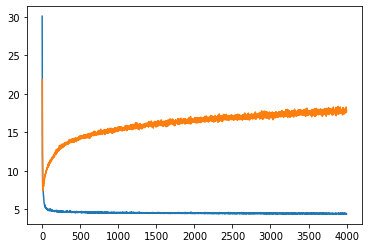

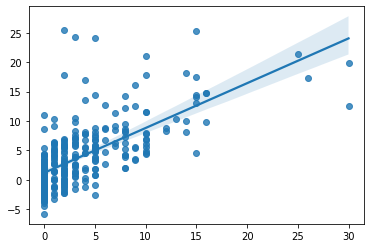

In [8]:
test(model_1, EPOCHS, "flatten")

In [9]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=INPUT_LENGTH),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1, activation='linear')
])
print(model_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 32)            3168      
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 flatten_1 (Flatten)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               4224      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 15,841
Trainable params: 15,841
Non-trainable params: 0
_________________________________________________________________
None


10/10 [==============================] - 0s 3ms/step
RNN Score: 0.41842742075748895
10/10 [==============================] - 0s 2ms/step


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,-0.02,0.15,-0.03,0.09,-0.16,-0.44,-0.57,0.01,0.63,0.43,...,-0.00,0.06,0.18,0.59,0.11,-0.65,0.00,-0.30,-0.12,-0.12
1,-0.01,0.19,0.05,0.10,-0.21,-0.44,-0.59,0.01,0.63,0.46,...,-0.01,0.03,0.18,0.64,0.09,-0.73,0.00,-0.39,-0.09,-0.12
2,-0.02,0.18,0.01,0.04,-0.14,-0.51,-0.63,-0.01,0.67,0.47,...,-0.01,0.04,0.20,0.65,0.18,-0.68,-0.00,-0.15,-0.15,-0.18
3,-0.12,0.32,0.04,0.08,-0.50,-0.41,-0.27,0.03,0.51,0.57,...,0.01,0.15,0.17,0.67,0.12,0.84,-0.04,-0.55,-0.29,0.47
4,-0.05,0.44,-0.01,0.05,-0.11,-0.43,0.06,0.07,0.74,0.59,...,0.18,0.45,0.10,-0.87,0.17,-0.23,-0.46,-0.56,0.65,0.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,-0.02,0.27,-0.03,0.11,-0.19,-0.39,-0.47,0.02,0.63,0.39,...,-0.01,0.06,0.12,0.67,0.09,-0.70,0.00,-0.59,-0.05,0.42
1265,-0.03,0.29,0.04,0.07,-0.31,-0.47,-0.40,-0.02,0.55,0.58,...,-0.00,0.14,0.25,0.62,0.09,-0.44,0.01,-0.28,-0.25,-0.14
1266,-0.02,0.28,-0.02,0.10,-0.20,-0.39,-0.59,0.02,0.64,0.41,...,-0.00,0.07,0.12,0.66,0.06,-0.71,0.00,-0.53,-0.06,0.27
1267,-0.04,0.35,-0.02,0.11,-0.56,-0.45,0.40,0.00,0.08,0.70,...,-0.03,0.44,0.33,0.60,0.08,0.05,0.01,-0.58,-0.33,0.16


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,-0.02,0.17,-0.02,0.07,-0.15,-0.48,-0.61,-0.01,0.65,0.44,...,-0.01,0.05,0.19,0.62,0.13,-0.68,0.00,-0.21,-0.14,-0.15
1,-0.07,0.15,-0.32,-0.03,-0.05,-0.51,-0.25,-0.23,0.10,-0.65,...,-0.07,0.19,0.27,-0.11,0.24,-0.03,-0.15,0.17,-0.47,-0.12
2,-0.04,0.25,0.05,0.14,-0.28,-0.46,-0.43,-0.04,-0.09,0.62,...,-0.00,0.23,0.31,0.54,0.07,-0.36,0.01,-0.19,-0.30,-0.10
3,-0.05,0.42,0.00,0.12,-0.31,-0.42,0.02,0.01,0.65,0.53,...,0.03,0.20,0.20,0.64,0.08,-0.38,-0.01,-0.57,-0.35,0.55
4,-0.25,0.60,-0.01,0.15,-0.41,0.34,0.05,0.03,0.59,0.66,...,0.41,0.72,0.14,-0.70,-0.03,0.92,-0.34,-0.62,0.59,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,0.17,0.34,-0.00,-0.14,-0.12,-0.46,0.45,0.06,0.72,0.71,...,-0.23,0.36,0.12,-0.91,0.56,-0.00,-0.50,-0.67,0.69,0.91
314,-0.02,0.21,0.02,0.07,-0.20,-0.48,-0.59,-0.01,0.63,0.48,...,-0.00,0.09,0.21,0.58,0.08,-0.66,0.01,-0.20,-0.18,-0.16
315,-0.02,0.24,-0.02,0.09,-0.21,-0.39,-0.59,0.02,0.63,0.40,...,-0.00,0.07,0.13,0.64,0.06,-0.68,0.00,-0.50,-0.10,0.08
316,-0.08,0.34,0.03,0.05,-0.41,-0.37,-0.38,0.06,0.56,0.49,...,0.05,0.18,0.13,0.63,0.05,0.38,-0.01,-0.55,-0.19,0.48


  5%|████                                                                                | 2/42 [00:00<00:08,  4.94it/s]

AdaBoostRegressor (StandardScaler) 0.4499877341221554
BaggingRegressor (StandardScaler) 0.4387396042915995
BayesianRidge (StandardScaler) 0.4212305141591488



 17%|██████████████                                                                      | 7/42 [00:00<00:02, 12.83it/s]

DecisionTreeRegressor (StandardScaler) 0.37859999634749875
DummyRegressor (StandardScaler) -0.00010814299313310904
ElasticNet (StandardScaler) 0.37921307258683745
ElasticNetCV (StandardScaler) 0.4258908908290562
ExtraTreeRegressor (StandardScaler) 0.3951725517218646



 26%|█████████████████████▋                                                             | 11/42 [00:01<00:03,  9.61it/s]

ExtraTreesRegressor (StandardScaler) 0.45326566469357354
GammaRegressor (StandardScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor (StandardScaler) 0.3179277575474544



 31%|█████████████████████████▋                                                         | 13/42 [00:02<00:07,  4.10it/s]

GradientBoostingRegressor (StandardScaler) 0.4650049808397443
HistGradientBoostingRegressor (StandardScaler) 0.4709056339009119



 40%|█████████████████████████████████▌                                                 | 17/42 [00:02<00:03,  6.92it/s]

HuberRegressor (StandardScaler) 0.4215056580603096
KNeighborsRegressor (StandardScaler) 0.43343957360168206
KernelRidge (StandardScaler) 0.4217191726580857
Lars (StandardScaler) 0.4425007638507955



 50%|█████████████████████████████████████████▌                                         | 21/42 [00:02<00:02,  9.53it/s]

LarsCV (StandardScaler) 0.4389404231909123
Lasso (StandardScaler) -0.00010814299313310904
LassoCV (StandardScaler) 0.42557993145007145
LassoLars (StandardScaler) -0.00010814299313310904



 55%|█████████████████████████████████████████████▍                                     | 23/42 [00:02<00:01, 10.84it/s]

LassoLarsCV (StandardScaler) 0.42121190574682754
LassoLarsIC (StandardScaler) 0.42121190574682754
LinearRegression (StandardScaler) 0.42121253445388995



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:03<00:01, 10.99it/s]

LinearSVR (StandardScaler) 0.42498430620927174
MLPRegressor (StandardScaler) 0.39303855725480275



 64%|█████████████████████████████████████████████████████▎                             | 27/42 [00:03<00:02,  6.90it/s]

NuSVR (StandardScaler) 0.552261081948872
OrthogonalMatchingPursuit (StandardScaler) 0.4885878299913301
OrthogonalMatchingPursuitCV (StandardScaler) 0.46384064127544256
PassiveAggressiveRegressor (StandardScaler) 0.43621047608733876
PoissonRegressor (StandardScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.
RANSACRegressor (StandardScaler) 0.42206488407663745



 88%|█████████████████████████████████████████████████████████████████████████          | 37/42 [00:05<00:00,  7.51it/s]

RandomForestRegressor (StandardScaler) 0.46031748708395437
Ridge (StandardScaler) 0.42171849120799954
RidgeCV (StandardScaler) 0.42126384516623705
SGDRegressor (StandardScaler) 0.4484546398488234
SVR (StandardScaler) 0.5462177895131742
TransformedTargetRegressor (StandardScaler) 0.42121253445388995



 93%|█████████████████████████████████████████████████████████████████████████████      | 39/42 [00:05<00:00,  6.35it/s]

TweedieRegressor (StandardScaler) 0.5143685690335429



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:05<00:00,  6.44it/s]

XGBRegressor (StandardScaler) 0.444119138348404
LGBMRegressor (StandardScaler) 0.49998820715891
Learning rate set to 0.042513
0:	learn: 0.9668973	total: 6.18ms	remaining: 6.17s
1:	learn: 0.9344046	total: 7.35ms	remaining: 3.67s
2:	learn: 0.9023764	total: 8.32ms	remaining: 2.77s
3:	learn: 0.8749752	total: 9.25ms	remaining: 2.3s
4:	learn: 0.8473485	total: 10.5ms	remaining: 2.09s
5:	learn: 0.8207956	total: 12.6ms	remaining: 2.09s
6:	learn: 0.7933066	total: 13.7ms	remaining: 1.94s
7:	learn: 0.7687336	total: 14.6ms	remaining: 1.81s
8:	learn: 0.7434811	total: 15.7ms	remaining: 1.73s
9:	learn: 0.7184420	total: 16.6ms	remaining: 1.64s
10:	learn: 0.6971978	total: 17.9ms	remaining: 1.61s
11:	learn: 0.6745059	total: 19.2ms	remaining: 1.58s
12:	learn: 0.6529087	total: 20.2ms	remaining: 1.53s
13:	learn: 0.6324611	total: 21.2ms	remaining: 1.49s
14:	learn: 0.6137651	total: 22.2ms	remaining: 1.46s
15:	learn: 0.5954633	total: 23.1ms	remaining: 1.42s
16:	learn: 0.5782209	total: 24.2ms	remaining: 1.4s
17

236:	learn: 0.0388809	total: 288ms	remaining: 928ms
237:	learn: 0.0387424	total: 290ms	remaining: 928ms
238:	learn: 0.0385771	total: 291ms	remaining: 927ms
239:	learn: 0.0384353	total: 293ms	remaining: 928ms
240:	learn: 0.0383278	total: 294ms	remaining: 927ms
241:	learn: 0.0382368	total: 296ms	remaining: 926ms
242:	learn: 0.0381363	total: 297ms	remaining: 926ms
243:	learn: 0.0379992	total: 299ms	remaining: 925ms
244:	learn: 0.0379215	total: 301ms	remaining: 927ms
245:	learn: 0.0377617	total: 302ms	remaining: 927ms
246:	learn: 0.0376641	total: 304ms	remaining: 928ms
247:	learn: 0.0375296	total: 306ms	remaining: 928ms
248:	learn: 0.0374284	total: 308ms	remaining: 930ms
249:	learn: 0.0373422	total: 310ms	remaining: 930ms
250:	learn: 0.0371832	total: 311ms	remaining: 929ms
251:	learn: 0.0370666	total: 312ms	remaining: 928ms
252:	learn: 0.0369880	total: 314ms	remaining: 926ms
253:	learn: 0.0368992	total: 315ms	remaining: 924ms
254:	learn: 0.0367565	total: 317ms	remaining: 925ms
255:	learn: 

538:	learn: 0.0205268	total: 668ms	remaining: 571ms
539:	learn: 0.0204882	total: 670ms	remaining: 571ms
540:	learn: 0.0204558	total: 672ms	remaining: 570ms
541:	learn: 0.0204097	total: 673ms	remaining: 569ms
542:	learn: 0.0203875	total: 674ms	remaining: 567ms
543:	learn: 0.0203658	total: 675ms	remaining: 566ms
544:	learn: 0.0203371	total: 677ms	remaining: 565ms
545:	learn: 0.0203204	total: 679ms	remaining: 564ms
546:	learn: 0.0203133	total: 680ms	remaining: 563ms
547:	learn: 0.0203069	total: 681ms	remaining: 562ms
548:	learn: 0.0202704	total: 682ms	remaining: 561ms
549:	learn: 0.0202368	total: 685ms	remaining: 560ms
550:	learn: 0.0202123	total: 686ms	remaining: 559ms
551:	learn: 0.0202049	total: 688ms	remaining: 558ms
552:	learn: 0.0201718	total: 689ms	remaining: 557ms
553:	learn: 0.0201433	total: 690ms	remaining: 556ms
554:	learn: 0.0201235	total: 692ms	remaining: 555ms
555:	learn: 0.0200970	total: 694ms	remaining: 554ms
556:	learn: 0.0200595	total: 695ms	remaining: 553ms
557:	learn: 

841:	learn: 0.0148191	total: 1.05s	remaining: 196ms
842:	learn: 0.0148023	total: 1.05s	remaining: 195ms
843:	learn: 0.0147846	total: 1.05s	remaining: 194ms
844:	learn: 0.0147722	total: 1.05s	remaining: 193ms
845:	learn: 0.0147592	total: 1.05s	remaining: 192ms
846:	learn: 0.0147430	total: 1.05s	remaining: 191ms
847:	learn: 0.0147299	total: 1.05s	remaining: 189ms
848:	learn: 0.0147200	total: 1.06s	remaining: 188ms
849:	learn: 0.0147048	total: 1.06s	remaining: 187ms
850:	learn: 0.0146899	total: 1.06s	remaining: 186ms
851:	learn: 0.0146846	total: 1.06s	remaining: 185ms
852:	learn: 0.0146778	total: 1.06s	remaining: 183ms
853:	learn: 0.0146684	total: 1.06s	remaining: 182ms
854:	learn: 0.0146645	total: 1.07s	remaining: 181ms
855:	learn: 0.0146522	total: 1.07s	remaining: 180ms
856:	learn: 0.0146338	total: 1.07s	remaining: 179ms
857:	learn: 0.0146204	total: 1.08s	remaining: 179ms
858:	learn: 0.0146071	total: 1.08s	remaining: 178ms
859:	learn: 0.0145915	total: 1.08s	remaining: 176ms
860:	learn: 

 17%|██████████████▏                                                                      | 1/6 [00:07<00:36,  7.30s/it]

977:	learn: 0.0134202	total: 1.24s	remaining: 27.8ms
978:	learn: 0.0134104	total: 1.24s	remaining: 26.6ms
979:	learn: 0.0134051	total: 1.24s	remaining: 25.3ms
980:	learn: 0.0133941	total: 1.24s	remaining: 24.1ms
981:	learn: 0.0133927	total: 1.24s	remaining: 22.8ms
982:	learn: 0.0133820	total: 1.25s	remaining: 21.5ms
983:	learn: 0.0133748	total: 1.25s	remaining: 20.3ms
984:	learn: 0.0133706	total: 1.25s	remaining: 19ms
985:	learn: 0.0133621	total: 1.25s	remaining: 17.8ms
986:	learn: 0.0133561	total: 1.25s	remaining: 16.5ms
987:	learn: 0.0133481	total: 1.25s	remaining: 15.2ms
988:	learn: 0.0133394	total: 1.25s	remaining: 14ms
989:	learn: 0.0133315	total: 1.26s	remaining: 12.7ms
990:	learn: 0.0133221	total: 1.26s	remaining: 11.4ms
991:	learn: 0.0133155	total: 1.26s	remaining: 10.2ms
992:	learn: 0.0133053	total: 1.26s	remaining: 8.89ms
993:	learn: 0.0132997	total: 1.26s	remaining: 7.62ms
994:	learn: 0.0132965	total: 1.26s	remaining: 6.35ms
995:	learn: 0.0132859	total: 1.26s	remaining: 5.08


  5%|████                                                                                | 2/42 [00:00<00:07,  5.21it/s]

AdaBoostRegressor (MinMaxScaler) 0.4697147869737035
BaggingRegressor (MinMaxScaler) 0.4705284850984641
BayesianRidge (MinMaxScaler) 0.42122318509699685



 17%|██████████████                                                                      | 7/42 [00:00<00:02, 14.17it/s]

DecisionTreeRegressor (MinMaxScaler) 0.3934728024526991
DummyRegressor (MinMaxScaler) -0.000108142993132887
ElasticNet (MinMaxScaler) -0.00010814289571348112
ElasticNetCV (MinMaxScaler) 0.43253300176263343
ExtraTreeRegressor (MinMaxScaler) 0.36057557180572086



 26%|█████████████████████▋                                                             | 11/42 [00:01<00:02, 10.98it/s]

ExtraTreesRegressor (MinMaxScaler) 0.45932229037502215
GammaRegressor (MinMaxScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor (MinMaxScaler) -2.0299978605060103
GradientBoostingRegressor (MinMaxScaler) 0.4666942591429184



 36%|█████████████████████████████▋                                                     | 15/42 [00:02<00:04,  5.57it/s]

HistGradientBoostingRegressor (MinMaxScaler) 0.471748704186577
HuberRegressor (MinMaxScaler) 0.4335877955669617
KNeighborsRegressor (MinMaxScaler) 0.43330359366014903
KernelRidge (MinMaxScaler) 0.42821645301582734
Lars (MinMaxScaler) 0.4509178089624494



 48%|███████████████████████████████████████▌                                           | 20/42 [00:02<00:02,  8.79it/s]

LarsCV (MinMaxScaler) 0.5308400101888102
Lasso (MinMaxScaler) -0.00010814289571348112
LassoCV (MinMaxScaler) 0.4320259121112814



 52%|███████████████████████████████████████████▍                                       | 22/42 [00:02<00:01, 10.39it/s]

LassoLars (MinMaxScaler) -0.00010814289571348112
LassoLarsCV (MinMaxScaler) 0.4212119405777385
LassoLarsIC (MinMaxScaler) 0.42165014597952055
LinearRegression (MinMaxScaler) 0.42121267012599684



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:02<00:01, 11.93it/s]

LinearSVR (MinMaxScaler) 0.42239158995261383
MLPRegressor (MinMaxScaler) 0.4297023013421205



 64%|█████████████████████████████████████████████████████▎                             | 27/42 [00:03<00:02,  7.22it/s]

NuSVR (MinMaxScaler) 0.48464208639538175
OrthogonalMatchingPursuit (MinMaxScaler) 0.5047544948838782
OrthogonalMatchingPursuitCV (MinMaxScaler) 0.5244292049411365
PassiveAggressiveRegressor (MinMaxScaler) 0.4371186133949171



 74%|█████████████████████████████████████████████████████████████▎                     | 31/42 [00:03<00:01,  8.21it/s]

PoissonRegressor (MinMaxScaler) 0.05378373182598417
RANSACRegressor (MinMaxScaler) 0.42274641517874345



 90%|███████████████████████████████████████████████████████████████████████████        | 38/42 [00:05<00:00,  7.32it/s]

RandomForestRegressor (MinMaxScaler) 0.4594567009937337
Ridge (MinMaxScaler) 0.43111257215231913
RidgeCV (MinMaxScaler) 0.422458240076084
SGDRegressor (MinMaxScaler) 0.49495538466762146
SVR (MinMaxScaler) 0.27988181911927523
TransformedTargetRegressor (MinMaxScaler) 0.42121267012599684



 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [00:06<00:00,  4.96it/s]

TweedieRegressor (MinMaxScaler) 0.3362524018441162
XGBRegressor (MinMaxScaler) 0.44585064125440965
LGBMRegressor (MinMaxScaler) 0.4799110157943456
Learning rate set to 0.042513
0:	learn: 0.1408487	total: 5.48ms	remaining: 5.48s
1:	learn: 0.1361155	total: 6.48ms	remaining: 3.23s
2:	learn: 0.1314499	total: 7.73ms	remaining: 2.57s
3:	learn: 0.1274583	total: 8.85ms	remaining: 2.2s
4:	learn: 0.1234339	total: 9.76ms	remaining: 1.94s
5:	learn: 0.1195660	total: 10.7ms	remaining: 1.77s
6:	learn: 0.1155616	total: 11.6ms	remaining: 1.64s
7:	learn: 0.1119820	total: 12.5ms	remaining: 1.54s
8:	learn: 0.1083035	total: 13.4ms	remaining: 1.47s
9:	learn: 0.1046560	total: 14.5ms	remaining: 1.44s
10:	learn: 0.1015614	total: 15.9ms	remaining: 1.43s
11:	learn: 0.0982558	total: 17.1ms	remaining: 1.41s
12:	learn: 0.0951097	total: 18ms	remaining: 1.36s
13:	learn: 0.0921311	total: 18.9ms	remaining: 1.33s
14:	learn: 0.0894077	total: 19.8ms	remaining: 1.3s
15:	learn: 0.0867416	total: 20.8ms	remaining: 1.28s
16:	l

303:	learn: 0.0046187	total: 365ms	remaining: 835ms
304:	learn: 0.0046067	total: 367ms	remaining: 836ms
305:	learn: 0.0045984	total: 368ms	remaining: 835ms
306:	learn: 0.0045897	total: 370ms	remaining: 835ms
307:	learn: 0.0045791	total: 371ms	remaining: 834ms
308:	learn: 0.0045652	total: 372ms	remaining: 833ms
309:	learn: 0.0045472	total: 374ms	remaining: 833ms
310:	learn: 0.0045328	total: 375ms	remaining: 832ms
311:	learn: 0.0045226	total: 377ms	remaining: 831ms
312:	learn: 0.0045158	total: 378ms	remaining: 830ms
313:	learn: 0.0044975	total: 380ms	remaining: 829ms
314:	learn: 0.0044837	total: 382ms	remaining: 831ms
315:	learn: 0.0044728	total: 383ms	remaining: 829ms
316:	learn: 0.0044646	total: 384ms	remaining: 828ms
317:	learn: 0.0044573	total: 387ms	remaining: 829ms
318:	learn: 0.0044519	total: 388ms	remaining: 828ms
319:	learn: 0.0044467	total: 389ms	remaining: 826ms
320:	learn: 0.0044352	total: 390ms	remaining: 825ms
321:	learn: 0.0044231	total: 391ms	remaining: 823ms
322:	learn: 

461:	learn: 0.0033386	total: 556ms	remaining: 647ms
462:	learn: 0.0033311	total: 558ms	remaining: 647ms
463:	learn: 0.0033260	total: 560ms	remaining: 646ms
464:	learn: 0.0033196	total: 561ms	remaining: 645ms
465:	learn: 0.0033135	total: 562ms	remaining: 644ms
466:	learn: 0.0033090	total: 563ms	remaining: 643ms
467:	learn: 0.0033043	total: 565ms	remaining: 642ms
468:	learn: 0.0033010	total: 567ms	remaining: 642ms
469:	learn: 0.0032998	total: 568ms	remaining: 641ms
470:	learn: 0.0032965	total: 570ms	remaining: 640ms
471:	learn: 0.0032882	total: 572ms	remaining: 640ms
472:	learn: 0.0032830	total: 573ms	remaining: 639ms
473:	learn: 0.0032789	total: 575ms	remaining: 638ms
474:	learn: 0.0032741	total: 576ms	remaining: 637ms
475:	learn: 0.0032694	total: 577ms	remaining: 635ms
476:	learn: 0.0032625	total: 578ms	remaining: 634ms
477:	learn: 0.0032600	total: 580ms	remaining: 633ms
478:	learn: 0.0032537	total: 581ms	remaining: 632ms
479:	learn: 0.0032456	total: 583ms	remaining: 631ms
480:	learn: 

771:	learn: 0.0022829	total: 937ms	remaining: 277ms
772:	learn: 0.0022808	total: 939ms	remaining: 276ms
773:	learn: 0.0022782	total: 941ms	remaining: 275ms
774:	learn: 0.0022768	total: 942ms	remaining: 274ms
775:	learn: 0.0022761	total: 944ms	remaining: 272ms
776:	learn: 0.0022743	total: 946ms	remaining: 271ms
777:	learn: 0.0022731	total: 948ms	remaining: 271ms
778:	learn: 0.0022718	total: 950ms	remaining: 269ms
779:	learn: 0.0022695	total: 951ms	remaining: 268ms
780:	learn: 0.0022670	total: 953ms	remaining: 267ms
781:	learn: 0.0022642	total: 954ms	remaining: 266ms
782:	learn: 0.0022633	total: 956ms	remaining: 265ms
783:	learn: 0.0022623	total: 958ms	remaining: 264ms
784:	learn: 0.0022606	total: 960ms	remaining: 263ms
785:	learn: 0.0022577	total: 961ms	remaining: 262ms
786:	learn: 0.0022551	total: 963ms	remaining: 260ms
787:	learn: 0.0022523	total: 964ms	remaining: 259ms
788:	learn: 0.0022491	total: 965ms	remaining: 258ms
789:	learn: 0.0022457	total: 966ms	remaining: 257ms
790:	learn: 


 33%|████████████████████████████▎                                                        | 2/6 [00:14<00:29,  7.42s/it]

922:	learn: 0.0020225	total: 1.13s	remaining: 94.1ms
923:	learn: 0.0020211	total: 1.13s	remaining: 93ms
924:	learn: 0.0020196	total: 1.13s	remaining: 91.8ms
925:	learn: 0.0020176	total: 1.13s	remaining: 90.6ms
926:	learn: 0.0020164	total: 1.13s	remaining: 89.4ms
927:	learn: 0.0020147	total: 1.14s	remaining: 88.2ms
928:	learn: 0.0020127	total: 1.14s	remaining: 86.9ms
929:	learn: 0.0020111	total: 1.14s	remaining: 85.7ms
930:	learn: 0.0020092	total: 1.14s	remaining: 84.5ms
931:	learn: 0.0020078	total: 1.14s	remaining: 83.3ms
932:	learn: 0.0020063	total: 1.14s	remaining: 82.1ms
933:	learn: 0.0020050	total: 1.14s	remaining: 80.9ms
934:	learn: 0.0020036	total: 1.15s	remaining: 79.7ms
935:	learn: 0.0020019	total: 1.15s	remaining: 78.5ms
936:	learn: 0.0020013	total: 1.15s	remaining: 77.3ms
937:	learn: 0.0020000	total: 1.15s	remaining: 76.1ms
938:	learn: 0.0019994	total: 1.15s	remaining: 74.8ms
939:	learn: 0.0019978	total: 1.15s	remaining: 73.6ms
940:	learn: 0.0019970	total: 1.15s	remaining: 72


  5%|████                                                                                | 2/42 [00:00<00:07,  5.20it/s]

AdaBoostRegressor (MaxAbsScaler) 0.467896604981795
BaggingRegressor (MaxAbsScaler) 0.4396918431782343
BayesianRidge (MaxAbsScaler) 0.421224609241604



 17%|██████████████                                                                      | 7/42 [00:00<00:02, 14.79it/s]

DecisionTreeRegressor (MaxAbsScaler) 0.36075262902125893
DummyRegressor (MaxAbsScaler) -0.000108142993132887
ElasticNet (MaxAbsScaler) -0.00010814289571348112
ElasticNetCV (MaxAbsScaler) 0.4303798074665316
ExtraTreeRegressor (MaxAbsScaler) 0.40820396278546867



 26%|█████████████████████▋                                                             | 11/42 [00:01<00:02, 10.91it/s]

ExtraTreesRegressor (MaxAbsScaler) 0.45541865485958655
GammaRegressor (MaxAbsScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor (MaxAbsScaler) 0.21659313257440682



 31%|█████████████████████████▋                                                         | 13/42 [00:02<00:06,  4.23it/s]

GradientBoostingRegressor (MaxAbsScaler) 0.47191675315003523
HistGradientBoostingRegressor (MaxAbsScaler) 0.471748704186577



 40%|█████████████████████████████████▌                                                 | 17/42 [00:02<00:03,  7.00it/s]

HuberRegressor (MaxAbsScaler) 0.4234031124563242
KNeighborsRegressor (MaxAbsScaler) 0.42980777599656494
KernelRidge (MaxAbsScaler) 0.44548835532541875
Lars (MaxAbsScaler) 0.45846316320121183



 50%|█████████████████████████████████████████▌                                         | 21/42 [00:02<00:02,  9.60it/s]

LarsCV (MaxAbsScaler) 0.44757625443096194
Lasso (MaxAbsScaler) -0.00010814289571348112
LassoCV (MaxAbsScaler) 0.4301466440031003
LassoLars (MaxAbsScaler) -0.00010814289571348112



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:02<00:01, 11.38it/s]

LassoLarsCV (MaxAbsScaler) 0.42121220207863697
LassoLarsIC (MaxAbsScaler) 0.42163500790120656
LinearRegression (MaxAbsScaler) 0.42121280511647297
LinearSVR (MaxAbsScaler) 0.42510040890135303
MLPRegressor (MaxAbsScaler) 0.421687977967956



 64%|█████████████████████████████████████████████████████▎                             | 27/42 [00:03<00:02,  6.63it/s]

NuSVR (MaxAbsScaler) 0.4881722831843742
OrthogonalMatchingPursuit (MaxAbsScaler) 0.4536604213486519
OrthogonalMatchingPursuitCV (MaxAbsScaler) 0.4203095699952951
PassiveAggressiveRegressor (MaxAbsScaler) 0.29568942923474406



 74%|█████████████████████████████████████████████████████████████▎                     | 31/42 [00:04<00:01,  7.36it/s]

PoissonRegressor (MaxAbsScaler) 0.13911906987534606
RANSACRegressor (MaxAbsScaler) 0.4211784042242883



 79%|█████████████████████████████████████████████████████████████████▏                 | 33/42 [00:05<00:02,  3.99it/s]

RandomForestRegressor (MaxAbsScaler) 0.4724991248484013
Ridge (MaxAbsScaler) 0.4250265219826864
RidgeCV (MaxAbsScaler) 0.42166175959567387
SGDRegressor (MaxAbsScaler) 0.46470608331379504
SVR (MaxAbsScaler) 0.3107782331486967
TransformedTargetRegressor (MaxAbsScaler) 0.42121280511647297



 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [00:05<00:00,  5.81it/s]

TweedieRegressor (MaxAbsScaler) 0.5045050191477503
XGBRegressor (MaxAbsScaler) 0.44585064125440965
LGBMRegressor (MaxAbsScaler) 0.4898758230396526
Learning rate set to 0.042513
0:	learn: 0.1408487	total: 1.34ms	remaining: 1.34s
1:	learn: 0.1361155	total: 2.34ms	remaining: 1.17s
2:	learn: 0.1314499	total: 3.46ms	remaining: 1.15s
3:	learn: 0.1274583	total: 4.4ms	remaining: 1.1s
4:	learn: 0.1234339	total: 5.36ms	remaining: 1.07s
5:	learn: 0.1195660	total: 6.28ms	remaining: 1.04s
6:	learn: 0.1155616	total: 7.24ms	remaining: 1.03s
7:	learn: 0.1119820	total: 8.19ms	remaining: 1.01s
8:	learn: 0.1083035	total: 9.19ms	remaining: 1.01s
9:	learn: 0.1046560	total: 10.3ms	remaining: 1.01s
10:	learn: 0.1015614	total: 11.5ms	remaining: 1.03s
11:	learn: 0.0982558	total: 12.5ms	remaining: 1.02s
12:	learn: 0.0951097	total: 13.4ms	remaining: 1.02s
13:	learn: 0.0921311	total: 14.4ms	remaining: 1.01s
14:	learn: 0.0894077	total: 15.3ms	remaining: 1s
15:	learn: 0.0867416	total: 16.3ms	remaining: 999ms
16:	le

300:	learn: 0.0046797	total: 365ms	remaining: 848ms
301:	learn: 0.0046674	total: 367ms	remaining: 847ms
302:	learn: 0.0046565	total: 368ms	remaining: 847ms
303:	learn: 0.0046452	total: 369ms	remaining: 846ms
304:	learn: 0.0046333	total: 371ms	remaining: 845ms
305:	learn: 0.0046222	total: 372ms	remaining: 845ms
306:	learn: 0.0046161	total: 374ms	remaining: 843ms
307:	learn: 0.0045951	total: 375ms	remaining: 843ms
308:	learn: 0.0045825	total: 377ms	remaining: 842ms
309:	learn: 0.0045673	total: 378ms	remaining: 842ms
310:	learn: 0.0045557	total: 380ms	remaining: 842ms
311:	learn: 0.0045420	total: 382ms	remaining: 842ms
312:	learn: 0.0045342	total: 383ms	remaining: 841ms
313:	learn: 0.0045199	total: 385ms	remaining: 840ms
314:	learn: 0.0045059	total: 387ms	remaining: 841ms
315:	learn: 0.0044928	total: 389ms	remaining: 841ms
316:	learn: 0.0044820	total: 390ms	remaining: 840ms
317:	learn: 0.0044684	total: 391ms	remaining: 839ms
318:	learn: 0.0044537	total: 392ms	remaining: 837ms
319:	learn: 

606:	learn: 0.0027403	total: 747ms	remaining: 484ms
607:	learn: 0.0027342	total: 749ms	remaining: 483ms
608:	learn: 0.0027305	total: 750ms	remaining: 482ms
609:	learn: 0.0027259	total: 752ms	remaining: 481ms
610:	learn: 0.0027212	total: 753ms	remaining: 479ms
611:	learn: 0.0027170	total: 754ms	remaining: 478ms
612:	learn: 0.0027142	total: 756ms	remaining: 477ms
613:	learn: 0.0027105	total: 757ms	remaining: 476ms
614:	learn: 0.0027075	total: 759ms	remaining: 475ms
615:	learn: 0.0027027	total: 761ms	remaining: 474ms
616:	learn: 0.0026997	total: 762ms	remaining: 473ms
617:	learn: 0.0026945	total: 763ms	remaining: 472ms
618:	learn: 0.0026920	total: 765ms	remaining: 471ms
619:	learn: 0.0026884	total: 766ms	remaining: 470ms
620:	learn: 0.0026847	total: 768ms	remaining: 469ms
621:	learn: 0.0026815	total: 770ms	remaining: 468ms
622:	learn: 0.0026783	total: 771ms	remaining: 467ms
623:	learn: 0.0026744	total: 772ms	remaining: 465ms
624:	learn: 0.0026698	total: 774ms	remaining: 465ms
625:	learn: 


 50%|██████████████████████████████████████████▌                                          | 3/6 [00:22<00:22,  7.42s/it]

913:	learn: 0.0020505	total: 1.13s	remaining: 106ms
914:	learn: 0.0020482	total: 1.13s	remaining: 105ms
915:	learn: 0.0020466	total: 1.13s	remaining: 104ms
916:	learn: 0.0020454	total: 1.13s	remaining: 102ms
917:	learn: 0.0020432	total: 1.13s	remaining: 101ms
918:	learn: 0.0020417	total: 1.14s	remaining: 100ms
919:	learn: 0.0020401	total: 1.14s	remaining: 98.8ms
920:	learn: 0.0020384	total: 1.14s	remaining: 97.6ms
921:	learn: 0.0020364	total: 1.14s	remaining: 96.4ms
922:	learn: 0.0020358	total: 1.14s	remaining: 95.1ms
923:	learn: 0.0020349	total: 1.14s	remaining: 93.9ms
924:	learn: 0.0020340	total: 1.14s	remaining: 92.7ms
925:	learn: 0.0020324	total: 1.15s	remaining: 91.5ms
926:	learn: 0.0020314	total: 1.15s	remaining: 90.3ms
927:	learn: 0.0020293	total: 1.15s	remaining: 89.1ms
928:	learn: 0.0020282	total: 1.15s	remaining: 87.9ms
929:	learn: 0.0020264	total: 1.15s	remaining: 86.7ms
930:	learn: 0.0020243	total: 1.15s	remaining: 85.4ms
931:	learn: 0.0020220	total: 1.15s	remaining: 84.2ms


  7%|██████                                                                              | 3/42 [00:00<00:03, 10.76it/s]

AdaBoostRegressor (Normalizer) 0.4915260053647117
BaggingRegressor (Normalizer) 0.5158075335397317
BayesianRidge (Normalizer) 0.486719639313253
DecisionTreeRegressor (Normalizer) 0.4120227038183695
DummyRegressor (Normalizer) -9.966805454642014e-05
ElasticNet (Normalizer) -9.966717060505559e-05



 21%|██████████████████                                                                  | 9/42 [00:00<00:02, 13.34it/s]

ElasticNetCV (Normalizer) 0.4860502745680342
ExtraTreeRegressor (Normalizer) 0.4256965944272446
ExtraTreesRegressor (Normalizer) 0.5343725748194015
GammaRegressor (Normalizer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 26%|█████████████████████▋                                                             | 11/42 [00:00<00:02, 13.84it/s]

GaussianProcessRegressor (Normalizer) -107.96511210435501



 31%|█████████████████████████▋                                                         | 13/42 [00:01<00:06,  4.63it/s]

GradientBoostingRegressor (Normalizer) 0.5075164860718058
HistGradientBoostingRegressor (Normalizer) 0.5344997059143759



 38%|███████████████████████████████▌                                                   | 16/42 [00:02<00:03,  6.65it/s]

HuberRegressor (Normalizer) 0.47587963788760757
KNeighborsRegressor (Normalizer) 0.48476780185758517
KernelRidge (Normalizer) 0.43979593765478864
Lars (Normalizer) 0.2380134848113511



 50%|█████████████████████████████████████████▌                                         | 21/42 [00:02<00:01, 11.15it/s]

LarsCV (Normalizer) 0.39787381512979625
Lasso (Normalizer) -9.966717060505559e-05
LassoCV (Normalizer) 0.48780726239078864
LassoLars (Normalizer) -9.966717060505559e-05



 55%|█████████████████████████████████████████████▍                                     | 23/42 [00:02<00:01, 11.95it/s]

LassoLarsCV (Normalizer) 0.48776601597600233
LassoLarsIC (Normalizer) 0.4871047390728266
LinearRegression (Normalizer) 0.4862273482405749
LinearSVR (Normalizer) 0.4641976679487354



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:02<00:01,  8.85it/s]

MLPRegressor (Normalizer) 0.5413048574334038
NuSVR (Normalizer) 0.5542248722635306



 67%|███████████████████████████████████████████████████████▎                           | 28/42 [00:03<00:01,  9.03it/s]

OrthogonalMatchingPursuit (Normalizer) 0.4142027015730758
OrthogonalMatchingPursuitCV (Normalizer) 0.43103498978742194
PassiveAggressiveRegressor (Normalizer) 0.44659859877644437



 74%|█████████████████████████████████████████████████████████████▎                     | 31/42 [00:03<00:01,  8.18it/s]

PoissonRegressor (Normalizer) 0.10056003442191486
RANSACRegressor (Normalizer) -0.0769808890514263



 88%|█████████████████████████████████████████████████████████████████████████          | 37/42 [00:04<00:00,  7.67it/s]

RandomForestRegressor (Normalizer) 0.5079450464396285
Ridge (Normalizer) 0.47743626141033824
RidgeCV (Normalizer) 0.4863797056904944
SGDRegressor (Normalizer) 0.4593749696194849
SVR (Normalizer) 0.5284226759270816
TransformedTargetRegressor (Normalizer) 0.4862273482405749



 93%|█████████████████████████████████████████████████████████████████████████████      | 39/42 [00:05<00:00,  6.67it/s]

TweedieRegressor (Normalizer) 0.14522235598707756
XGBRegressor (Normalizer) 0.46120913354239246



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:05<00:00,  7.06it/s]

LGBMRegressor (Normalizer) 0.5258986489455404
Learning rate set to 0.042513
0:	learn: 0.4630955	total: 1.38ms	remaining: 1.38s
1:	learn: 0.4450825	total: 2.55ms	remaining: 1.27s
2:	learn: 0.4282959	total: 4.1ms	remaining: 1.36s
3:	learn: 0.4125343	total: 5.66ms	remaining: 1.41s
4:	learn: 0.3968929	total: 6.76ms	remaining: 1.34s
5:	learn: 0.3816466	total: 7.93ms	remaining: 1.31s
6:	learn: 0.3666741	total: 9.03ms	remaining: 1.28s
7:	learn: 0.3537371	total: 10ms	remaining: 1.24s
8:	learn: 0.3410507	total: 11.1ms	remaining: 1.22s
9:	learn: 0.3285340	total: 12.2ms	remaining: 1.2s
10:	learn: 0.3167358	total: 13.9ms	remaining: 1.25s
11:	learn: 0.3048332	total: 15.1ms	remaining: 1.25s
12:	learn: 0.2936435	total: 16.2ms	remaining: 1.23s
13:	learn: 0.2829716	total: 17.3ms	remaining: 1.22s
14:	learn: 0.2725475	total: 18.3ms	remaining: 1.2s
15:	learn: 0.2623476	total: 19.4ms	remaining: 1.19s
16:	learn: 0.2529043	total: 20.8ms	remaining: 1.2s
17:	learn: 0.2441487	total: 22.1ms	remaining: 1.21s
18:	

298:	learn: 0.0189393	total: 365ms	remaining: 856ms
299:	learn: 0.0188818	total: 367ms	remaining: 856ms
300:	learn: 0.0187924	total: 369ms	remaining: 857ms
301:	learn: 0.0187288	total: 370ms	remaining: 856ms
302:	learn: 0.0186736	total: 371ms	remaining: 854ms
303:	learn: 0.0186254	total: 373ms	remaining: 854ms
304:	learn: 0.0185707	total: 375ms	remaining: 854ms
305:	learn: 0.0185540	total: 376ms	remaining: 853ms
306:	learn: 0.0184724	total: 377ms	remaining: 852ms
307:	learn: 0.0183943	total: 379ms	remaining: 851ms
308:	learn: 0.0183629	total: 380ms	remaining: 851ms
309:	learn: 0.0183378	total: 382ms	remaining: 850ms
310:	learn: 0.0182765	total: 384ms	remaining: 850ms
311:	learn: 0.0182247	total: 385ms	remaining: 849ms
312:	learn: 0.0181647	total: 386ms	remaining: 848ms
313:	learn: 0.0180976	total: 388ms	remaining: 848ms
314:	learn: 0.0180523	total: 390ms	remaining: 848ms
315:	learn: 0.0179794	total: 391ms	remaining: 847ms
316:	learn: 0.0179305	total: 392ms	remaining: 845ms
317:	learn: 

600:	learn: 0.0079455	total: 746ms	remaining: 495ms
601:	learn: 0.0079279	total: 748ms	remaining: 494ms
602:	learn: 0.0079141	total: 749ms	remaining: 493ms
603:	learn: 0.0078988	total: 751ms	remaining: 492ms
604:	learn: 0.0078871	total: 752ms	remaining: 491ms
605:	learn: 0.0078556	total: 754ms	remaining: 490ms
606:	learn: 0.0078535	total: 755ms	remaining: 489ms
607:	learn: 0.0078292	total: 757ms	remaining: 488ms
608:	learn: 0.0078042	total: 758ms	remaining: 487ms
609:	learn: 0.0077968	total: 760ms	remaining: 486ms
610:	learn: 0.0077779	total: 761ms	remaining: 485ms
611:	learn: 0.0077521	total: 763ms	remaining: 484ms
612:	learn: 0.0077401	total: 764ms	remaining: 482ms
613:	learn: 0.0077110	total: 766ms	remaining: 481ms
614:	learn: 0.0076937	total: 767ms	remaining: 480ms
615:	learn: 0.0076731	total: 770ms	remaining: 480ms
616:	learn: 0.0076604	total: 771ms	remaining: 479ms
617:	learn: 0.0076529	total: 772ms	remaining: 477ms
618:	learn: 0.0076240	total: 773ms	remaining: 476ms
619:	learn: 

 67%|████████████████████████████████████████████████████████▋                            | 4/6 [00:28<00:14,  7.12s/it]

899:	learn: 0.0044737	total: 1.13s	remaining: 125ms
900:	learn: 0.0044660	total: 1.13s	remaining: 124ms
901:	learn: 0.0044600	total: 1.13s	remaining: 123ms
902:	learn: 0.0044502	total: 1.13s	remaining: 122ms
903:	learn: 0.0044423	total: 1.13s	remaining: 120ms
904:	learn: 0.0044338	total: 1.14s	remaining: 119ms
905:	learn: 0.0044312	total: 1.14s	remaining: 118ms
906:	learn: 0.0044272	total: 1.14s	remaining: 117ms
907:	learn: 0.0044239	total: 1.14s	remaining: 116ms
908:	learn: 0.0044201	total: 1.14s	remaining: 114ms
909:	learn: 0.0044162	total: 1.14s	remaining: 113ms
910:	learn: 0.0044112	total: 1.15s	remaining: 112ms
911:	learn: 0.0044012	total: 1.15s	remaining: 111ms
912:	learn: 0.0043955	total: 1.15s	remaining: 109ms
913:	learn: 0.0043845	total: 1.15s	remaining: 108ms
914:	learn: 0.0043734	total: 1.15s	remaining: 107ms
915:	learn: 0.0043603	total: 1.15s	remaining: 106ms
916:	learn: 0.0043565	total: 1.16s	remaining: 105ms
917:	learn: 0.0043493	total: 1.16s	remaining: 103ms
918:	learn: 


  5%|████                                                                                | 2/42 [00:00<00:10,  3.82it/s]

AdaBoostRegressor (QuantileTransformer) 0.6027623313510071
BaggingRegressor (QuantileTransformer) 0.5787362933540283



 10%|████████                                                                            | 4/42 [00:00<00:06,  5.71it/s]

BayesianRidge (QuantileTransformer) 0.565619914799347
DecisionTreeRegressor (QuantileTransformer) 0.5411557994127604



 14%|████████████                                                                        | 6/42 [00:01<00:04,  7.47it/s]

DummyRegressor (QuantileTransformer) -0.0002474108795342822
ElasticNet (QuantileTransformer) -0.00024740978024739846



 19%|████████████████                                                                    | 8/42 [00:01<00:04,  7.18it/s]

ElasticNetCV (QuantileTransformer) 0.566597114287706
ExtraTreeRegressor (QuantileTransformer) 0.5106076911202555



 21%|██████████████████                                                                  | 9/42 [00:01<00:07,  4.67it/s]

ExtraTreesRegressor (QuantileTransformer) 0.5861299204219913
GammaRegressor (QuantileTransformer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 26%|█████████████████████▋                                                             | 11/42 [00:02<00:05,  5.39it/s]

GaussianProcessRegressor (QuantileTransformer) 0.5647550484629054



 29%|███████████████████████▋                                                           | 12/42 [00:02<00:11,  2.71it/s]

GradientBoostingRegressor (QuantileTransformer) 0.5885139135147947



 33%|███████████████████████████▋                                                       | 14/42 [00:03<00:08,  3.42it/s]

HistGradientBoostingRegressor (QuantileTransformer) 0.587965604424151
HuberRegressor (QuantileTransformer) 0.568481477980953



 38%|███████████████████████████████▌                                                   | 16/42 [00:03<00:05,  4.68it/s]

KNeighborsRegressor (QuantileTransformer) 0.5331465308230261
KernelRidge (QuantileTransformer) 0.5626049104420128



 43%|███████████████████████████████████▌                                               | 18/42 [00:03<00:04,  5.55it/s]

Lars (QuantileTransformer) 0.4809948291750952
LarsCV (QuantileTransformer) 0.5816992935043019



 48%|███████████████████████████████████████▌                                           | 20/42 [00:04<00:03,  5.92it/s]

Lasso (QuantileTransformer) -0.00024740978024739846
LassoCV (QuantileTransformer) 0.5665263907101677



 52%|███████████████████████████████████████████▍                                       | 22/42 [00:04<00:03,  6.41it/s]

LassoLars (QuantileTransformer) -0.00024740978024739846
LassoLarsCV (QuantileTransformer) 0.5659454525198031



 57%|███████████████████████████████████████████████▍                                   | 24/42 [00:04<00:02,  6.90it/s]

LassoLarsIC (QuantileTransformer) 0.5660558198950387
LinearRegression (QuantileTransformer) 0.5653600492255068



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:04<00:02,  6.63it/s]

LinearSVR (QuantileTransformer) 0.5603459191167147



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:05<00:03,  5.24it/s]

MLPRegressor (QuantileTransformer) 0.5511148491415948



 64%|█████████████████████████████████████████████████████▎                             | 27/42 [00:05<00:04,  3.46it/s]

NuSVR (QuantileTransformer) 0.5683538107681283
OrthogonalMatchingPursuit (QuantileTransformer) 0.5395697415551601



 71%|███████████████████████████████████████████████████████████▎                       | 30/42 [00:06<00:02,  5.48it/s]

OrthogonalMatchingPursuitCV (QuantileTransformer) 0.5603486941063667
PassiveAggressiveRegressor (QuantileTransformer) 0.5272538032017662



 74%|█████████████████████████████████████████████████████████████▎                     | 31/42 [00:06<00:03,  3.53it/s]


PoissonRegressor (QuantileTransformer) 0.25409226415428043
RANSACRegressor (QuantileTransformer) 0.5456467272770793


 79%|█████████████████████████████████████████████████████████████████▏                 | 33/42 [00:07<00:04,  2.01it/s]

RandomForestRegressor (QuantileTransformer) 0.5845107112391213
Ridge (QuantileTransformer) 0.5662485522622771



 86%|███████████████████████████████████████████████████████████████████████▏           | 36/42 [00:08<00:01,  3.59it/s]

RidgeCV (QuantileTransformer) 0.5662485752221179
SGDRegressor (QuantileTransformer) 0.5536887798636927



 90%|███████████████████████████████████████████████████████████████████████████        | 38/42 [00:08<00:00,  4.91it/s]

SVR (QuantileTransformer) 0.6061730874726777
TransformedTargetRegressor (QuantileTransformer) 0.5653600492255068



 93%|█████████████████████████████████████████████████████████████████████████████      | 39/42 [00:09<00:01,  2.99it/s]

TweedieRegressor (QuantileTransformer) 0.4056510091016101



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:09<00:00,  3.77it/s]

XGBRegressor (QuantileTransformer) 0.5822715029680097
LGBMRegressor (QuantileTransformer) 0.5833192701231874
Learning rate set to 0.042513
0:	learn: 0.3455371	total: 1.33ms	remaining: 1.33s
1:	learn: 0.3322709	total: 2.25ms	remaining: 1.12s
2:	learn: 0.3197948	total: 3.42ms	remaining: 1.14s
3:	learn: 0.3077163	total: 4.46ms	remaining: 1.11s
4:	learn: 0.2962688	total: 5.5ms	remaining: 1.09s
5:	learn: 0.2852459	total: 6.56ms	remaining: 1.09s
6:	learn: 0.2745155	total: 7.53ms	remaining: 1.07s
7:	learn: 0.2645228	total: 8.39ms	remaining: 1.04s
8:	learn: 0.2549360	total: 9.61ms	remaining: 1.06s
9:	learn: 0.2462481	total: 10.9ms	remaining: 1.08s
10:	learn: 0.2375936	total: 12.1ms	remaining: 1.09s
11:	learn: 0.2288660	total: 13ms	remaining: 1.07s
12:	learn: 0.2202993	total: 14ms	remaining: 1.06s
13:	learn: 0.2122542	total: 14.9ms	remaining: 1.05s
14:	learn: 0.2047255	total: 15.9ms	remaining: 1.04s
15:	learn: 0.1972818	total: 16.9ms	remaining: 1.04s
16:	learn: 0.1901218	total: 17.8ms	remaining

171:	learn: 0.0229125	total: 189ms	remaining: 912ms
172:	learn: 0.0228230	total: 191ms	remaining: 912ms
173:	learn: 0.0227588	total: 193ms	remaining: 917ms
174:	learn: 0.0226945	total: 195ms	remaining: 919ms
175:	learn: 0.0226167	total: 196ms	remaining: 918ms
176:	learn: 0.0225337	total: 197ms	remaining: 918ms
177:	learn: 0.0224322	total: 199ms	remaining: 918ms
178:	learn: 0.0223579	total: 201ms	remaining: 921ms
179:	learn: 0.0222664	total: 202ms	remaining: 920ms
180:	learn: 0.0221807	total: 204ms	remaining: 921ms
181:	learn: 0.0221247	total: 205ms	remaining: 921ms
182:	learn: 0.0220812	total: 207ms	remaining: 922ms
183:	learn: 0.0219924	total: 208ms	remaining: 924ms
184:	learn: 0.0219263	total: 210ms	remaining: 926ms
185:	learn: 0.0218503	total: 212ms	remaining: 926ms
186:	learn: 0.0217603	total: 213ms	remaining: 924ms
187:	learn: 0.0217060	total: 214ms	remaining: 923ms
188:	learn: 0.0216464	total: 215ms	remaining: 922ms
189:	learn: 0.0215907	total: 216ms	remaining: 923ms
190:	learn: 

467:	learn: 0.0114855	total: 571ms	remaining: 649ms
468:	learn: 0.0114658	total: 573ms	remaining: 648ms
469:	learn: 0.0114416	total: 574ms	remaining: 647ms
470:	learn: 0.0114201	total: 575ms	remaining: 646ms
471:	learn: 0.0114004	total: 577ms	remaining: 645ms
472:	learn: 0.0113867	total: 578ms	remaining: 644ms
473:	learn: 0.0113639	total: 580ms	remaining: 644ms
474:	learn: 0.0113476	total: 581ms	remaining: 643ms
475:	learn: 0.0113409	total: 583ms	remaining: 642ms
476:	learn: 0.0113194	total: 584ms	remaining: 640ms
477:	learn: 0.0113125	total: 586ms	remaining: 640ms
478:	learn: 0.0112946	total: 587ms	remaining: 639ms
479:	learn: 0.0112822	total: 589ms	remaining: 638ms
480:	learn: 0.0112623	total: 590ms	remaining: 637ms
481:	learn: 0.0112508	total: 592ms	remaining: 636ms
482:	learn: 0.0112195	total: 594ms	remaining: 636ms
483:	learn: 0.0112115	total: 595ms	remaining: 635ms
484:	learn: 0.0111954	total: 597ms	remaining: 633ms
485:	learn: 0.0111773	total: 598ms	remaining: 632ms
486:	learn: 

771:	learn: 0.0082021	total: 954ms	remaining: 282ms
772:	learn: 0.0081982	total: 956ms	remaining: 281ms
773:	learn: 0.0081882	total: 957ms	remaining: 279ms
774:	learn: 0.0081839	total: 958ms	remaining: 278ms
775:	learn: 0.0081753	total: 959ms	remaining: 277ms
776:	learn: 0.0081714	total: 960ms	remaining: 276ms
777:	learn: 0.0081644	total: 961ms	remaining: 274ms
778:	learn: 0.0081600	total: 963ms	remaining: 273ms
779:	learn: 0.0081511	total: 965ms	remaining: 272ms
780:	learn: 0.0081486	total: 966ms	remaining: 271ms
781:	learn: 0.0081445	total: 967ms	remaining: 270ms
782:	learn: 0.0081421	total: 969ms	remaining: 268ms
783:	learn: 0.0081370	total: 970ms	remaining: 267ms
784:	learn: 0.0081328	total: 972ms	remaining: 266ms
785:	learn: 0.0081240	total: 973ms	remaining: 265ms
786:	learn: 0.0081173	total: 974ms	remaining: 264ms
787:	learn: 0.0081107	total: 976ms	remaining: 263ms
788:	learn: 0.0081024	total: 977ms	remaining: 261ms
789:	learn: 0.0080973	total: 979ms	remaining: 260ms
790:	learn: 


 83%|██████████████████████████████████████████████████████████████████████▊              | 5/6 [00:39<00:08,  8.54s/it]

924:	learn: 0.0074242	total: 1.14s	remaining: 92.7ms
925:	learn: 0.0074193	total: 1.15s	remaining: 91.5ms
926:	learn: 0.0074127	total: 1.15s	remaining: 90.3ms
927:	learn: 0.0074112	total: 1.15s	remaining: 89.1ms
928:	learn: 0.0074091	total: 1.15s	remaining: 87.9ms
929:	learn: 0.0074054	total: 1.15s	remaining: 86.6ms
930:	learn: 0.0074028	total: 1.15s	remaining: 85.4ms
931:	learn: 0.0073995	total: 1.15s	remaining: 84.2ms
932:	learn: 0.0073963	total: 1.16s	remaining: 83ms
933:	learn: 0.0073941	total: 1.16s	remaining: 81.8ms
934:	learn: 0.0073905	total: 1.16s	remaining: 80.6ms
935:	learn: 0.0073851	total: 1.16s	remaining: 79.4ms
936:	learn: 0.0073819	total: 1.16s	remaining: 78.1ms
937:	learn: 0.0073807	total: 1.16s	remaining: 76.9ms
938:	learn: 0.0073766	total: 1.16s	remaining: 75.7ms
939:	learn: 0.0073717	total: 1.17s	remaining: 74.4ms
940:	learn: 0.0073684	total: 1.17s	remaining: 73.2ms
941:	learn: 0.0073657	total: 1.17s	remaining: 72ms
942:	learn: 0.0073618	total: 1.17s	remaining: 70.7


  2%|██                                                                                  | 1/42 [00:00<00:15,  2.61it/s]

AdaBoostRegressor (PowerTransformer) 0.5842712898242179



  7%|██████                                                                              | 3/42 [00:00<00:08,  4.85it/s]

BaggingRegressor (PowerTransformer) 0.5733125868884879
BayesianRidge (PowerTransformer) 0.5542162961216621



 12%|██████████                                                                          | 5/42 [00:00<00:05,  6.27it/s]

DecisionTreeRegressor (PowerTransformer) 0.5497347363636771
DummyRegressor (PowerTransformer) -0.00020408658369297505



 17%|██████████████                                                                      | 7/42 [00:01<00:05,  6.28it/s]

ElasticNet (PowerTransformer) 0.4111596479739661
ElasticNetCV (PowerTransformer) 0.5579877982120933



 19%|████████████████                                                                    | 8/42 [00:01<00:05,  6.44it/s]

ExtraTreeRegressor (PowerTransformer) 0.5220206637002587



 24%|███████████████████▊                                                               | 10/42 [00:01<00:05,  5.41it/s]

ExtraTreesRegressor (PowerTransformer) 0.574877374213707
GammaRegressor (PowerTransformer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 26%|█████████████████████▋                                                             | 11/42 [00:02<00:06,  5.14it/s]

GaussianProcessRegressor (PowerTransformer) 0.48699498723319135



 29%|███████████████████████▋                                                           | 12/42 [00:03<00:12,  2.35it/s]

GradientBoostingRegressor (PowerTransformer) 0.5828202676097578



 33%|███████████████████████████▋                                                       | 14/42 [00:03<00:08,  3.15it/s]

HistGradientBoostingRegressor (PowerTransformer) 0.5757339659916254
HuberRegressor (PowerTransformer) 0.5472404197551315



 38%|███████████████████████████████▌                                                   | 16/42 [00:03<00:06,  4.33it/s]

KNeighborsRegressor (PowerTransformer) 0.5447237572124405
KernelRidge (PowerTransformer) 0.5539559313797642



 43%|███████████████████████████████████▌                                               | 18/42 [00:04<00:04,  5.00it/s]

Lars (PowerTransformer) 0.39605696700307547
LarsCV (PowerTransformer) 0.5682162356852336



 45%|█████████████████████████████████████▌                                             | 19/42 [00:04<00:04,  5.12it/s]

Lasso (PowerTransformer) -0.00020408641160662988



 50%|█████████████████████████████████████████▌                                         | 21/42 [00:04<00:03,  5.25it/s]

LassoCV (PowerTransformer) 0.5576230187071528
LassoLars (PowerTransformer) -0.00020408641160662988



 55%|█████████████████████████████████████████████▍                                     | 23/42 [00:05<00:03,  5.36it/s]

LassoLarsCV (PowerTransformer) 0.557984379316371
LassoLarsIC (PowerTransformer) 0.5542552543214473



 57%|███████████████████████████████████████████████▍                                   | 24/42 [00:05<00:03,  5.49it/s]

LinearRegression (PowerTransformer) 0.5537186456546186



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:05<00:03,  5.11it/s]

LinearSVR (PowerTransformer) 0.5334931645828206



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:05<00:04,  3.90it/s]

MLPRegressor (PowerTransformer) 0.5530248094875672



 67%|███████████████████████████████████████████████████████▎                           | 28/42 [00:06<00:03,  4.49it/s]

NuSVR (PowerTransformer) 0.5717109669246948
OrthogonalMatchingPursuit (PowerTransformer) 0.5487337967465291



 71%|███████████████████████████████████████████████████████████▎                       | 30/42 [00:06<00:02,  5.46it/s]

OrthogonalMatchingPursuitCV (PowerTransformer) 0.5415647440486802
PassiveAggressiveRegressor (PowerTransformer) 0.5240005267765162



 74%|█████████████████████████████████████████████████████████████▎                     | 31/42 [00:06<00:01,  5.78it/s]

PoissonRegressor (PowerTransformer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.



 76%|███████████████████████████████████████████████████████████████▏                   | 32/42 [00:07<00:01,  5.15it/s]

RANSACRegressor (PowerTransformer) 0.5286220540930499



 81%|███████████████████████████████████████████████████████████████████▏               | 34/42 [00:08<00:02,  2.75it/s]

RandomForestRegressor (PowerTransformer) 0.5746140584992061
Ridge (PowerTransformer) 0.5539551122381663



 86%|███████████████████████████████████████████████████████████████████████▏           | 36/42 [00:08<00:01,  3.89it/s]

RidgeCV (PowerTransformer) 0.555779253844361
SGDRegressor (PowerTransformer) 0.5543206595844961



 90%|███████████████████████████████████████████████████████████████████████████        | 38/42 [00:08<00:00,  5.15it/s]

SVR (PowerTransformer) 0.574675293618508
TransformedTargetRegressor (PowerTransformer) 0.5537186456546186



 93%|█████████████████████████████████████████████████████████████████████████████      | 39/42 [00:09<00:00,  3.05it/s]

TweedieRegressor (PowerTransformer) 0.5765061910614397



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:09<00:00,  3.64it/s]

XGBRegressor (PowerTransformer) 0.5752599236818277
LGBMRegressor (PowerTransformer) 0.5797869714838391
Learning rate set to 0.042513
0:	learn: 0.9633571	total: 1.25ms	remaining: 1.25s
1:	learn: 0.9276359	total: 2.12ms	remaining: 1.06s
2:	learn: 0.8930588	total: 2.98ms	remaining: 992ms
3:	learn: 0.8596748	total: 4.03ms	remaining: 1s
4:	learn: 0.8274684	total: 5.11ms	remaining: 1.02s
5:	learn: 0.7967400	total: 6.04ms	remaining: 1s
6:	learn: 0.7678202	total: 7.53ms	remaining: 1.07s
7:	learn: 0.7397495	total: 8.73ms	remaining: 1.08s
8:	learn: 0.7125832	total: 9.71ms	remaining: 1.07s
9:	learn: 0.6884282	total: 10.8ms	remaining: 1.07s
10:	learn: 0.6651670	total: 11.7ms	remaining: 1.05s
11:	learn: 0.6413319	total: 12.6ms	remaining: 1.04s
12:	learn: 0.6179733	total: 13.7ms	remaining: 1.04s
13:	learn: 0.5961722	total: 14.9ms	remaining: 1.05s
14:	learn: 0.5749623	total: 15.9ms	remaining: 1.05s
15:	learn: 0.5544971	total: 17ms	remaining: 1.05s
16:	learn: 0.5353732	total: 18.1ms	remaining: 1.05s
1

165:	learn: 0.0640066	total: 190ms	remaining: 953ms
166:	learn: 0.0639055	total: 191ms	remaining: 954ms
167:	learn: 0.0636184	total: 193ms	remaining: 955ms
168:	learn: 0.0634275	total: 194ms	remaining: 955ms
169:	learn: 0.0631982	total: 197ms	remaining: 960ms
170:	learn: 0.0630509	total: 198ms	remaining: 960ms
171:	learn: 0.0628417	total: 200ms	remaining: 962ms
172:	learn: 0.0626894	total: 201ms	remaining: 961ms
173:	learn: 0.0625428	total: 202ms	remaining: 961ms
174:	learn: 0.0623802	total: 205ms	remaining: 966ms
175:	learn: 0.0621641	total: 207ms	remaining: 969ms
176:	learn: 0.0620113	total: 209ms	remaining: 970ms
177:	learn: 0.0618672	total: 210ms	remaining: 969ms
178:	learn: 0.0616783	total: 211ms	remaining: 968ms
179:	learn: 0.0615669	total: 212ms	remaining: 967ms
180:	learn: 0.0613550	total: 214ms	remaining: 967ms
181:	learn: 0.0611212	total: 215ms	remaining: 966ms
182:	learn: 0.0609939	total: 216ms	remaining: 964ms
183:	learn: 0.0608121	total: 217ms	remaining: 962ms
184:	learn: 

467:	learn: 0.0335370	total: 573ms	remaining: 651ms
468:	learn: 0.0335122	total: 575ms	remaining: 651ms
469:	learn: 0.0334584	total: 576ms	remaining: 650ms
470:	learn: 0.0334253	total: 577ms	remaining: 649ms
471:	learn: 0.0333676	total: 579ms	remaining: 648ms
472:	learn: 0.0333205	total: 580ms	remaining: 647ms
473:	learn: 0.0332914	total: 582ms	remaining: 646ms
474:	learn: 0.0332294	total: 584ms	remaining: 646ms
475:	learn: 0.0331947	total: 585ms	remaining: 644ms
476:	learn: 0.0331634	total: 587ms	remaining: 643ms
477:	learn: 0.0331315	total: 588ms	remaining: 642ms
478:	learn: 0.0330913	total: 590ms	remaining: 642ms
479:	learn: 0.0330364	total: 592ms	remaining: 641ms
480:	learn: 0.0329970	total: 593ms	remaining: 639ms
481:	learn: 0.0329116	total: 595ms	remaining: 639ms
482:	learn: 0.0328605	total: 596ms	remaining: 638ms
483:	learn: 0.0327954	total: 598ms	remaining: 637ms
484:	learn: 0.0327469	total: 599ms	remaining: 636ms
485:	learn: 0.0326978	total: 601ms	remaining: 635ms
486:	learn: 

771:	learn: 0.0250391	total: 952ms	remaining: 281ms
772:	learn: 0.0250330	total: 954ms	remaining: 280ms
773:	learn: 0.0250229	total: 955ms	remaining: 279ms
774:	learn: 0.0250097	total: 957ms	remaining: 278ms
775:	learn: 0.0249945	total: 958ms	remaining: 277ms
776:	learn: 0.0249772	total: 960ms	remaining: 275ms
777:	learn: 0.0249627	total: 961ms	remaining: 274ms
778:	learn: 0.0249488	total: 963ms	remaining: 273ms
779:	learn: 0.0249272	total: 964ms	remaining: 272ms
780:	learn: 0.0249194	total: 965ms	remaining: 271ms
781:	learn: 0.0249114	total: 968ms	remaining: 270ms
782:	learn: 0.0248979	total: 969ms	remaining: 268ms
783:	learn: 0.0248782	total: 970ms	remaining: 267ms
784:	learn: 0.0248622	total: 975ms	remaining: 267ms
785:	learn: 0.0248482	total: 977ms	remaining: 266ms
786:	learn: 0.0248338	total: 979ms	remaining: 265ms
787:	learn: 0.0248178	total: 980ms	remaining: 264ms
788:	learn: 0.0248064	total: 981ms	remaining: 262ms
789:	learn: 0.0247907	total: 982ms	remaining: 261ms
790:	learn: 


100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:51<00:00,  8.56s/it]

914:	learn: 0.0232019	total: 1.14s	remaining: 106ms
915:	learn: 0.0231883	total: 1.14s	remaining: 105ms
916:	learn: 0.0231809	total: 1.15s	remaining: 104ms
917:	learn: 0.0231787	total: 1.15s	remaining: 103ms
918:	learn: 0.0231653	total: 1.15s	remaining: 101ms
919:	learn: 0.0231542	total: 1.15s	remaining: 100ms
920:	learn: 0.0231447	total: 1.15s	remaining: 98.8ms
921:	learn: 0.0231330	total: 1.15s	remaining: 97.6ms
922:	learn: 0.0231213	total: 1.16s	remaining: 96.4ms
923:	learn: 0.0231051	total: 1.16s	remaining: 95.2ms
924:	learn: 0.0230910	total: 1.16s	remaining: 93.9ms
925:	learn: 0.0230884	total: 1.16s	remaining: 92.7ms
926:	learn: 0.0230738	total: 1.16s	remaining: 91.5ms
927:	learn: 0.0230643	total: 1.16s	remaining: 90.2ms
928:	learn: 0.0230488	total: 1.16s	remaining: 89ms
929:	learn: 0.0230390	total: 1.17s	remaining: 87.7ms
930:	learn: 0.0230295	total: 1.17s	remaining: 86.5ms
931:	learn: 0.0230203	total: 1.17s	remaining: 85.2ms
932:	learn: 0.0230134	total: 1.17s	remaining: 84ms
933

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
SVR (QuantileTransformer),0.56,0.61,0.23,0.12
AdaBoostRegressor (QuantileTransformer),0.56,0.60,0.23,0.36
GradientBoostingRegressor (QuantileTransformer),0.54,0.59,0.23,0.93
HistGradientBoostingRegressor (QuantileTransformer),0.54,0.59,0.23,0.29
ExtraTreesRegressor (QuantileTransformer),0.54,0.59,0.23,0.40
RandomForestRegressor (QuantileTransformer),0.54,0.58,0.23,1.10
AdaBoostRegressor (PowerTransformer),0.54,0.58,0.64,0.38
CatBoostRegressor (QuantileTransformer),0.54,0.58,0.23,1.44
LGBMRegressor (QuantileTransformer),0.54,0.58,0.23,0.15


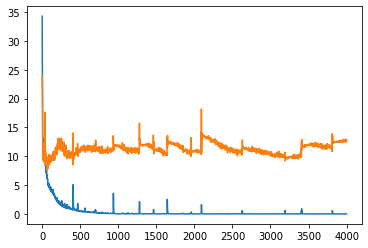

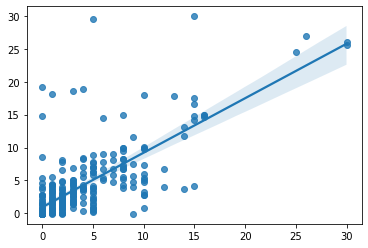

In [10]:
test(model_2, EPOCHS, "flatten_1")

In [11]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=INPUT_LENGTH),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1, activation='linear')
])
print(model_3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 32)            3168      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 flatten_2 (Flatten)         (None, 32)                0         
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 128)               4224      
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 15,841
Trainable params: 15,841
Non-trai

10/10 [==============================] - 1s 10ms/step
RNN Score: 0.6142815342732075
10/10 [==============================] - 0s 8ms/step


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,-0.06,0.09,-0.60,0.07,-0.07,-0.05,0.06,-0.04,0.06,-0.11,...,-0.05,-0.06,0.06,-0.05,0.03,-0.08,0.04,0.05,0.04,-0.06
1,-0.06,0.10,-0.61,0.08,-0.07,-0.05,0.07,-0.04,0.06,-0.10,...,-0.05,-0.06,0.06,-0.05,0.03,-0.08,0.04,0.05,0.05,-0.06
2,-0.06,0.09,-0.60,0.07,-0.07,-0.05,0.06,-0.04,0.06,-0.11,...,-0.05,-0.06,0.06,-0.05,0.03,-0.08,0.04,0.05,0.04,-0.06
3,0.06,-0.10,-0.71,-0.08,0.04,0.04,-0.05,0.04,-0.06,0.07,...,0.04,0.05,-0.06,0.07,-0.03,0.10,-0.03,-0.05,-0.04,0.03
4,0.13,-0.20,-0.76,-0.16,0.09,0.09,-0.12,0.09,-0.13,0.16,...,0.10,0.12,-0.12,0.14,-0.06,0.17,-0.08,-0.10,-0.10,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,-0.03,0.05,-0.63,0.03,-0.02,-0.02,0.04,-0.02,0.02,-0.05,...,-0.03,-0.03,0.03,-0.01,0.02,-0.04,0.02,0.02,0.02,-0.02
1265,-0.04,0.07,-0.57,0.04,-0.04,-0.03,0.05,-0.03,0.04,-0.08,...,-0.04,-0.05,0.04,-0.02,0.02,-0.06,0.03,0.04,0.03,-0.04
1266,-0.05,0.08,-0.63,0.06,-0.03,-0.03,0.06,-0.03,0.04,-0.08,...,-0.04,-0.04,0.04,-0.03,0.02,-0.06,0.03,0.04,0.03,-0.04
1267,0.04,0.03,-0.54,-0.02,-0.00,0.01,-0.01,0.02,-0.02,0.09,...,-0.01,0.03,0.00,0.04,-0.02,0.07,-0.01,-0.03,-0.00,0.02


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,-0.06,0.09,-0.59,0.07,-0.06,-0.05,0.06,-0.04,0.06,-0.10,...,-0.05,-0.06,0.05,-0.04,0.03,-0.08,0.04,0.05,0.04,-0.05
1,0.02,-0.03,-0.50,-0.05,0.02,0.02,-0.02,0.02,-0.03,0.02,...,0.01,0.02,-0.02,0.03,-0.02,0.03,-0.01,-0.01,-0.02,0.02
2,-0.05,0.07,-0.58,0.05,-0.04,-0.03,0.05,-0.03,0.04,-0.08,...,-0.04,-0.04,0.04,-0.03,0.02,-0.06,0.03,0.04,0.03,-0.04
3,-0.01,0.01,-0.66,-0.00,0.00,0.00,0.01,-0.00,-0.00,-0.01,...,-0.00,0.00,-0.00,0.01,0.00,-0.00,0.00,-0.00,0.00,-0.00
4,0.20,-0.27,-0.81,-0.20,0.14,0.13,-0.19,0.12,-0.19,0.29,...,0.15,0.17,-0.18,0.22,-0.09,0.31,-0.12,-0.16,-0.14,0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,0.27,-0.38,-0.13,-0.33,0.27,0.21,-0.26,0.17,-0.26,0.46,...,0.21,0.23,-0.23,0.27,-0.15,0.36,-0.21,-0.20,-0.17,0.20
314,-0.06,0.09,-0.59,0.08,-0.07,-0.05,0.06,-0.04,0.06,-0.10,...,-0.05,-0.06,0.05,-0.04,0.03,-0.08,0.04,0.05,0.04,-0.06
315,-0.06,0.09,-0.61,0.08,-0.06,-0.05,0.07,-0.04,0.06,-0.10,...,-0.05,-0.06,0.06,-0.05,0.03,-0.08,0.04,0.05,0.04,-0.06
316,-0.01,0.03,-0.63,-0.01,0.00,0.00,0.01,-0.00,-0.00,-0.02,...,-0.01,-0.00,0.01,0.01,0.00,-0.02,0.00,0.01,-0.00,-0.00


  2%|██                                                                                  | 1/42 [00:00<00:20,  1.95it/s]

AdaBoostRegressor (StandardScaler) 0.6063100255728128



  5%|████                                                                                | 2/42 [00:00<00:14,  2.85it/s]

BaggingRegressor (StandardScaler) 0.6013681617496727



 14%|████████████                                                                        | 6/42 [00:01<00:05,  6.16it/s]

BayesianRidge (StandardScaler) 0.6017893860935284
DecisionTreeRegressor (StandardScaler) 0.6174619839227592
DummyRegressor (StandardScaler) -0.00010814299313310904
ElasticNet (StandardScaler) 0.5513091549140222



 19%|████████████████                                                                    | 8/42 [00:01<00:07,  4.81it/s]

ElasticNetCV (StandardScaler) 0.5982342739273918
ExtraTreeRegressor (StandardScaler) 0.5716277727271308



 21%|██████████████████                                                                  | 9/42 [00:02<00:08,  3.82it/s]

ExtraTreesRegressor (StandardScaler) 0.5963563451886686
GammaRegressor (StandardScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 26%|█████████████████████▋                                                             | 11/42 [00:03<00:09,  3.35it/s]

GaussianProcessRegressor (StandardScaler) 0.47177257163024644



 29%|███████████████████████▋                                                           | 12/42 [00:04<00:18,  1.61it/s]

GradientBoostingRegressor (StandardScaler) 0.6066279432134898



 31%|█████████████████████████▋                                                         | 13/42 [00:05<00:18,  1.59it/s]

HistGradientBoostingRegressor (StandardScaler) 0.5967604322710272



 33%|███████████████████████████▋                                                       | 14/42 [00:05<00:15,  1.84it/s]

HuberRegressor (StandardScaler) 0.6035513976603213
KNeighborsRegressor (StandardScaler) 0.6096752436596813
KernelRidge (StandardScaler) 0.6009020847676644



 43%|███████████████████████████████████▌                                               | 18/42 [00:06<00:06,  3.94it/s]

Lars (StandardScaler) -6174.436445552859
LarsCV (StandardScaler) 0.6423444032046531
Lasso (StandardScaler) -0.00010814299313310904



 52%|███████████████████████████████████████████▍                                       | 22/42 [00:06<00:04,  4.94it/s]

LassoCV (StandardScaler) 0.5984891505605778
LassoLars (StandardScaler) -0.00010814299313310904
LassoLarsCV (StandardScaler) 0.6017835197475713
LassoLarsIC (StandardScaler) 0.6016430946892883
LinearRegression (StandardScaler) 0.60192859855819



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:07<00:02,  6.04it/s]

LinearSVR (StandardScaler) 0.5983373926715418



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:07<00:04,  3.93it/s]

MLPRegressor (StandardScaler) 0.5794880806201592



 69%|█████████████████████████████████████████████████████████▎                         | 29/42 [00:08<00:02,  5.13it/s]

NuSVR (StandardScaler) 0.6251726518868445
OrthogonalMatchingPursuit (StandardScaler) 0.5958665208265703
OrthogonalMatchingPursuitCV (StandardScaler) 0.5976544890377111
PassiveAggressiveRegressor (StandardScaler) 0.600315214508478
PoissonRegressor (StandardScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.



 76%|███████████████████████████████████████████████████████████████▏                   | 32/42 [00:08<00:01,  6.26it/s]

RANSACRegressor (StandardScaler) 0.5989041189776823



 79%|█████████████████████████████████████████████████████████████████▏                 | 33/42 [00:10<00:04,  2.16it/s]

RandomForestRegressor (StandardScaler) 0.6033874373479924
Ridge (StandardScaler) 0.6009002232024261



 90%|███████████████████████████████████████████████████████████████████████████        | 38/42 [00:10<00:00,  4.47it/s]

RidgeCV (StandardScaler) 0.6018273131919231
SGDRegressor (StandardScaler) 0.5999502394385487
SVR (StandardScaler) 0.6177831964788045
TransformedTargetRegressor (StandardScaler) 0.60192859855819
TweedieRegressor (StandardScaler) 0.6114000971273746



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:12<00:00,  3.81it/s]

XGBRegressor (StandardScaler) 0.6083971886573327
LGBMRegressor (StandardScaler) 0.6064312064460048
Learning rate set to 0.042513
0:	learn: 0.9620008	total: 23.9ms	remaining: 23.9s
1:	learn: 0.9256369	total: 26.9ms	remaining: 13.4s
2:	learn: 0.8910178	total: 29.6ms	remaining: 9.83s
3:	learn: 0.8571928	total: 33.7ms	remaining: 8.38s
4:	learn: 0.8256701	total: 38.5ms	remaining: 7.66s
5:	learn: 0.7946675	total: 42.7ms	remaining: 7.08s
6:	learn: 0.7653241	total: 45.4ms	remaining: 6.44s
7:	learn: 0.7371764	total: 48.7ms	remaining: 6.04s
8:	learn: 0.7096655	total: 52.7ms	remaining: 5.8s
9:	learn: 0.6831884	total: 56.9ms	remaining: 5.63s
10:	learn: 0.6584378	total: 60.2ms	remaining: 5.42s
11:	learn: 0.6338015	total: 64.9ms	remaining: 5.34s
12:	learn: 0.6101958	total: 67.9ms	remaining: 5.16s
13:	learn: 0.5873754	total: 73.1ms	remaining: 5.15s
14:	learn: 0.5658007	total: 77.5ms	remaining: 5.09s
15:	learn: 0.5451885	total: 82.4ms	remaining: 5.07s
16:	learn: 0.5255783	total: 86.9ms	remaining: 5.02

184:	learn: 0.0423221	total: 577ms	remaining: 2.54s
185:	learn: 0.0422710	total: 579ms	remaining: 2.54s
186:	learn: 0.0422212	total: 582ms	remaining: 2.53s
187:	learn: 0.0421397	total: 584ms	remaining: 2.52s
188:	learn: 0.0420777	total: 587ms	remaining: 2.52s
189:	learn: 0.0419582	total: 589ms	remaining: 2.51s
190:	learn: 0.0418783	total: 592ms	remaining: 2.5s
191:	learn: 0.0418235	total: 594ms	remaining: 2.5s
192:	learn: 0.0417261	total: 597ms	remaining: 2.5s
193:	learn: 0.0416574	total: 599ms	remaining: 2.49s
194:	learn: 0.0415761	total: 601ms	remaining: 2.48s
195:	learn: 0.0414971	total: 605ms	remaining: 2.48s
196:	learn: 0.0413973	total: 607ms	remaining: 2.47s
197:	learn: 0.0413401	total: 610ms	remaining: 2.47s
198:	learn: 0.0412538	total: 613ms	remaining: 2.47s
199:	learn: 0.0411676	total: 615ms	remaining: 2.46s
200:	learn: 0.0411091	total: 617ms	remaining: 2.45s
201:	learn: 0.0410241	total: 620ms	remaining: 2.45s
202:	learn: 0.0409608	total: 622ms	remaining: 2.44s
203:	learn: 0.0

404:	learn: 0.0301530	total: 1.15s	remaining: 1.69s
405:	learn: 0.0301043	total: 1.16s	remaining: 1.69s
406:	learn: 0.0300975	total: 1.16s	remaining: 1.69s
407:	learn: 0.0300623	total: 1.16s	remaining: 1.68s
408:	learn: 0.0300286	total: 1.16s	remaining: 1.68s
409:	learn: 0.0299962	total: 1.17s	remaining: 1.68s
410:	learn: 0.0299424	total: 1.17s	remaining: 1.67s
411:	learn: 0.0298824	total: 1.17s	remaining: 1.67s
412:	learn: 0.0298506	total: 1.17s	remaining: 1.67s
413:	learn: 0.0298419	total: 1.17s	remaining: 1.66s
414:	learn: 0.0298214	total: 1.18s	remaining: 1.66s
415:	learn: 0.0297301	total: 1.18s	remaining: 1.66s
416:	learn: 0.0296936	total: 1.18s	remaining: 1.65s
417:	learn: 0.0296174	total: 1.18s	remaining: 1.65s
418:	learn: 0.0296099	total: 1.19s	remaining: 1.65s
419:	learn: 0.0295777	total: 1.19s	remaining: 1.64s
420:	learn: 0.0295525	total: 1.19s	remaining: 1.64s
421:	learn: 0.0295208	total: 1.19s	remaining: 1.64s
422:	learn: 0.0294690	total: 1.2s	remaining: 1.63s
423:	learn: 0

618:	learn: 0.0230273	total: 1.73s	remaining: 1.06s
619:	learn: 0.0229997	total: 1.73s	remaining: 1.06s
620:	learn: 0.0229867	total: 1.73s	remaining: 1.06s
621:	learn: 0.0229495	total: 1.73s	remaining: 1.05s
622:	learn: 0.0229335	total: 1.74s	remaining: 1.05s
623:	learn: 0.0229240	total: 1.74s	remaining: 1.05s
624:	learn: 0.0229117	total: 1.74s	remaining: 1.04s
625:	learn: 0.0228735	total: 1.74s	remaining: 1.04s
626:	learn: 0.0228215	total: 1.75s	remaining: 1.04s
627:	learn: 0.0228049	total: 1.75s	remaining: 1.03s
628:	learn: 0.0227745	total: 1.75s	remaining: 1.03s
629:	learn: 0.0227291	total: 1.75s	remaining: 1.03s
630:	learn: 0.0226845	total: 1.75s	remaining: 1.03s
631:	learn: 0.0226690	total: 1.76s	remaining: 1.02s
632:	learn: 0.0226434	total: 1.76s	remaining: 1.02s
633:	learn: 0.0226288	total: 1.76s	remaining: 1.02s
634:	learn: 0.0226084	total: 1.76s	remaining: 1.01s
635:	learn: 0.0225812	total: 1.77s	remaining: 1.01s
636:	learn: 0.0225694	total: 1.77s	remaining: 1.01s
637:	learn: 

847:	learn: 0.0185179	total: 2.3s	remaining: 413ms
848:	learn: 0.0185126	total: 2.31s	remaining: 410ms
849:	learn: 0.0184956	total: 2.31s	remaining: 408ms
850:	learn: 0.0184858	total: 2.31s	remaining: 405ms
851:	learn: 0.0184740	total: 2.31s	remaining: 402ms
852:	learn: 0.0184546	total: 2.32s	remaining: 400ms
853:	learn: 0.0184396	total: 2.32s	remaining: 397ms
854:	learn: 0.0183977	total: 2.32s	remaining: 394ms
855:	learn: 0.0183714	total: 2.33s	remaining: 391ms
856:	learn: 0.0183449	total: 2.33s	remaining: 389ms
857:	learn: 0.0183372	total: 2.33s	remaining: 386ms
858:	learn: 0.0183237	total: 2.33s	remaining: 383ms
859:	learn: 0.0183127	total: 2.34s	remaining: 380ms
860:	learn: 0.0183018	total: 2.34s	remaining: 378ms
861:	learn: 0.0182838	total: 2.34s	remaining: 375ms
862:	learn: 0.0182817	total: 2.35s	remaining: 373ms
863:	learn: 0.0182644	total: 2.35s	remaining: 370ms
864:	learn: 0.0182471	total: 2.35s	remaining: 367ms
865:	learn: 0.0182371	total: 2.35s	remaining: 364ms
866:	learn: 0


 17%|██████████████▏                                                                      | 1/6 [00:14<01:14, 14.99s/it]

995:	learn: 0.0165028	total: 2.68s	remaining: 10.8ms
996:	learn: 0.0165004	total: 2.69s	remaining: 8.09ms
997:	learn: 0.0164972	total: 2.69s	remaining: 5.39ms
998:	learn: 0.0164791	total: 2.69s	remaining: 2.69ms
999:	learn: 0.0164767	total: 2.69s	remaining: 0us
CatBoostRegressor (StandardScaler) 0.5931620951319538



  5%|████                                                                                | 2/42 [00:00<00:15,  2.56it/s]

AdaBoostRegressor (MinMaxScaler) 0.6038178274429077
BaggingRegressor (MinMaxScaler) 0.6000513970742278



 12%|██████████                                                                          | 5/42 [00:01<00:08,  4.42it/s]

BayesianRidge (MinMaxScaler) 0.6018116318239923
DecisionTreeRegressor (MinMaxScaler) 0.5766325900196744
DummyRegressor (MinMaxScaler) -0.000108142993132887
ElasticNet (MinMaxScaler) -0.00010814289571348112



 17%|██████████████                                                                      | 7/42 [00:01<00:07,  4.85it/s]

ElasticNetCV (MinMaxScaler) 0.5991287579448283
ExtraTreeRegressor (MinMaxScaler) 0.6014520770333258



 21%|██████████████████                                                                  | 9/42 [00:02<00:07,  4.66it/s]

ExtraTreesRegressor (MinMaxScaler) 0.6005406085215229
GammaRegressor (MinMaxScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 26%|█████████████████████▋                                                             | 11/42 [00:03<00:08,  3.83it/s]

GaussianProcessRegressor (MinMaxScaler) -13.824996087151534



 29%|███████████████████████▋                                                           | 12/42 [00:04<00:17,  1.76it/s]

GradientBoostingRegressor (MinMaxScaler) 0.6102958937082379



 31%|█████████████████████████▋                                                         | 13/42 [00:05<00:16,  1.71it/s]

HistGradientBoostingRegressor (MinMaxScaler) 0.5961274729314756



 38%|███████████████████████████████▌                                                   | 16/42 [00:05<00:08,  2.92it/s]

HuberRegressor (MinMaxScaler) 0.598451828032093
KNeighborsRegressor (MinMaxScaler) 0.6113919904215388
KernelRidge (MinMaxScaler) 0.5992566740981449



 43%|███████████████████████████████████▌                                               | 18/42 [00:06<00:05,  4.10it/s]

Lars (MinMaxScaler) -50.17535805214783
LarsCV (MinMaxScaler) 0.6246592645142732
Lasso (MinMaxScaler) -0.00010814289571348112



 52%|███████████████████████████████████████████▍                                       | 22/42 [00:06<00:03,  5.61it/s]

LassoCV (MinMaxScaler) 0.5990546033872024
LassoLars (MinMaxScaler) -0.00010814289571348112
LassoLarsCV (MinMaxScaler) 0.6020530048224273
LassoLarsIC (MinMaxScaler) 0.6019631913197591
LinearRegression (MinMaxScaler) 0.6019290676519289



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:06<00:02,  6.61it/s]

LinearSVR (MinMaxScaler) 0.6051140259548946



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:07<00:03,  4.54it/s]

MLPRegressor (MinMaxScaler) 0.6006648238914825



 69%|█████████████████████████████████████████████████████████▎                         | 29/42 [00:07<00:02,  5.42it/s]

NuSVR (MinMaxScaler) 0.6015504461874381
OrthogonalMatchingPursuit (MinMaxScaler) 0.5998815379258722
OrthogonalMatchingPursuitCV (MinMaxScaler) 0.6003025106736384


PassiveAggressiveRegressor (MinMaxScaler) 0.36092665537086177



 74%|█████████████████████████████████████████████████████████████▎                     | 31/42 [00:08<00:02,  4.05it/s]

PoissonRegressor (MinMaxScaler) 0.11260543656171496



 76%|███████████████████████████████████████████████████████████████▏                   | 32/42 [00:09<00:02,  3.95it/s]

RANSACRegressor (MinMaxScaler) 0.5928293795658218



 79%|█████████████████████████████████████████████████████████████████▏                 | 33/42 [00:10<00:05,  1.78it/s]

RandomForestRegressor (MinMaxScaler) 0.6005822947877553
Ridge (MinMaxScaler) 0.59980608942637



 83%|█████████████████████████████████████████████████████████████████████▏             | 35/42 [00:10<00:02,  2.55it/s]

RidgeCV (MinMaxScaler) 0.5990444902388937
SGDRegressor (MinMaxScaler) 0.5986176831380283
SVR (MinMaxScaler) 0.40923207852174004
TransformedTargetRegressor (MinMaxScaler) 0.6019290676519289



 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [00:11<00:00,  3.91it/s]

TweedieRegressor (MinMaxScaler) 0.5016757964371122
XGBRegressor (MinMaxScaler) 0.6038440938894633



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:11<00:00,  4.27it/s]

LGBMRegressor (MinMaxScaler) 0.5965131308953764
Learning rate set to 0.042513
0:	learn: 0.1401354	total: 7.78ms	remaining: 7.77s
1:	learn: 0.1348385	total: 10.3ms	remaining: 5.16s
2:	learn: 0.1297955	total: 17.5ms	remaining: 5.8s
3:	learn: 0.1248681	total: 21.8ms	remaining: 5.42s
4:	learn: 0.1202762	total: 25.1ms	remaining: 4.99s
5:	learn: 0.1157600	total: 29.3ms	remaining: 4.86s
6:	learn: 0.1114855	total: 32.5ms	remaining: 4.61s
7:	learn: 0.1073852	total: 35.2ms	remaining: 4.37s
8:	learn: 0.1033777	total: 39.3ms	remaining: 4.33s
9:	learn: 0.0995208	total: 45.1ms	remaining: 4.47s
10:	learn: 0.0959153	total: 48.8ms	remaining: 4.39s
11:	learn: 0.0923265	total: 51.5ms	remaining: 4.24s
12:	learn: 0.0888879	total: 55.8ms	remaining: 4.23s
13:	learn: 0.0855636	total: 59.3ms	remaining: 4.18s
14:	learn: 0.0824208	total: 63.4ms	remaining: 4.16s
15:	learn: 0.0794182	total: 67ms	remaining: 4.12s
16:	learn: 0.0765616	total: 71.2ms	remaining: 4.12s
17:	learn: 0.0737723	total: 74.9ms	remaining: 4.08s

185:	learn: 0.0061592	total: 546ms	remaining: 2.39s
186:	learn: 0.0061519	total: 550ms	remaining: 2.39s
187:	learn: 0.0061400	total: 553ms	remaining: 2.39s
188:	learn: 0.0061310	total: 555ms	remaining: 2.38s
189:	learn: 0.0061136	total: 560ms	remaining: 2.38s
190:	learn: 0.0061020	total: 563ms	remaining: 2.38s
191:	learn: 0.0060940	total: 565ms	remaining: 2.38s
192:	learn: 0.0060798	total: 568ms	remaining: 2.38s
193:	learn: 0.0060698	total: 570ms	remaining: 2.37s
194:	learn: 0.0060580	total: 573ms	remaining: 2.36s
195:	learn: 0.0060465	total: 576ms	remaining: 2.36s
196:	learn: 0.0060319	total: 579ms	remaining: 2.36s
197:	learn: 0.0060236	total: 581ms	remaining: 2.35s
198:	learn: 0.0060110	total: 584ms	remaining: 2.35s
199:	learn: 0.0059985	total: 587ms	remaining: 2.35s
200:	learn: 0.0059899	total: 589ms	remaining: 2.34s
201:	learn: 0.0059776	total: 593ms	remaining: 2.34s
202:	learn: 0.0059684	total: 595ms	remaining: 2.34s
203:	learn: 0.0059584	total: 598ms	remaining: 2.33s
204:	learn: 

409:	learn: 0.0043807	total: 1.12s	remaining: 1.61s
410:	learn: 0.0043798	total: 1.12s	remaining: 1.61s
411:	learn: 0.0043731	total: 1.13s	remaining: 1.61s
412:	learn: 0.0043684	total: 1.13s	remaining: 1.61s
413:	learn: 0.0043672	total: 1.13s	remaining: 1.6s
414:	learn: 0.0043555	total: 1.13s	remaining: 1.6s
415:	learn: 0.0043435	total: 1.14s	remaining: 1.6s
416:	learn: 0.0043350	total: 1.14s	remaining: 1.59s
417:	learn: 0.0043304	total: 1.14s	remaining: 1.59s
418:	learn: 0.0043286	total: 1.14s	remaining: 1.59s
419:	learn: 0.0043170	total: 1.15s	remaining: 1.58s
420:	learn: 0.0043108	total: 1.15s	remaining: 1.58s
421:	learn: 0.0043042	total: 1.15s	remaining: 1.58s
422:	learn: 0.0043025	total: 1.15s	remaining: 1.57s
423:	learn: 0.0042979	total: 1.16s	remaining: 1.57s
424:	learn: 0.0042866	total: 1.16s	remaining: 1.57s
425:	learn: 0.0042799	total: 1.16s	remaining: 1.57s
426:	learn: 0.0042705	total: 1.17s	remaining: 1.56s
427:	learn: 0.0042651	total: 1.17s	remaining: 1.56s
428:	learn: 0.0

629:	learn: 0.0033146	total: 1.71s	remaining: 1s
630:	learn: 0.0033090	total: 1.71s	remaining: 999ms
631:	learn: 0.0033076	total: 1.71s	remaining: 996ms
632:	learn: 0.0033063	total: 1.71s	remaining: 993ms
633:	learn: 0.0033050	total: 1.71s	remaining: 990ms
634:	learn: 0.0033038	total: 1.72s	remaining: 987ms
635:	learn: 0.0033017	total: 1.72s	remaining: 984ms
636:	learn: 0.0033005	total: 1.72s	remaining: 981ms
637:	learn: 0.0032993	total: 1.72s	remaining: 978ms
638:	learn: 0.0032950	total: 1.73s	remaining: 976ms
639:	learn: 0.0032910	total: 1.73s	remaining: 972ms
640:	learn: 0.0032899	total: 1.73s	remaining: 969ms
641:	learn: 0.0032888	total: 1.73s	remaining: 966ms
642:	learn: 0.0032876	total: 1.73s	remaining: 962ms
643:	learn: 0.0032866	total: 1.74s	remaining: 960ms
644:	learn: 0.0032810	total: 1.74s	remaining: 957ms
645:	learn: 0.0032776	total: 1.74s	remaining: 954ms
646:	learn: 0.0032768	total: 1.74s	remaining: 952ms
647:	learn: 0.0032713	total: 1.75s	remaining: 949ms
648:	learn: 0.0

858:	learn: 0.0027681	total: 2.28s	remaining: 374ms
859:	learn: 0.0027649	total: 2.28s	remaining: 372ms
860:	learn: 0.0027631	total: 2.29s	remaining: 369ms
861:	learn: 0.0027597	total: 2.29s	remaining: 366ms
862:	learn: 0.0027592	total: 2.29s	remaining: 364ms
863:	learn: 0.0027588	total: 2.29s	remaining: 361ms
864:	learn: 0.0027571	total: 2.3s	remaining: 358ms
865:	learn: 0.0027558	total: 2.3s	remaining: 356ms
866:	learn: 0.0027539	total: 2.3s	remaining: 353ms
867:	learn: 0.0027530	total: 2.3s	remaining: 350ms
868:	learn: 0.0027500	total: 2.31s	remaining: 348ms
869:	learn: 0.0027460	total: 2.31s	remaining: 345ms
870:	learn: 0.0027442	total: 2.31s	remaining: 342ms
871:	learn: 0.0027421	total: 2.31s	remaining: 340ms
872:	learn: 0.0027366	total: 2.32s	remaining: 337ms
873:	learn: 0.0027353	total: 2.32s	remaining: 334ms
874:	learn: 0.0027324	total: 2.32s	remaining: 332ms
875:	learn: 0.0027320	total: 2.32s	remaining: 329ms
876:	learn: 0.0027303	total: 2.33s	remaining: 326ms
877:	learn: 0.00


 33%|████████████████████████████▎                                                        | 2/6 [00:29<00:59, 14.85s/it]

CatBoostRegressor (MinMaxScaler) 0.594403735667055



  2%|██                                                                                  | 1/42 [00:00<00:27,  1.51it/s]

AdaBoostRegressor (MaxAbsScaler) 0.5978285938043773
BaggingRegressor (MaxAbsScaler) 0.6008852429158184



 14%|████████████                                                                        | 6/42 [00:01<00:06,  5.47it/s]

BayesianRidge (MaxAbsScaler) 0.6018107926460352
DecisionTreeRegressor (MaxAbsScaler) 0.6034390524521421
DummyRegressor (MaxAbsScaler) -0.000108142993132887
ElasticNet (MaxAbsScaler) -0.00010814289571348112



 19%|████████████████                                                                    | 8/42 [00:01<00:06,  5.48it/s]

ElasticNetCV (MaxAbsScaler) 0.5994984030181556
ExtraTreeRegressor (MaxAbsScaler) 0.5918004914841046



 21%|██████████████████                                                                  | 9/42 [00:02<00:07,  4.25it/s]

ExtraTreesRegressor (MaxAbsScaler) 0.6044763877907882
GammaRegressor (MaxAbsScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 26%|█████████████████████▋                                                             | 11/42 [00:03<00:08,  3.63it/s]

GaussianProcessRegressor (MaxAbsScaler) -20.642931134938095



 29%|███████████████████████▋                                                           | 12/42 [00:04<00:17,  1.69it/s]

GradientBoostingRegressor (MaxAbsScaler) 0.6158284035796442



 31%|█████████████████████████▋                                                         | 13/42 [00:05<00:17,  1.65it/s]

HistGradientBoostingRegressor (MaxAbsScaler) 0.5961274729314756



 33%|███████████████████████████▋                                                       | 14/42 [00:05<00:14,  1.92it/s]

HuberRegressor (MaxAbsScaler) 0.5996352743489481
KNeighborsRegressor (MaxAbsScaler) 0.6086610599290792



 43%|███████████████████████████████████▌                                               | 18/42 [00:06<00:05,  4.06it/s]

KernelRidge (MaxAbsScaler) 0.5642542455696453
Lars (MaxAbsScaler) -1466.8486917784455
LarsCV (MaxAbsScaler) 0.6099860371639105
Lasso (MaxAbsScaler) -0.00010814289571348112



 52%|███████████████████████████████████████████▍                                       | 22/42 [00:06<00:03,  5.30it/s]

LassoCV (MaxAbsScaler) 0.5994066806055947
LassoLars (MaxAbsScaler) -0.00010814289571348112
LassoLarsCV (MaxAbsScaler) 0.6022479481336833


LassoLarsIC (MaxAbsScaler) 0.6018577249441036
LinearRegression (MaxAbsScaler) 0.6019289237340327



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:07<00:02,  6.39it/s]

LinearSVR (MaxAbsScaler) 0.6039232111587092



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:07<00:03,  4.45it/s]

MLPRegressor (MaxAbsScaler) 0.5941221413090441



 69%|█████████████████████████████████████████████████████████▎                         | 29/42 [00:08<00:02,  5.09it/s]

NuSVR (MaxAbsScaler) 0.6054793631264248
OrthogonalMatchingPursuit (MaxAbsScaler) 0.5998813641847718
OrthogonalMatchingPursuitCV (MaxAbsScaler) 0.6062257691016707


PassiveAggressiveRegressor (MaxAbsScaler) 0.5810731600677037



 74%|█████████████████████████████████████████████████████████████▎                     | 31/42 [00:08<00:02,  4.96it/s]

PoissonRegressor (MaxAbsScaler) 0.14571697084738322



 76%|███████████████████████████████████████████████████████████████▏                   | 32/42 [00:08<00:02,  4.62it/s]

RANSACRegressor (MaxAbsScaler) 0.5964593591033636



 79%|█████████████████████████████████████████████████████████████████▏                 | 33/42 [00:10<00:04,  1.88it/s]

RandomForestRegressor (MaxAbsScaler) 0.603205312405168
Ridge (MaxAbsScaler) 0.5998245923624653



 90%|███████████████████████████████████████████████████████████████████████████        | 38/42 [00:10<00:00,  4.37it/s]

RidgeCV (MaxAbsScaler) 0.5992652472738329
SGDRegressor (MaxAbsScaler) 0.5917440973199355
SVR (MaxAbsScaler) 0.3287800300329262
TransformedTargetRegressor (MaxAbsScaler) 0.6019289237340327


TweedieRegressor (MaxAbsScaler) 0.5487283154936924
XGBRegressor (MaxAbsScaler) 0.6038440938894633


 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:11<00:00,  4.37it/s]

LGBMRegressor (MaxAbsScaler) 0.6151943216476774
Learning rate set to 0.042513
0:	learn: 0.1401354	total: 7.61ms	remaining: 7.6s
1:	learn: 0.1348383	total: 10.4ms	remaining: 5.2s
2:	learn: 0.1297953	total: 13.4ms	remaining: 4.45s
3:	learn: 0.1248680	total: 17.6ms	remaining: 4.38s
4:	learn: 0.1202760	total: 21.3ms	remaining: 4.24s
5:	learn: 0.1157599	total: 25.9ms	remaining: 4.29s
6:	learn: 0.1114854	total: 29.9ms	remaining: 4.24s
7:	learn: 0.1073851	total: 33.7ms	remaining: 4.18s
8:	learn: 0.1033775	total: 37ms	remaining: 4.07s
9:	learn: 0.0995206	total: 40.3ms	remaining: 3.99s
10:	learn: 0.0959152	total: 43.8ms	remaining: 3.94s
11:	learn: 0.0923264	total: 47.4ms	remaining: 3.9s
12:	learn: 0.0888877	total: 51.5ms	remaining: 3.91s
13:	learn: 0.0855634	total: 54.2ms	remaining: 3.81s
14:	learn: 0.0824206	total: 57.4ms	remaining: 3.77s
15:	learn: 0.0794180	total: 61.6ms	remaining: 3.79s
16:	learn: 0.0765614	total: 65.8ms	remaining: 3.81s
17:	learn: 0.0737721	total: 68.6ms	remaining: 3.74s
1

189:	learn: 0.0061121	total: 550ms	remaining: 2.34s
190:	learn: 0.0061004	total: 553ms	remaining: 2.34s
191:	learn: 0.0060925	total: 556ms	remaining: 2.34s
192:	learn: 0.0060783	total: 559ms	remaining: 2.34s
193:	learn: 0.0060683	total: 562ms	remaining: 2.33s
194:	learn: 0.0060564	total: 565ms	remaining: 2.33s
195:	learn: 0.0060449	total: 567ms	remaining: 2.32s
196:	learn: 0.0060304	total: 569ms	remaining: 2.32s
197:	learn: 0.0060220	total: 572ms	remaining: 2.32s
198:	learn: 0.0060095	total: 575ms	remaining: 2.31s
199:	learn: 0.0059969	total: 577ms	remaining: 2.31s
200:	learn: 0.0059884	total: 580ms	remaining: 2.3s
201:	learn: 0.0059760	total: 582ms	remaining: 2.3s
202:	learn: 0.0059668	total: 584ms	remaining: 2.29s
203:	learn: 0.0059569	total: 587ms	remaining: 2.29s
204:	learn: 0.0059465	total: 589ms	remaining: 2.28s
205:	learn: 0.0059393	total: 592ms	remaining: 2.28s
206:	learn: 0.0059297	total: 595ms	remaining: 2.28s
207:	learn: 0.0059209	total: 597ms	remaining: 2.27s
208:	learn: 0.

410:	learn: 0.0043617	total: 1.12s	remaining: 1.61s
411:	learn: 0.0043530	total: 1.13s	remaining: 1.61s
412:	learn: 0.0043484	total: 1.13s	remaining: 1.61s
413:	learn: 0.0043471	total: 1.13s	remaining: 1.6s
414:	learn: 0.0043441	total: 1.14s	remaining: 1.6s
415:	learn: 0.0043308	total: 1.14s	remaining: 1.6s
416:	learn: 0.0043255	total: 1.14s	remaining: 1.59s
417:	learn: 0.0043144	total: 1.14s	remaining: 1.59s
418:	learn: 0.0043133	total: 1.14s	remaining: 1.59s
419:	learn: 0.0043086	total: 1.15s	remaining: 1.58s
420:	learn: 0.0043049	total: 1.15s	remaining: 1.58s
421:	learn: 0.0043003	total: 1.15s	remaining: 1.58s
422:	learn: 0.0042928	total: 1.16s	remaining: 1.58s
423:	learn: 0.0042883	total: 1.16s	remaining: 1.57s
424:	learn: 0.0042839	total: 1.16s	remaining: 1.57s
425:	learn: 0.0042778	total: 1.16s	remaining: 1.57s
426:	learn: 0.0042709	total: 1.17s	remaining: 1.56s
427:	learn: 0.0042674	total: 1.17s	remaining: 1.56s
428:	learn: 0.0042547	total: 1.17s	remaining: 1.56s
429:	learn: 0.0

633:	learn: 0.0032964	total: 1.7s	remaining: 981ms
634:	learn: 0.0032934	total: 1.7s	remaining: 979ms
635:	learn: 0.0032894	total: 1.71s	remaining: 976ms
636:	learn: 0.0032877	total: 1.71s	remaining: 973ms
637:	learn: 0.0032809	total: 1.71s	remaining: 971ms
638:	learn: 0.0032767	total: 1.71s	remaining: 968ms
639:	learn: 0.0032746	total: 1.72s	remaining: 965ms
640:	learn: 0.0032707	total: 1.72s	remaining: 962ms
641:	learn: 0.0032667	total: 1.72s	remaining: 960ms
642:	learn: 0.0032646	total: 1.72s	remaining: 957ms
643:	learn: 0.0032622	total: 1.73s	remaining: 954ms
644:	learn: 0.0032545	total: 1.73s	remaining: 951ms
645:	learn: 0.0032486	total: 1.73s	remaining: 949ms
646:	learn: 0.0032436	total: 1.74s	remaining: 947ms
647:	learn: 0.0032401	total: 1.74s	remaining: 944ms
648:	learn: 0.0032364	total: 1.74s	remaining: 941ms
649:	learn: 0.0032311	total: 1.74s	remaining: 939ms
650:	learn: 0.0032268	total: 1.75s	remaining: 936ms
651:	learn: 0.0032216	total: 1.75s	remaining: 933ms
652:	learn: 0.

846:	learn: 0.0027014	total: 2.27s	remaining: 411ms
847:	learn: 0.0026975	total: 2.28s	remaining: 408ms
848:	learn: 0.0026968	total: 2.28s	remaining: 406ms
849:	learn: 0.0026943	total: 2.28s	remaining: 403ms
850:	learn: 0.0026928	total: 2.29s	remaining: 400ms
851:	learn: 0.0026911	total: 2.29s	remaining: 397ms
852:	learn: 0.0026883	total: 2.29s	remaining: 395ms
853:	learn: 0.0026861	total: 2.29s	remaining: 392ms
854:	learn: 0.0026800	total: 2.29s	remaining: 389ms
855:	learn: 0.0026762	total: 2.3s	remaining: 386ms
856:	learn: 0.0026723	total: 2.3s	remaining: 384ms
857:	learn: 0.0026712	total: 2.3s	remaining: 381ms
858:	learn: 0.0026692	total: 2.3s	remaining: 378ms
859:	learn: 0.0026676	total: 2.31s	remaining: 375ms
860:	learn: 0.0026660	total: 2.31s	remaining: 373ms
861:	learn: 0.0026634	total: 2.31s	remaining: 370ms
862:	learn: 0.0026631	total: 2.31s	remaining: 367ms
863:	learn: 0.0026606	total: 2.32s	remaining: 365ms
864:	learn: 0.0026581	total: 2.32s	remaining: 362ms
865:	learn: 0.00


 50%|██████████████████████████████████████████▌                                          | 3/6 [00:44<00:44, 14.70s/it]

998:	learn: 0.0024005	total: 2.66s	remaining: 2.66ms
999:	learn: 0.0024002	total: 2.66s	remaining: 0us
CatBoostRegressor (MaxAbsScaler) 0.593155512158033



  5%|████                                                                                | 2/42 [00:00<00:02, 19.09it/s]

AdaBoostRegressor (Normalizer) 0.5214138286893705
BaggingRegressor (Normalizer) 0.5145768833849329



 10%|████████                                                                            | 4/42 [00:00<00:05,  6.34it/s]

BayesianRidge (Normalizer) -0.5071183427317998
DecisionTreeRegressor (Normalizer) 0.48039215686274517
DummyRegressor (Normalizer) -9.966805454642014e-05
ElasticNet (Normalizer) -9.966717060505559e-05



 17%|██████████████                                                                      | 7/42 [00:01<00:05,  6.26it/s]

ElasticNetCV (Normalizer) 0.3865972007569821
ExtraTreeRegressor (Normalizer) 0.5077399380804954



 21%|██████████████████                                                                  | 9/42 [00:01<00:04,  6.61it/s]

ExtraTreesRegressor (Normalizer) 0.5175687306501549
GammaRegressor (Normalizer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 26%|█████████████████████▋                                                             | 11/42 [00:01<00:04,  6.86it/s]

GaussianProcessRegressor (Normalizer) -2091.8446624229623



 29%|███████████████████████▋                                                           | 12/42 [00:02<00:07,  3.91it/s]

GradientBoostingRegressor (Normalizer) 0.5380278700015728



 31%|█████████████████████████▋                                                         | 13/42 [00:02<00:09,  2.99it/s]

HistGradientBoostingRegressor (Normalizer) 0.5642273421442368



 38%|███████████████████████████████▌                                                   | 16/42 [00:03<00:05,  4.41it/s]

HuberRegressor (Normalizer) 0.1838141761894755
KNeighborsRegressor (Normalizer) 0.4858617131062951
KernelRidge (Normalizer) 0.4240536312565194
Lars (Normalizer) -375.99429197931977



 43%|███████████████████████████████████▌                                               | 18/42 [00:03<00:04,  5.93it/s]

LarsCV (Normalizer) 0.28580552358886835
Lasso (Normalizer) -9.966717060505559e-05



 52%|███████████████████████████████████████████▍                                       | 22/42 [00:04<00:03,  6.11it/s]

LassoCV (Normalizer) 0.3957302994754134
LassoLars (Normalizer) -9.966717060505559e-05
LassoLarsCV (Normalizer) 0.11788738074796545



 57%|███████████████████████████████████████████████▍                                   | 24/42 [00:04<00:02,  7.85it/s]

LassoLarsIC (Normalizer) -0.49248253295234967
LinearRegression (Normalizer) -0.6330146660225215
LinearSVR (Normalizer) 0.25765701185564305



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:05<00:04,  3.55it/s]

MLPRegressor (Normalizer) 0.4384323696321484



 69%|█████████████████████████████████████████████████████████▎                         | 29/42 [00:05<00:02,  4.77it/s]

NuSVR (Normalizer) 0.5474824406970527
OrthogonalMatchingPursuit (Normalizer) 0.3618291821920345
OrthogonalMatchingPursuitCV (Normalizer) 0.29894263343659677
PassiveAggressiveRegressor (Normalizer) -0.649371912329122



 74%|█████████████████████████████████████████████████████████████▎                     | 31/42 [00:06<00:02,  4.17it/s]

PoissonRegressor (Normalizer) 0.09387289115318298



 76%|███████████████████████████████████████████████████████████████▏                   | 32/42 [00:06<00:02,  4.15it/s]

RANSACRegressor (Normalizer) -19.790761670199835



 79%|█████████████████████████████████████████████████████████████████▏                 | 33/42 [00:07<00:02,  3.25it/s]

RandomForestRegressor (Normalizer) 0.5519558307533539
Ridge (Normalizer) 0.4169966208429231



 88%|█████████████████████████████████████████████████████████████████████████          | 37/42 [00:07<00:00,  5.46it/s]

RidgeCV (Normalizer) 0.3883292382620721
SGDRegressor (Normalizer) 0.39407491002307293
SVR (Normalizer) 0.5439867105120539
TransformedTargetRegressor (Normalizer) -0.6330146660225215



 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [00:08<00:00,  4.51it/s]

TweedieRegressor (Normalizer) 0.13127291156339593
XGBRegressor (Normalizer) 0.52143336970306



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:08<00:00,  4.80it/s]

LGBMRegressor (Normalizer) 0.515760749481355
Learning rate set to 0.042513
0:	learn: 0.4618969	total: 3.94ms	remaining: 3.94s
1:	learn: 0.4427042	total: 7.36ms	remaining: 3.67s
2:	learn: 0.4243245	total: 10.3ms	remaining: 3.42s
3:	learn: 0.4069688	total: 14.4ms	remaining: 3.59s
4:	learn: 0.3901980	total: 17.6ms	remaining: 3.5s
5:	learn: 0.3740906	total: 21.1ms	remaining: 3.5s
6:	learn: 0.3585997	total: 25.1ms	remaining: 3.57s
7:	learn: 0.3439904	total: 28.4ms	remaining: 3.52s
8:	learn: 0.3302333	total: 32.4ms	remaining: 3.57s
9:	learn: 0.3165256	total: 35.6ms	remaining: 3.53s
10:	learn: 0.3038074	total: 39.5ms	remaining: 3.55s
11:	learn: 0.2913729	total: 42.4ms	remaining: 3.49s
12:	learn: 0.2794752	total: 46.2ms	remaining: 3.51s
13:	learn: 0.2678793	total: 49.1ms	remaining: 3.46s
14:	learn: 0.2572450	total: 52.9ms	remaining: 3.47s
15:	learn: 0.2465993	total: 55.7ms	remaining: 3.43s
16:	learn: 0.2364507	total: 59.9ms	remaining: 3.46s
17:	learn: 0.2266611	total: 64.1ms	remaining: 3.5s
18

194:	learn: 0.0066853	total: 545ms	remaining: 2.25s
195:	learn: 0.0066751	total: 550ms	remaining: 2.26s
196:	learn: 0.0066260	total: 553ms	remaining: 2.25s
197:	learn: 0.0065989	total: 555ms	remaining: 2.25s
198:	learn: 0.0065788	total: 558ms	remaining: 2.25s
199:	learn: 0.0065355	total: 561ms	remaining: 2.24s
200:	learn: 0.0065044	total: 563ms	remaining: 2.24s
201:	learn: 0.0064833	total: 566ms	remaining: 2.23s
202:	learn: 0.0064386	total: 568ms	remaining: 2.23s
203:	learn: 0.0063902	total: 571ms	remaining: 2.23s
204:	learn: 0.0063808	total: 574ms	remaining: 2.23s
205:	learn: 0.0063526	total: 577ms	remaining: 2.22s
206:	learn: 0.0063448	total: 579ms	remaining: 2.22s
207:	learn: 0.0063357	total: 583ms	remaining: 2.22s
208:	learn: 0.0063008	total: 585ms	remaining: 2.21s
209:	learn: 0.0062940	total: 586ms	remaining: 2.21s
210:	learn: 0.0062697	total: 589ms	remaining: 2.2s
211:	learn: 0.0062258	total: 592ms	remaining: 2.2s
212:	learn: 0.0062128	total: 594ms	remaining: 2.19s
213:	learn: 0.

414:	learn: 0.0030614	total: 1.12s	remaining: 1.58s
415:	learn: 0.0030543	total: 1.12s	remaining: 1.58s
416:	learn: 0.0030516	total: 1.13s	remaining: 1.57s
417:	learn: 0.0030449	total: 1.13s	remaining: 1.57s
418:	learn: 0.0030399	total: 1.13s	remaining: 1.57s
419:	learn: 0.0030248	total: 1.13s	remaining: 1.57s
420:	learn: 0.0030203	total: 1.14s	remaining: 1.56s
421:	learn: 0.0030185	total: 1.14s	remaining: 1.56s
422:	learn: 0.0030131	total: 1.14s	remaining: 1.56s
423:	learn: 0.0030089	total: 1.14s	remaining: 1.55s
424:	learn: 0.0030013	total: 1.15s	remaining: 1.55s
425:	learn: 0.0029968	total: 1.15s	remaining: 1.55s
426:	learn: 0.0029917	total: 1.15s	remaining: 1.54s
427:	learn: 0.0029895	total: 1.15s	remaining: 1.54s
428:	learn: 0.0029862	total: 1.16s	remaining: 1.54s
429:	learn: 0.0029846	total: 1.16s	remaining: 1.53s
430:	learn: 0.0029799	total: 1.16s	remaining: 1.53s
431:	learn: 0.0029786	total: 1.16s	remaining: 1.53s
432:	learn: 0.0029705	total: 1.17s	remaining: 1.53s
433:	learn: 

632:	learn: 0.0017750	total: 1.69s	remaining: 980ms
633:	learn: 0.0017690	total: 1.69s	remaining: 978ms
634:	learn: 0.0017658	total: 1.7s	remaining: 975ms
635:	learn: 0.0017607	total: 1.7s	remaining: 973ms
636:	learn: 0.0017567	total: 1.7s	remaining: 970ms
637:	learn: 0.0017540	total: 1.7s	remaining: 967ms
638:	learn: 0.0017530	total: 1.71s	remaining: 965ms
639:	learn: 0.0017500	total: 1.71s	remaining: 963ms
640:	learn: 0.0017454	total: 1.71s	remaining: 960ms
641:	learn: 0.0017431	total: 1.72s	remaining: 957ms
642:	learn: 0.0017370	total: 1.72s	remaining: 954ms
643:	learn: 0.0017311	total: 1.72s	remaining: 951ms
644:	learn: 0.0017289	total: 1.72s	remaining: 948ms
645:	learn: 0.0017220	total: 1.73s	remaining: 946ms
646:	learn: 0.0017198	total: 1.73s	remaining: 944ms
647:	learn: 0.0017184	total: 1.73s	remaining: 940ms
648:	learn: 0.0017178	total: 1.73s	remaining: 937ms
649:	learn: 0.0017142	total: 1.74s	remaining: 935ms
650:	learn: 0.0017103	total: 1.74s	remaining: 932ms
651:	learn: 0.00

860:	learn: 0.0011818	total: 2.27s	remaining: 366ms
861:	learn: 0.0011793	total: 2.27s	remaining: 363ms
862:	learn: 0.0011775	total: 2.27s	remaining: 360ms
863:	learn: 0.0011746	total: 2.27s	remaining: 358ms
864:	learn: 0.0011730	total: 2.27s	remaining: 355ms
865:	learn: 0.0011707	total: 2.28s	remaining: 352ms
866:	learn: 0.0011698	total: 2.28s	remaining: 350ms
867:	learn: 0.0011682	total: 2.28s	remaining: 347ms
868:	learn: 0.0011667	total: 2.29s	remaining: 345ms
869:	learn: 0.0011665	total: 2.29s	remaining: 342ms
870:	learn: 0.0011630	total: 2.29s	remaining: 339ms
871:	learn: 0.0011613	total: 2.29s	remaining: 337ms
872:	learn: 0.0011605	total: 2.3s	remaining: 334ms
873:	learn: 0.0011602	total: 2.3s	remaining: 331ms
874:	learn: 0.0011594	total: 2.3s	remaining: 329ms
875:	learn: 0.0011570	total: 2.3s	remaining: 326ms
876:	learn: 0.0011555	total: 2.31s	remaining: 323ms
877:	learn: 0.0011554	total: 2.31s	remaining: 321ms
878:	learn: 0.0011546	total: 2.31s	remaining: 318ms
879:	learn: 0.00


 67%|████████████████████████████████████████████████████████▋                            | 4/6 [00:55<00:27, 13.50s/it]

CatBoostRegressor (Normalizer) 0.5426836023416806



  2%|██                                                                                  | 1/42 [00:00<00:15,  2.60it/s]

AdaBoostRegressor (QuantileTransformer) 0.651106273080221



  5%|████                                                                                | 2/42 [00:00<00:15,  2.54it/s]

BaggingRegressor (QuantileTransformer) 0.6628939110493168



  7%|██████                                                                              | 3/42 [00:01<00:16,  2.30it/s]

BayesianRidge (QuantileTransformer) 0.6598303786476092



 10%|████████                                                                            | 4/42 [00:01<00:14,  2.70it/s]

DecisionTreeRegressor (QuantileTransformer) 0.6557495385960397



 12%|██████████                                                                          | 5/42 [00:01<00:11,  3.18it/s]

DummyRegressor (QuantileTransformer) -0.0002474108795342822



 14%|████████████                                                                        | 6/42 [00:02<00:11,  3.17it/s]

ElasticNet (QuantileTransformer) -0.00024740978024739846



 17%|██████████████                                                                      | 7/42 [00:02<00:14,  2.38it/s]

ElasticNetCV (QuantileTransformer) 0.6577477449641354



 19%|████████████████                                                                    | 8/42 [00:02<00:12,  2.79it/s]

ExtraTreeRegressor (QuantileTransformer) 0.6606654302250468



 21%|██████████████████                                                                  | 9/42 [00:03<00:15,  2.15it/s]

ExtraTreesRegressor (QuantileTransformer) 0.6617293626106864



 24%|███████████████████▊                                                               | 10/42 [00:03<00:12,  2.59it/s]

GammaRegressor (QuantileTransformer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 26%|█████████████████████▋                                                             | 11/42 [00:04<00:16,  1.85it/s]

GaussianProcessRegressor (QuantileTransformer) 0.3900402550803196



 29%|███████████████████████▋                                                           | 12/42 [00:06<00:28,  1.06it/s]

GradientBoostingRegressor (QuantileTransformer) 0.6588768983848774



 31%|█████████████████████████▋                                                         | 13/42 [00:07<00:26,  1.10it/s]

HistGradientBoostingRegressor (QuantileTransformer) 0.6543265433139014



 33%|███████████████████████████▋                                                       | 14/42 [00:07<00:21,  1.32it/s]

HuberRegressor (QuantileTransformer) 0.661111723615061



 36%|█████████████████████████████▋                                                     | 15/42 [00:08<00:16,  1.68it/s]

KNeighborsRegressor (QuantileTransformer) 0.6469379204820389



 38%|███████████████████████████████▌                                                   | 16/42 [00:08<00:15,  1.70it/s]

KernelRidge (QuantileTransformer) 0.6523692379013432



 40%|█████████████████████████████████▌                                                 | 17/42 [00:08<00:12,  2.07it/s]

Lars (QuantileTransformer) -12994.170484021279



 43%|███████████████████████████████████▌                                               | 18/42 [00:09<00:11,  2.04it/s]

LarsCV (QuantileTransformer) 0.15177265395775474



 45%|█████████████████████████████████████▌                                             | 19/42 [00:09<00:09,  2.44it/s]

Lasso (QuantileTransformer) -0.00024740978024739846



 48%|███████████████████████████████████████▌                                           | 20/42 [00:10<00:08,  2.46it/s]

LassoCV (QuantileTransformer) 0.6583091892246844



 50%|█████████████████████████████████████████▌                                         | 21/42 [00:10<00:07,  2.68it/s]

LassoLars (QuantileTransformer) -0.00024740978024739846



 52%|███████████████████████████████████████████▍                                       | 22/42 [00:10<00:08,  2.39it/s]

LassoLarsCV (QuantileTransformer) 0.6610989015283346



 55%|█████████████████████████████████████████████▍                                     | 23/42 [00:11<00:06,  2.73it/s]

LassoLarsIC (QuantileTransformer) 0.6599342903184668



 57%|███████████████████████████████████████████████▍                                   | 24/42 [00:11<00:06,  3.00it/s]

LinearRegression (QuantileTransformer) 0.6598425494173056



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:11<00:05,  2.90it/s]

LinearSVR (QuantileTransformer) 0.6626843278196346



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:12<00:05,  2.71it/s]

MLPRegressor (QuantileTransformer) 0.6687625567743873



 64%|█████████████████████████████████████████████████████▎                             | 27/42 [00:12<00:06,  2.35it/s]

NuSVR (QuantileTransformer) 0.6777222242928302



 67%|███████████████████████████████████████████████████████▎                           | 28/42 [00:12<00:05,  2.61it/s]

OrthogonalMatchingPursuit (QuantileTransformer) 0.6300377317895376



 69%|█████████████████████████████████████████████████████████▎                         | 29/42 [00:13<00:04,  2.84it/s]

OrthogonalMatchingPursuitCV (QuantileTransformer) 0.6432343792259186



 71%|███████████████████████████████████████████████████████████▎                       | 30/42 [00:13<00:03,  3.09it/s]

PassiveAggressiveRegressor (QuantileTransformer) 0.6353074636211484



 74%|█████████████████████████████████████████████████████████████▎                     | 31/42 [00:14<00:05,  1.97it/s]

PoissonRegressor (QuantileTransformer) 0.54652769714963



 76%|███████████████████████████████████████████████████████████████▏                   | 32/42 [00:15<00:05,  1.74it/s]

RANSACRegressor (QuantileTransformer) 0.6566691212756688



 79%|█████████████████████████████████████████████████████████████████▏                 | 33/42 [00:17<00:08,  1.02it/s]

RandomForestRegressor (QuantileTransformer) 0.6589457335864224



 81%|███████████████████████████████████████████████████████████████████▏               | 34/42 [00:17<00:06,  1.30it/s]

Ridge (QuantileTransformer) 0.6523918606993842



 83%|█████████████████████████████████████████████████████████████████████▏             | 35/42 [00:17<00:04,  1.54it/s]

RidgeCV (QuantileTransformer) 0.6591947440267198



 86%|███████████████████████████████████████████████████████████████████████▏           | 36/42 [00:17<00:03,  1.91it/s]

SGDRegressor (QuantileTransformer) 0.6403572971958394



 88%|█████████████████████████████████████████████████████████████████████████          | 37/42 [00:18<00:02,  2.29it/s]

SVR (QuantileTransformer) 0.6836157430701707



 90%|███████████████████████████████████████████████████████████████████████████        | 38/42 [00:18<00:01,  2.54it/s]

TransformedTargetRegressor (QuantileTransformer) 0.6598425494173056



 93%|█████████████████████████████████████████████████████████████████████████████      | 39/42 [00:19<00:01,  1.77it/s]

TweedieRegressor (QuantileTransformer) 0.6431695633920556



 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [00:19<00:01,  1.90it/s]

XGBRegressor (QuantileTransformer) 0.6374761938898752



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:20<00:00,  2.15it/s]

LGBMRegressor (QuantileTransformer) 0.637261980979062
Learning rate set to 0.042513
0:	learn: 0.3444108	total: 3.57ms	remaining: 3.56s
1:	learn: 0.3302756	total: 7.68ms	remaining: 3.83s
2:	learn: 0.3171579	total: 12ms	remaining: 3.97s
3:	learn: 0.3044520	total: 16ms	remaining: 3.98s
4:	learn: 0.2924582	total: 19.4ms	remaining: 3.86s
5:	learn: 0.2806011	total: 23ms	remaining: 3.81s
6:	learn: 0.2692076	total: 26.5ms	remaining: 3.76s
7:	learn: 0.2585599	total: 30.6ms	remaining: 3.8s
8:	learn: 0.2482586	total: 34.5ms	remaining: 3.79s
9:	learn: 0.2381114	total: 38.1ms	remaining: 3.77s
10:	learn: 0.2290930	total: 42.6ms	remaining: 3.83s
11:	learn: 0.2200862	total: 46.8ms	remaining: 3.85s
12:	learn: 0.2113701	total: 51.7ms	remaining: 3.92s
13:	learn: 0.2027660	total: 55.7ms	remaining: 3.92s
14:	learn: 0.1947390	total: 59.5ms	remaining: 3.91s
15:	learn: 0.1867737	total: 64.1ms	remaining: 3.94s
16:	learn: 0.1793086	total: 67.5ms	remaining: 3.9s
17:	learn: 0.1722026	total: 72ms	remaining: 3.93s


175:	learn: 0.0124949	total: 574ms	remaining: 2.69s
176:	learn: 0.0124899	total: 578ms	remaining: 2.69s
177:	learn: 0.0124479	total: 582ms	remaining: 2.69s
178:	learn: 0.0124288	total: 584ms	remaining: 2.68s
179:	learn: 0.0124200	total: 586ms	remaining: 2.67s
180:	learn: 0.0123746	total: 589ms	remaining: 2.67s
181:	learn: 0.0123337	total: 592ms	remaining: 2.66s
182:	learn: 0.0123224	total: 594ms	remaining: 2.65s
183:	learn: 0.0123085	total: 597ms	remaining: 2.65s
184:	learn: 0.0122749	total: 600ms	remaining: 2.64s
185:	learn: 0.0122449	total: 603ms	remaining: 2.64s
186:	learn: 0.0122334	total: 606ms	remaining: 2.63s
187:	learn: 0.0122043	total: 608ms	remaining: 2.63s
188:	learn: 0.0121980	total: 610ms	remaining: 2.62s
189:	learn: 0.0121727	total: 613ms	remaining: 2.61s
190:	learn: 0.0121650	total: 615ms	remaining: 2.61s
191:	learn: 0.0121611	total: 619ms	remaining: 2.6s
192:	learn: 0.0121473	total: 621ms	remaining: 2.6s
193:	learn: 0.0121411	total: 624ms	remaining: 2.59s
194:	learn: 0.

393:	learn: 0.0091216	total: 1.16s	remaining: 1.78s
394:	learn: 0.0091042	total: 1.16s	remaining: 1.77s
395:	learn: 0.0090952	total: 1.16s	remaining: 1.77s
396:	learn: 0.0090855	total: 1.16s	remaining: 1.77s
397:	learn: 0.0090674	total: 1.17s	remaining: 1.76s
398:	learn: 0.0090605	total: 1.17s	remaining: 1.76s
399:	learn: 0.0090537	total: 1.17s	remaining: 1.76s
400:	learn: 0.0090455	total: 1.17s	remaining: 1.75s
401:	learn: 0.0090304	total: 1.18s	remaining: 1.75s
402:	learn: 0.0090239	total: 1.18s	remaining: 1.75s
403:	learn: 0.0090099	total: 1.18s	remaining: 1.75s
404:	learn: 0.0089993	total: 1.19s	remaining: 1.74s
405:	learn: 0.0089860	total: 1.19s	remaining: 1.74s
406:	learn: 0.0089742	total: 1.19s	remaining: 1.74s
407:	learn: 0.0089663	total: 1.19s	remaining: 1.73s
408:	learn: 0.0089622	total: 1.2s	remaining: 1.73s
409:	learn: 0.0089550	total: 1.2s	remaining: 1.73s
410:	learn: 0.0089429	total: 1.2s	remaining: 1.72s
411:	learn: 0.0089280	total: 1.21s	remaining: 1.72s
412:	learn: 0.0

611:	learn: 0.0076713	total: 1.73s	remaining: 1.1s
612:	learn: 0.0076639	total: 1.74s	remaining: 1.1s
613:	learn: 0.0076626	total: 1.74s	remaining: 1.09s
614:	learn: 0.0076603	total: 1.74s	remaining: 1.09s
615:	learn: 0.0076560	total: 1.75s	remaining: 1.09s
616:	learn: 0.0076519	total: 1.75s	remaining: 1.08s
617:	learn: 0.0076504	total: 1.75s	remaining: 1.08s
618:	learn: 0.0076465	total: 1.75s	remaining: 1.08s
619:	learn: 0.0076462	total: 1.75s	remaining: 1.07s
620:	learn: 0.0076400	total: 1.75s	remaining: 1.07s
621:	learn: 0.0076361	total: 1.76s	remaining: 1.07s
622:	learn: 0.0076337	total: 1.76s	remaining: 1.06s
623:	learn: 0.0076291	total: 1.76s	remaining: 1.06s
624:	learn: 0.0076238	total: 1.76s	remaining: 1.06s
625:	learn: 0.0076196	total: 1.77s	remaining: 1.05s
626:	learn: 0.0076124	total: 1.77s	remaining: 1.05s
627:	learn: 0.0076046	total: 1.77s	remaining: 1.05s
628:	learn: 0.0075970	total: 1.77s	remaining: 1.05s
629:	learn: 0.0075910	total: 1.78s	remaining: 1.04s
630:	learn: 0.

833:	learn: 0.0069096	total: 2.31s	remaining: 460ms
834:	learn: 0.0069036	total: 2.31s	remaining: 457ms
835:	learn: 0.0069008	total: 2.32s	remaining: 454ms
836:	learn: 0.0068974	total: 2.32s	remaining: 451ms
837:	learn: 0.0068937	total: 2.32s	remaining: 449ms
838:	learn: 0.0068902	total: 2.32s	remaining: 446ms
839:	learn: 0.0068889	total: 2.33s	remaining: 443ms
840:	learn: 0.0068882	total: 2.33s	remaining: 440ms
841:	learn: 0.0068833	total: 2.33s	remaining: 437ms
842:	learn: 0.0068780	total: 2.33s	remaining: 434ms
843:	learn: 0.0068763	total: 2.33s	remaining: 432ms
844:	learn: 0.0068730	total: 2.34s	remaining: 429ms
845:	learn: 0.0068710	total: 2.34s	remaining: 426ms
846:	learn: 0.0068700	total: 2.34s	remaining: 423ms
847:	learn: 0.0068696	total: 2.35s	remaining: 420ms
848:	learn: 0.0068662	total: 2.35s	remaining: 418ms
849:	learn: 0.0068648	total: 2.35s	remaining: 415ms
850:	learn: 0.0068611	total: 2.35s	remaining: 412ms
851:	learn: 0.0068608	total: 2.35s	remaining: 409ms
852:	learn: 


 83%|██████████████████████████████████████████████████████████████████████▊              | 5/6 [01:19<00:17, 17.07s/it]

984:	learn: 0.0065961	total: 2.69s	remaining: 41ms
985:	learn: 0.0065943	total: 2.7s	remaining: 38.3ms
986:	learn: 0.0065922	total: 2.7s	remaining: 35.6ms
987:	learn: 0.0065913	total: 2.7s	remaining: 32.8ms
988:	learn: 0.0065881	total: 2.71s	remaining: 30.1ms
989:	learn: 0.0065849	total: 2.71s	remaining: 27.4ms
990:	learn: 0.0065826	total: 2.71s	remaining: 24.6ms
991:	learn: 0.0065809	total: 2.71s	remaining: 21.9ms
992:	learn: 0.0065808	total: 2.72s	remaining: 19.2ms
993:	learn: 0.0065797	total: 2.72s	remaining: 16.4ms
994:	learn: 0.0065780	total: 2.72s	remaining: 13.7ms
995:	learn: 0.0065753	total: 2.73s	remaining: 10.9ms
996:	learn: 0.0065728	total: 2.73s	remaining: 8.21ms
997:	learn: 0.0065715	total: 2.73s	remaining: 5.47ms
998:	learn: 0.0065685	total: 2.73s	remaining: 2.74ms
999:	learn: 0.0065674	total: 2.73s	remaining: 0us
CatBoostRegressor (QuantileTransformer) 0.6611876167812705



  2%|██                                                                                  | 1/42 [00:00<00:17,  2.33it/s]

AdaBoostRegressor (PowerTransformer) 0.6722224325497492



  5%|████                                                                                | 2/42 [00:00<00:16,  2.36it/s]

BaggingRegressor (PowerTransformer) 0.6656838259481851



  7%|██████                                                                              | 3/42 [00:01<00:22,  1.70it/s]

BayesianRidge (PowerTransformer) 0.6356649064720058



 10%|████████                                                                            | 4/42 [00:01<00:18,  2.11it/s]

DecisionTreeRegressor (PowerTransformer) 0.6485796308264398



 12%|██████████                                                                          | 5/42 [00:02<00:14,  2.48it/s]

DummyRegressor (PowerTransformer) -0.00020408658369297505



 14%|████████████                                                                        | 6/42 [00:02<00:14,  2.57it/s]

ElasticNet (PowerTransformer) 0.5432022508531633



 17%|██████████████                                                                      | 7/42 [00:03<00:16,  2.09it/s]

ElasticNetCV (PowerTransformer) 0.6469345482577702



 19%|████████████████                                                                    | 8/42 [00:03<00:14,  2.41it/s]

ExtraTreeRegressor (PowerTransformer) 0.644508653608548



 21%|██████████████████                                                                  | 9/42 [00:04<00:16,  2.03it/s]

ExtraTreesRegressor (PowerTransformer) 0.6671959186607913



 24%|███████████████████▊                                                               | 10/42 [00:04<00:13,  2.36it/s]

GammaRegressor (PowerTransformer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 26%|█████████████████████▋                                                             | 11/42 [00:05<00:17,  1.74it/s]

GaussianProcessRegressor (PowerTransformer) 0.6608851739440388



 29%|███████████████████████▋                                                           | 12/42 [00:07<00:29,  1.01it/s]

GradientBoostingRegressor (PowerTransformer) 0.6644109057247508



 31%|█████████████████████████▋                                                         | 13/42 [00:08<00:27,  1.04it/s]

HistGradientBoostingRegressor (PowerTransformer) 0.6628097539924269



 33%|███████████████████████████▋                                                       | 14/42 [00:08<00:24,  1.14it/s]

HuberRegressor (PowerTransformer) 0.6448240845568559



 36%|█████████████████████████████▋                                                     | 15/42 [00:09<00:18,  1.43it/s]

KNeighborsRegressor (PowerTransformer) 0.6592036482812242



 38%|███████████████████████████████▌                                                   | 16/42 [00:09<00:19,  1.36it/s]

KernelRidge (PowerTransformer) 0.6452333937989828



 40%|█████████████████████████████████▌                                                 | 17/42 [00:10<00:15,  1.57it/s]

Lars (PowerTransformer) -304.83753512475164



 43%|███████████████████████████████████▌                                               | 18/42 [00:10<00:14,  1.61it/s]

LarsCV (PowerTransformer) 0.6417250532710265



 45%|█████████████████████████████████████▌                                             | 19/42 [00:11<00:11,  1.92it/s]

Lasso (PowerTransformer) -0.00020408641160662988



 48%|███████████████████████████████████████▌                                           | 20/42 [00:11<00:12,  1.72it/s]

LassoCV (PowerTransformer) 0.6482428199081157



 50%|█████████████████████████████████████████▌                                         | 21/42 [00:12<00:10,  2.04it/s]

LassoLars (PowerTransformer) -0.00020408641160662988



 52%|███████████████████████████████████████████▍                                       | 22/42 [00:12<00:10,  1.90it/s]

LassoLarsCV (PowerTransformer) 0.6460299611337984



 55%|█████████████████████████████████████████████▍                                     | 23/42 [00:13<00:08,  2.17it/s]

LassoLarsIC (PowerTransformer) 0.6332323549452736



 57%|███████████████████████████████████████████████▍                                   | 24/42 [00:13<00:07,  2.41it/s]

LinearRegression (PowerTransformer) 0.6317339731693752



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:13<00:07,  2.29it/s]

LinearSVR (PowerTransformer) 0.6329917443457868



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:14<00:09,  1.76it/s]

MLPRegressor (PowerTransformer) 0.6686873113099404



 64%|█████████████████████████████████████████████████████▎                             | 27/42 [00:15<00:08,  1.86it/s]

NuSVR (PowerTransformer) 0.6803314818764665



 67%|███████████████████████████████████████████████████████▎                           | 28/42 [00:15<00:06,  2.08it/s]

OrthogonalMatchingPursuit (PowerTransformer) 0.6395498406715956



 69%|█████████████████████████████████████████████████████████▎                         | 29/42 [00:16<00:05,  2.28it/s]

OrthogonalMatchingPursuitCV (PowerTransformer) 0.6298975802324918



 71%|███████████████████████████████████████████████████████████▎                       | 30/42 [00:16<00:04,  2.52it/s]

PassiveAggressiveRegressor (PowerTransformer) 0.6695295065082788



 74%|█████████████████████████████████████████████████████████████▎                     | 31/42 [00:16<00:03,  2.77it/s]

PoissonRegressor (PowerTransformer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.



 76%|███████████████████████████████████████████████████████████████▏                   | 32/42 [00:17<00:04,  2.25it/s]

RANSACRegressor (PowerTransformer) 0.5685922699498522



 79%|█████████████████████████████████████████████████████████████████▏                 | 33/42 [00:18<00:07,  1.21it/s]

RandomForestRegressor (PowerTransformer) 0.6678213038741585



 81%|███████████████████████████████████████████████████████████████████▏               | 34/42 [00:19<00:05,  1.47it/s]

Ridge (PowerTransformer) 0.6452273730369936



 83%|█████████████████████████████████████████████████████████████████████▏             | 35/42 [00:19<00:04,  1.67it/s]

RidgeCV (PowerTransformer) 0.6399351066110259



 86%|███████████████████████████████████████████████████████████████████████▏           | 36/42 [00:19<00:03,  1.98it/s]

SGDRegressor (PowerTransformer) 0.6370500059509467



 88%|█████████████████████████████████████████████████████████████████████████          | 37/42 [00:20<00:02,  2.25it/s]

SVR (PowerTransformer) 0.6730492664079204



 90%|███████████████████████████████████████████████████████████████████████████        | 38/42 [00:20<00:01,  2.49it/s]

TransformedTargetRegressor (PowerTransformer) 0.6317339731693752



 93%|█████████████████████████████████████████████████████████████████████████████      | 39/42 [00:21<00:01,  1.88it/s]

TweedieRegressor (PowerTransformer) 0.6403562447029819



 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [00:21<00:01,  1.83it/s]

XGBRegressor (PowerTransformer) 0.6553622855678913



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:22<00:00,  1.85it/s]

LGBMRegressor (PowerTransformer) 0.6662404657654777
Learning rate set to 0.042513
0:	learn: 0.9595278	total: 6.42ms	remaining: 6.41s
1:	learn: 0.9205893	total: 11.8ms	remaining: 5.91s
2:	learn: 0.8836422	total: 60.1ms	remaining: 20s
3:	learn: 0.8481275	total: 68.4ms	remaining: 17s
4:	learn: 0.8136689	total: 103ms	remaining: 20.5s
5:	learn: 0.7814115	total: 108ms	remaining: 17.9s
6:	learn: 0.7497509	total: 114ms	remaining: 16.1s
7:	learn: 0.7203940	total: 119ms	remaining: 14.8s
8:	learn: 0.6913988	total: 124ms	remaining: 13.7s
9:	learn: 0.6639813	total: 129ms	remaining: 12.7s
10:	learn: 0.6383250	total: 134ms	remaining: 12.1s
11:	learn: 0.6124805	total: 140ms	remaining: 11.6s
12:	learn: 0.5883101	total: 145ms	remaining: 11s
13:	learn: 0.5647095	total: 160ms	remaining: 11.2s
14:	learn: 0.5427805	total: 165ms	remaining: 10.8s
15:	learn: 0.5209522	total: 168ms	remaining: 10.3s
16:	learn: 0.5001679	total: 173ms	remaining: 10s
17:	learn: 0.4805658	total: 177ms	remaining: 9.68s
18:	learn: 0.4

199:	learn: 0.0380330	total: 778ms	remaining: 3.11s
200:	learn: 0.0379948	total: 782ms	remaining: 3.11s
201:	learn: 0.0379417	total: 785ms	remaining: 3.1s
202:	learn: 0.0378787	total: 787ms	remaining: 3.09s
203:	learn: 0.0378179	total: 789ms	remaining: 3.08s
204:	learn: 0.0378063	total: 791ms	remaining: 3.07s
205:	learn: 0.0376836	total: 793ms	remaining: 3.06s
206:	learn: 0.0375730	total: 796ms	remaining: 3.05s
207:	learn: 0.0374276	total: 799ms	remaining: 3.04s
208:	learn: 0.0374010	total: 801ms	remaining: 3.03s
209:	learn: 0.0373399	total: 804ms	remaining: 3.02s
210:	learn: 0.0373195	total: 806ms	remaining: 3.01s
211:	learn: 0.0372547	total: 808ms	remaining: 3s
212:	learn: 0.0371804	total: 811ms	remaining: 2.99s
213:	learn: 0.0370788	total: 813ms	remaining: 2.99s
214:	learn: 0.0369996	total: 816ms	remaining: 2.98s
215:	learn: 0.0369488	total: 818ms	remaining: 2.97s
216:	learn: 0.0368968	total: 821ms	remaining: 2.96s
217:	learn: 0.0368681	total: 823ms	remaining: 2.95s
218:	learn: 0.03

429:	learn: 0.0297602	total: 1.35s	remaining: 1.79s
430:	learn: 0.0297582	total: 1.36s	remaining: 1.79s
431:	learn: 0.0297380	total: 1.36s	remaining: 1.79s
432:	learn: 0.0296667	total: 1.36s	remaining: 1.78s
433:	learn: 0.0296502	total: 1.36s	remaining: 1.78s
434:	learn: 0.0296104	total: 1.37s	remaining: 1.77s
435:	learn: 0.0295486	total: 1.37s	remaining: 1.77s
436:	learn: 0.0295467	total: 1.37s	remaining: 1.77s
437:	learn: 0.0295066	total: 1.37s	remaining: 1.76s
438:	learn: 0.0294904	total: 1.38s	remaining: 1.76s
439:	learn: 0.0294378	total: 1.38s	remaining: 1.76s
440:	learn: 0.0294078	total: 1.38s	remaining: 1.75s
441:	learn: 0.0293860	total: 1.39s	remaining: 1.75s
442:	learn: 0.0293557	total: 1.39s	remaining: 1.74s
443:	learn: 0.0293538	total: 1.39s	remaining: 1.74s
444:	learn: 0.0293138	total: 1.39s	remaining: 1.74s
445:	learn: 0.0292781	total: 1.4s	remaining: 1.73s
446:	learn: 0.0292591	total: 1.4s	remaining: 1.73s
447:	learn: 0.0292236	total: 1.4s	remaining: 1.73s
448:	learn: 0.0

659:	learn: 0.0249937	total: 1.93s	remaining: 993ms
660:	learn: 0.0249890	total: 1.93s	remaining: 990ms
661:	learn: 0.0249883	total: 1.93s	remaining: 987ms
662:	learn: 0.0249732	total: 1.94s	remaining: 984ms
663:	learn: 0.0249556	total: 1.94s	remaining: 981ms
664:	learn: 0.0249402	total: 1.94s	remaining: 977ms
665:	learn: 0.0249346	total: 1.94s	remaining: 974ms
666:	learn: 0.0249166	total: 1.94s	remaining: 971ms
667:	learn: 0.0249125	total: 1.95s	remaining: 968ms
668:	learn: 0.0248984	total: 1.95s	remaining: 965ms
669:	learn: 0.0248787	total: 1.95s	remaining: 961ms
670:	learn: 0.0248729	total: 1.95s	remaining: 958ms
671:	learn: 0.0248592	total: 1.96s	remaining: 955ms
672:	learn: 0.0248518	total: 1.96s	remaining: 952ms
673:	learn: 0.0248493	total: 1.96s	remaining: 949ms
674:	learn: 0.0248400	total: 1.96s	remaining: 946ms
675:	learn: 0.0248212	total: 1.97s	remaining: 943ms
676:	learn: 0.0248072	total: 1.97s	remaining: 940ms
677:	learn: 0.0247905	total: 1.97s	remaining: 936ms
678:	learn: 

885:	learn: 0.0227090	total: 2.5s	remaining: 322ms
886:	learn: 0.0227021	total: 2.5s	remaining: 319ms
887:	learn: 0.0226998	total: 2.5s	remaining: 316ms
888:	learn: 0.0226949	total: 2.51s	remaining: 313ms
889:	learn: 0.0226898	total: 2.51s	remaining: 310ms
890:	learn: 0.0226781	total: 2.51s	remaining: 307ms
891:	learn: 0.0226768	total: 2.52s	remaining: 305ms
892:	learn: 0.0226641	total: 2.52s	remaining: 302ms
893:	learn: 0.0226620	total: 2.52s	remaining: 299ms
894:	learn: 0.0226616	total: 2.52s	remaining: 296ms
895:	learn: 0.0226574	total: 2.53s	remaining: 293ms
896:	learn: 0.0226449	total: 2.53s	remaining: 291ms
897:	learn: 0.0226333	total: 2.53s	remaining: 288ms
898:	learn: 0.0226239	total: 2.53s	remaining: 285ms
899:	learn: 0.0226183	total: 2.54s	remaining: 282ms
900:	learn: 0.0226090	total: 2.54s	remaining: 279ms
901:	learn: 0.0225980	total: 2.54s	remaining: 276ms
902:	learn: 0.0225959	total: 2.54s	remaining: 273ms
903:	learn: 0.0225915	total: 2.55s	remaining: 271ms
904:	learn: 0.0


100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:45<00:00, 17.52s/it]

961:	learn: 0.0221946	total: 2.69s	remaining: 106ms
962:	learn: 0.0221855	total: 2.69s	remaining: 104ms
963:	learn: 0.0221757	total: 2.7s	remaining: 101ms
964:	learn: 0.0221663	total: 2.7s	remaining: 97.9ms
965:	learn: 0.0221599	total: 2.7s	remaining: 95.1ms
966:	learn: 0.0221551	total: 2.7s	remaining: 92.3ms
967:	learn: 0.0221496	total: 2.71s	remaining: 89.5ms
968:	learn: 0.0221394	total: 2.71s	remaining: 86.7ms
969:	learn: 0.0221314	total: 2.71s	remaining: 83.9ms
970:	learn: 0.0221260	total: 2.71s	remaining: 81.1ms
971:	learn: 0.0221205	total: 2.72s	remaining: 78.3ms
972:	learn: 0.0221097	total: 2.72s	remaining: 75.5ms
973:	learn: 0.0221081	total: 2.72s	remaining: 72.7ms
974:	learn: 0.0221037	total: 2.72s	remaining: 69.9ms
975:	learn: 0.0220993	total: 2.73s	remaining: 67.1ms
976:	learn: 0.0220892	total: 2.73s	remaining: 64.3ms
977:	learn: 0.0220792	total: 2.73s	remaining: 61.5ms
978:	learn: 0.0220771	total: 2.73s	remaining: 58.7ms
979:	learn: 0.0220691	total: 2.74s	remaining: 55.9ms


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
SVR (QuantileTransformer),0.65,0.68,0.20,0.22
NuSVR (PowerTransformer),0.64,0.68,0.56,0.47
NuSVR (QuantileTransformer),0.64,0.68,0.20,0.56
SVR (PowerTransformer),0.64,0.67,0.57,0.29
AdaBoostRegressor (PowerTransformer),0.64,0.67,0.57,0.43
PassiveAggressiveRegressor (PowerTransformer),0.63,0.67,0.57,0.29
MLPRegressor (QuantileTransformer),0.63,0.67,0.21,0.41
CatBoostRegressor (PowerTransformer),0.63,0.67,0.57,3.24
MLPRegressor (PowerTransformer),0.63,0.67,0.57,0.87


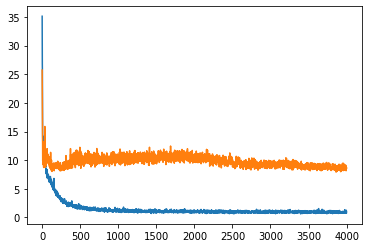

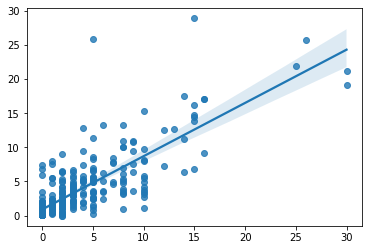

In [12]:
test(model_3, EPOCHS, "flatten_2")

In [13]:
model_4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=INPUT_LENGTH),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='linear')
])
print(model_4.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 32)            3168      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 flatten_3 (Flatten)         (None, 32)                0         
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 128)               4224      
                                                                 
 dropout_3 (Dropout)         (None, 128)              

KeyboardInterrupt: 

10/10 [==============================] - 1s 10ms/step
RNN Score: 0.6600554907366412
10/10 [==============================] - 0s 8ms/step


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.03,-0.04,0.02,0.05,-0.02,-0.03,0.02,-0.03,-0.03,0.19,...,-0.04,-0.02,0.04,-0.03,0.02,0.02,0.02,-0.02,0.03,-0.03
1,0.03,-0.04,0.03,0.05,-0.02,-0.03,0.02,-0.03,-0.04,0.21,...,-0.04,-0.02,0.04,-0.03,0.03,0.03,0.02,-0.03,0.03,-0.04
2,0.03,-0.04,0.02,0.05,-0.02,-0.03,0.02,-0.03,-0.04,0.20,...,-0.04,-0.02,0.04,-0.03,0.03,0.03,0.02,-0.02,0.03,-0.04
3,-0.02,0.03,-0.03,-0.05,0.01,0.02,-0.02,0.03,0.03,-0.09,...,0.03,0.03,-0.04,0.02,-0.02,-0.03,-0.02,0.02,-0.03,0.01
4,-0.05,0.08,-0.06,-0.10,0.04,0.06,-0.04,0.06,0.07,-0.31,...,0.05,0.06,-0.08,0.06,-0.05,-0.05,-0.05,0.04,-0.06,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,0.01,-0.02,0.01,0.02,-0.01,-0.02,0.01,-0.01,-0.02,0.12,...,-0.01,-0.01,0.01,-0.01,0.01,0.01,0.01,-0.01,0.01,-0.02
1265,0.02,-0.03,0.02,0.04,-0.02,-0.03,0.01,-0.02,-0.02,0.14,...,-0.03,-0.02,0.03,-0.02,0.02,0.02,0.02,-0.02,0.02,-0.03
1266,0.02,-0.03,0.02,0.03,-0.01,-0.03,0.01,-0.02,-0.02,0.14,...,-0.02,-0.01,0.02,-0.02,0.02,0.01,0.02,-0.02,0.02,-0.03
1267,-0.01,0.02,-0.02,-0.02,0.00,0.01,-0.01,0.00,0.00,-0.02,...,0.01,0.02,-0.02,0.01,-0.01,-0.02,-0.01,0.01,-0.02,-0.00


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.03,-0.04,0.03,0.05,-0.02,-0.03,0.02,-0.03,-0.04,0.20,...,-0.04,-0.02,0.05,-0.03,0.03,0.03,0.02,-0.03,0.03,-0.04
1,0.00,-0.00,0.00,0.00,-0.00,-0.01,0.00,-0.01,-0.00,0.04,...,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.01
2,0.02,-0.03,0.02,0.03,-0.01,-0.02,0.01,-0.02,-0.02,0.11,...,-0.02,-0.01,0.03,-0.02,0.02,0.01,0.01,-0.02,0.02,-0.03
3,0.02,-0.02,0.01,0.03,-0.01,-0.02,0.01,-0.02,-0.02,0.12,...,-0.02,-0.01,0.02,-0.01,0.01,0.01,0.01,-0.01,0.01,-0.02
4,-0.09,0.14,-0.10,-0.19,0.07,0.12,-0.07,0.11,0.13,-0.46,...,0.14,0.09,-0.14,0.10,-0.10,-0.09,-0.09,0.07,-0.09,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,-0.09,0.13,-0.11,-0.18,0.08,0.13,-0.07,0.11,0.13,-0.74,...,0.15,0.09,-0.14,0.11,-0.10,-0.09,-0.09,0.08,-0.10,0.10
314,0.03,-0.05,0.03,0.06,-0.02,-0.03,0.02,-0.03,-0.04,0.21,...,-0.04,-0.03,0.05,-0.03,0.03,0.03,0.03,-0.03,0.03,-0.04
315,0.03,-0.04,0.02,0.05,-0.02,-0.03,0.02,-0.03,-0.03,0.20,...,-0.04,-0.02,0.04,-0.03,0.02,0.02,0.02,-0.02,0.03,-0.03
316,0.00,-0.00,0.00,-0.00,-0.00,-0.01,0.00,-0.00,-0.00,0.04,...,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.01


  2%|██                                                                                  | 1/42 [00:00<00:22,  1.86it/s]

AdaBoostRegressor (StandardScaler) 0.6469462562101609



  5%|████                                                                                | 2/42 [00:00<00:14,  2.85it/s]

BaggingRegressor (StandardScaler) 0.6362483196451356



 14%|████████████                                                                        | 6/42 [00:01<00:06,  5.63it/s]

BayesianRidge (StandardScaler) 0.6357941629681798
DecisionTreeRegressor (StandardScaler) 0.6328541578602043
DummyRegressor (StandardScaler) -0.00010814299313310904
ElasticNet (StandardScaler) 0.5918619649688912



 19%|████████████████                                                                    | 8/42 [00:01<00:07,  4.85it/s]

ElasticNetCV (StandardScaler) 0.6334610230542517
ExtraTreeRegressor (StandardScaler) 0.6427851003494967



 21%|██████████████████                                                                  | 9/42 [00:02<00:08,  3.76it/s]

ExtraTreesRegressor (StandardScaler) 0.6340224065497954
GammaRegressor (StandardScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 26%|█████████████████████▋                                                             | 11/42 [00:03<00:09,  3.20it/s]

GaussianProcessRegressor (StandardScaler) -3.4277036867353647



 29%|███████████████████████▋                                                           | 12/42 [00:04<00:18,  1.66it/s]

GradientBoostingRegressor (StandardScaler) 0.6281930627544695



 31%|█████████████████████████▋                                                         | 13/42 [00:05<00:17,  1.66it/s]

HistGradientBoostingRegressor (StandardScaler) 0.6417114337954214



 33%|███████████████████████████▋                                                       | 14/42 [00:05<00:14,  1.90it/s]


HuberRegressor (StandardScaler) 0.6396865847543736
KNeighborsRegressor (StandardScaler) 0.630667147133878
KernelRidge (StandardScaler) 0.6341743465341048


 43%|███████████████████████████████████▌                                               | 18/42 [00:06<00:06,  3.99it/s]

Lars (StandardScaler) -1445324858775.7297
LarsCV (StandardScaler) -1444425595579.602
Lasso (StandardScaler) -0.00010814299313310904



 52%|███████████████████████████████████████████▍                                       | 22/42 [00:06<00:03,  5.49it/s]

LassoCV (StandardScaler) 0.6354340592407499
LassoLars (StandardScaler) -0.00010814299313310904
LassoLarsCV (StandardScaler) 0.6347542338546153



 57%|███████████████████████████████████████████████▍                                   | 24/42 [00:06<00:02,  7.16it/s]

LassoLarsIC (StandardScaler) 0.6349388861820062
LinearRegression (StandardScaler) 0.634058216517531
LinearSVR (StandardScaler) 0.6342532814377413



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:07<00:04,  3.87it/s]

MLPRegressor (StandardScaler) 0.6509550955595438



 69%|█████████████████████████████████████████████████████████▎                         | 29/42 [00:08<00:02,  5.08it/s]

NuSVR (StandardScaler) 0.6461460933015037
OrthogonalMatchingPursuit (StandardScaler) 0.6220914422641851
OrthogonalMatchingPursuitCV (StandardScaler) 0.6270985458062002



 74%|█████████████████████████████████████████████████████████████▎                     | 31/42 [00:08<00:01,  6.70it/s]

PassiveAggressiveRegressor (StandardScaler) 0.5457133579444202
PoissonRegressor (StandardScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.
RANSACRegressor (StandardScaler) 0.6406078037719498



 79%|█████████████████████████████████████████████████████████████████▏                 | 33/42 [00:10<00:04,  2.20it/s]

RandomForestRegressor (StandardScaler) 0.6340640458801672
Ridge (StandardScaler) 0.6341761004612876



 88%|█████████████████████████████████████████████████████████████████████████          | 37/42 [00:10<00:01,  3.75it/s]

RidgeCV (StandardScaler) 0.6358426402708839
SGDRegressor (StandardScaler) 0.6233005876257574
SVR (StandardScaler) 0.6383664016515848
TransformedTargetRegressor (StandardScaler) 0.634058216517531



 93%|█████████████████████████████████████████████████████████████████████████████      | 39/42 [00:11<00:00,  3.96it/s]

TweedieRegressor (StandardScaler) 0.6408281365710748



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:11<00:00,  4.04it/s]

XGBRegressor (StandardScaler) 0.6179971633707766
LGBMRegressor (StandardScaler) 0.6359103175244676
Learning rate set to 0.042513
0:	learn: 0.9630516	total: 18.9ms	remaining: 18.9s
1:	learn: 0.9267685	total: 22.7ms	remaining: 11.3s
2:	learn: 0.8922054	total: 26.1ms	remaining: 8.68s
3:	learn: 0.8582600	total: 29.5ms	remaining: 7.35s
4:	learn: 0.8256825	total: 32.6ms	remaining: 6.5s
5:	learn: 0.7946285	total: 36.6ms	remaining: 6.06s
6:	learn: 0.7650890	total: 39.5ms	remaining: 5.61s
7:	learn: 0.7365306	total: 43.4ms	remaining: 5.38s
8:	learn: 0.7086339	total: 46.4ms	remaining: 5.11s
9:	learn: 0.6828916	total: 49.1ms	remaining: 4.86s
10:	learn: 0.6582185	total: 51.9ms	remaining: 4.66s
11:	learn: 0.6340351	total: 56.6ms	remaining: 4.66s
12:	learn: 0.6112471	total: 60.8ms	remaining: 4.62s
13:	learn: 0.5886068	total: 64.6ms	remaining: 4.55s
14:	learn: 0.5672621	total: 67.4ms	remaining: 4.42s
15:	learn: 0.5466194	total: 69.7ms	remaining: 4.29s
16:	learn: 0.5269229	total: 73.6ms	remaining: 4.26

189:	learn: 0.0533251	total: 567ms	remaining: 2.42s
190:	learn: 0.0531754	total: 570ms	remaining: 2.42s
191:	learn: 0.0530483	total: 574ms	remaining: 2.41s
192:	learn: 0.0528926	total: 576ms	remaining: 2.41s
193:	learn: 0.0527804	total: 578ms	remaining: 2.4s
194:	learn: 0.0526962	total: 581ms	remaining: 2.4s
195:	learn: 0.0526583	total: 583ms	remaining: 2.39s
196:	learn: 0.0525348	total: 586ms	remaining: 2.39s
197:	learn: 0.0524816	total: 589ms	remaining: 2.38s
198:	learn: 0.0523755	total: 591ms	remaining: 2.38s
199:	learn: 0.0522930	total: 593ms	remaining: 2.37s
200:	learn: 0.0522045	total: 597ms	remaining: 2.37s
201:	learn: 0.0521289	total: 599ms	remaining: 2.37s
202:	learn: 0.0520609	total: 602ms	remaining: 2.36s
203:	learn: 0.0519974	total: 604ms	remaining: 2.36s
204:	learn: 0.0519514	total: 607ms	remaining: 2.35s
205:	learn: 0.0518140	total: 609ms	remaining: 2.35s
206:	learn: 0.0517305	total: 611ms	remaining: 2.34s
207:	learn: 0.0515848	total: 615ms	remaining: 2.34s
208:	learn: 0.

407:	learn: 0.0371686	total: 1.14s	remaining: 1.66s
408:	learn: 0.0371244	total: 1.15s	remaining: 1.66s
409:	learn: 0.0370809	total: 1.15s	remaining: 1.65s
410:	learn: 0.0370414	total: 1.15s	remaining: 1.65s
411:	learn: 0.0370297	total: 1.16s	remaining: 1.65s
412:	learn: 0.0369345	total: 1.16s	remaining: 1.65s
413:	learn: 0.0369044	total: 1.16s	remaining: 1.64s
414:	learn: 0.0368231	total: 1.16s	remaining: 1.64s
415:	learn: 0.0367632	total: 1.17s	remaining: 1.64s
416:	learn: 0.0367518	total: 1.17s	remaining: 1.64s
417:	learn: 0.0367039	total: 1.17s	remaining: 1.63s
418:	learn: 0.0366161	total: 1.18s	remaining: 1.63s
419:	learn: 0.0365381	total: 1.18s	remaining: 1.63s
420:	learn: 0.0365013	total: 1.18s	remaining: 1.62s
421:	learn: 0.0364225	total: 1.18s	remaining: 1.62s
422:	learn: 0.0363885	total: 1.19s	remaining: 1.62s
423:	learn: 0.0363502	total: 1.19s	remaining: 1.62s
424:	learn: 0.0363389	total: 1.19s	remaining: 1.61s
425:	learn: 0.0362559	total: 1.2s	remaining: 1.61s
426:	learn: 0

619:	learn: 0.0282300	total: 1.72s	remaining: 1.05s
620:	learn: 0.0282243	total: 1.72s	remaining: 1.05s
621:	learn: 0.0281779	total: 1.72s	remaining: 1.05s
622:	learn: 0.0281724	total: 1.72s	remaining: 1.04s
623:	learn: 0.0281012	total: 1.73s	remaining: 1.04s
624:	learn: 0.0280886	total: 1.73s	remaining: 1.04s
625:	learn: 0.0280707	total: 1.73s	remaining: 1.03s
626:	learn: 0.0280582	total: 1.73s	remaining: 1.03s
627:	learn: 0.0280412	total: 1.74s	remaining: 1.03s
628:	learn: 0.0280267	total: 1.74s	remaining: 1.02s
629:	learn: 0.0279702	total: 1.74s	remaining: 1.02s
630:	learn: 0.0279470	total: 1.74s	remaining: 1.02s
631:	learn: 0.0279416	total: 1.75s	remaining: 1.02s
632:	learn: 0.0279362	total: 1.75s	remaining: 1.01s
633:	learn: 0.0278929	total: 1.75s	remaining: 1.01s
634:	learn: 0.0278458	total: 1.75s	remaining: 1.01s
635:	learn: 0.0278079	total: 1.76s	remaining: 1s
636:	learn: 0.0278027	total: 1.76s	remaining: 1s
637:	learn: 0.0277976	total: 1.76s	remaining: 1s
638:	learn: 0.0277926

831:	learn: 0.0228558	total: 2.29s	remaining: 462ms
832:	learn: 0.0228506	total: 2.29s	remaining: 460ms
833:	learn: 0.0228253	total: 2.29s	remaining: 457ms
834:	learn: 0.0228162	total: 2.3s	remaining: 454ms
835:	learn: 0.0227913	total: 2.3s	remaining: 451ms
836:	learn: 0.0227440	total: 2.3s	remaining: 449ms
837:	learn: 0.0227036	total: 2.31s	remaining: 446ms
838:	learn: 0.0226985	total: 2.31s	remaining: 443ms
839:	learn: 0.0226853	total: 2.31s	remaining: 440ms
840:	learn: 0.0226652	total: 2.31s	remaining: 437ms
841:	learn: 0.0226441	total: 2.31s	remaining: 435ms
842:	learn: 0.0226176	total: 2.32s	remaining: 432ms
843:	learn: 0.0225776	total: 2.32s	remaining: 429ms
844:	learn: 0.0225509	total: 2.32s	remaining: 426ms
845:	learn: 0.0225410	total: 2.33s	remaining: 424ms
846:	learn: 0.0225257	total: 2.33s	remaining: 421ms
847:	learn: 0.0225183	total: 2.33s	remaining: 418ms
848:	learn: 0.0224840	total: 2.33s	remaining: 415ms
849:	learn: 0.0224600	total: 2.34s	remaining: 413ms
850:	learn: 0.0


 17%|██████████████▏                                                                      | 1/6 [00:14<01:14, 14.99s/it]

974:	learn: 0.0200281	total: 2.67s	remaining: 68.5ms
975:	learn: 0.0200054	total: 2.68s	remaining: 65.8ms
976:	learn: 0.0199819	total: 2.68s	remaining: 63.1ms
977:	learn: 0.0199779	total: 2.68s	remaining: 60.3ms
978:	learn: 0.0199739	total: 2.68s	remaining: 57.6ms
979:	learn: 0.0199701	total: 2.69s	remaining: 54.8ms
980:	learn: 0.0199645	total: 2.69s	remaining: 52.1ms
981:	learn: 0.0199514	total: 2.69s	remaining: 49.4ms
982:	learn: 0.0199116	total: 2.69s	remaining: 46.6ms
983:	learn: 0.0199072	total: 2.7s	remaining: 43.9ms
984:	learn: 0.0198825	total: 2.7s	remaining: 41.1ms
985:	learn: 0.0198794	total: 2.7s	remaining: 38.4ms
986:	learn: 0.0198768	total: 2.71s	remaining: 35.6ms
987:	learn: 0.0198417	total: 2.71s	remaining: 32.9ms
988:	learn: 0.0198170	total: 2.71s	remaining: 30.2ms
989:	learn: 0.0198071	total: 2.71s	remaining: 27.4ms
990:	learn: 0.0197882	total: 2.72s	remaining: 24.7ms
991:	learn: 0.0197822	total: 2.72s	remaining: 21.9ms
992:	learn: 0.0197583	total: 2.72s	remaining: 19.


  5%|████                                                                                | 2/42 [00:00<00:15,  2.64it/s]

AdaBoostRegressor (MinMaxScaler) 0.6402913066568264
BaggingRegressor (MinMaxScaler) 0.6430604652395484



 14%|████████████                                                                        | 6/42 [00:01<00:06,  5.68it/s]

BayesianRidge (MinMaxScaler) 0.6357955776064586
DecisionTreeRegressor (MinMaxScaler) 0.6337040324947872
DummyRegressor (MinMaxScaler) -0.000108142993132887
ElasticNet (MinMaxScaler) -0.00010814289571348112



 19%|████████████████                                                                    | 8/42 [00:01<00:05,  5.76it/s]

ElasticNetCV (MinMaxScaler) 0.6332633264669425
ExtraTreeRegressor (MinMaxScaler) 0.6176980602101435



 24%|███████████████████▊                                                               | 10/42 [00:02<00:06,  5.18it/s]

ExtraTreesRegressor (MinMaxScaler) 0.6338438659882522
GammaRegressor (MinMaxScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 26%|█████████████████████▋                                                             | 11/42 [00:02<00:09,  3.38it/s]

GaussianProcessRegressor (MinMaxScaler) -59.632576130837045



 29%|███████████████████████▋                                                           | 12/42 [00:04<00:17,  1.68it/s]

GradientBoostingRegressor (MinMaxScaler) 0.6368674177919849



 31%|█████████████████████████▋                                                         | 13/42 [00:05<00:17,  1.64it/s]

HistGradientBoostingRegressor (MinMaxScaler) 0.640792764598038



 33%|███████████████████████████▋                                                       | 14/42 [00:05<00:14,  1.95it/s]


HuberRegressor (MinMaxScaler) 0.6335497075078458
KNeighborsRegressor (MinMaxScaler) 0.6339589948851623
KernelRidge (MinMaxScaler) 0.6328649364600505


 43%|███████████████████████████████████▌                                               | 18/42 [00:05<00:05,  4.05it/s]

Lars (MinMaxScaler) -5038.0880180668
LarsCV (MinMaxScaler) 0.6408210822732885
Lasso (MinMaxScaler) -0.00010814289571348112



 52%|███████████████████████████████████████████▍                                       | 22/42 [00:06<00:03,  5.27it/s]

LassoCV (MinMaxScaler) 0.6352597811440448
LassoLars (MinMaxScaler) -0.00010814289571348112
LassoLarsCV (MinMaxScaler) 0.6345489048918465
LassoLarsIC (MinMaxScaler) 0.6365011202714087
LinearRegression (MinMaxScaler) 0.634054008177409



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:06<00:02,  6.24it/s]

LinearSVR (MinMaxScaler) 0.6429577201879159



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:07<00:03,  4.31it/s]

MLPRegressor (MinMaxScaler) 0.621229076466419



 69%|█████████████████████████████████████████████████████████▎                         | 29/42 [00:07<00:02,  5.41it/s]

NuSVR (MinMaxScaler) 0.6359348308651196
OrthogonalMatchingPursuit (MinMaxScaler) 0.6419776196233205
OrthogonalMatchingPursuitCV (MinMaxScaler) 0.6335485208254132


PassiveAggressiveRegressor (MinMaxScaler) 0.45832810268178237



 74%|█████████████████████████████████████████████████████████████▎                     | 31/42 [00:08<00:02,  4.34it/s]

PoissonRegressor (MinMaxScaler) 0.14199253575397963



 76%|███████████████████████████████████████████████████████████████▏                   | 32/42 [00:08<00:02,  4.14it/s]

RANSACRegressor (MinMaxScaler) 0.6046747577866716



 79%|█████████████████████████████████████████████████████████████████▏                 | 33/42 [00:10<00:04,  1.81it/s]

RandomForestRegressor (MinMaxScaler) 0.6348300690118445
Ridge (MinMaxScaler) 0.629578068719096



 88%|█████████████████████████████████████████████████████████████████████████          | 37/42 [00:10<00:01,  3.56it/s]

RidgeCV (MinMaxScaler) 0.6325891851252108
SGDRegressor (MinMaxScaler) 0.6286663116669688
SVR (MinMaxScaler) 0.4188971164346449
TransformedTargetRegressor (MinMaxScaler) 0.634054008177409



 93%|█████████████████████████████████████████████████████████████████████████████      | 39/42 [00:11<00:00,  3.39it/s]

TweedieRegressor (MinMaxScaler) 0.5677095324680845
XGBRegressor (MinMaxScaler) 0.6148537868282815



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:11<00:00,  4.03it/s]

LGBMRegressor (MinMaxScaler) 0.6350062873591438
Learning rate set to 0.042513
0:	learn: 0.1402885	total: 5.43ms	remaining: 5.43s
1:	learn: 0.1350031	total: 8.18ms	remaining: 4.08s
2:	learn: 0.1299683	total: 11.6ms	remaining: 3.86s
3:	learn: 0.1250234	total: 14.8ms	remaining: 3.68s
4:	learn: 0.1202778	total: 18.6ms	remaining: 3.7s
5:	learn: 0.1157542	total: 21.6ms	remaining: 3.59s
6:	learn: 0.1114511	total: 25ms	remaining: 3.55s
7:	learn: 0.1072910	total: 27.7ms	remaining: 3.44s
8:	learn: 0.1032273	total: 30.2ms	remaining: 3.33s
9:	learn: 0.0994774	total: 32.5ms	remaining: 3.22s
10:	learn: 0.0958832	total: 36.3ms	remaining: 3.27s
11:	learn: 0.0923604	total: 39.7ms	remaining: 3.27s
12:	learn: 0.0890409	total: 44ms	remaining: 3.34s
13:	learn: 0.0857428	total: 46.5ms	remaining: 3.28s
14:	learn: 0.0826335	total: 49.3ms	remaining: 3.24s
15:	learn: 0.0796265	total: 52.1ms	remaining: 3.21s
16:	learn: 0.0767573	total: 56.2ms	remaining: 3.25s
17:	learn: 0.0739916	total: 59.8ms	remaining: 3.26s
1

165:	learn: 0.0081963	total: 548ms	remaining: 2.75s
166:	learn: 0.0081837	total: 553ms	remaining: 2.76s
167:	learn: 0.0081690	total: 556ms	remaining: 2.75s
168:	learn: 0.0081486	total: 558ms	remaining: 2.74s
169:	learn: 0.0081242	total: 561ms	remaining: 2.74s
170:	learn: 0.0081118	total: 565ms	remaining: 2.74s
171:	learn: 0.0081004	total: 568ms	remaining: 2.73s
172:	learn: 0.0080785	total: 571ms	remaining: 2.73s
173:	learn: 0.0080592	total: 574ms	remaining: 2.73s
174:	learn: 0.0080469	total: 576ms	remaining: 2.72s
175:	learn: 0.0080273	total: 579ms	remaining: 2.71s
176:	learn: 0.0080102	total: 581ms	remaining: 2.7s
177:	learn: 0.0079934	total: 585ms	remaining: 2.7s
178:	learn: 0.0079734	total: 588ms	remaining: 2.69s
179:	learn: 0.0079439	total: 591ms	remaining: 2.69s
180:	learn: 0.0079245	total: 594ms	remaining: 2.69s
181:	learn: 0.0079028	total: 596ms	remaining: 2.68s
182:	learn: 0.0078884	total: 600ms	remaining: 2.68s
183:	learn: 0.0078759	total: 603ms	remaining: 2.67s
184:	learn: 0.

380:	learn: 0.0056501	total: 1.12s	remaining: 1.82s
381:	learn: 0.0056313	total: 1.13s	remaining: 1.83s
382:	learn: 0.0056258	total: 1.13s	remaining: 1.83s
383:	learn: 0.0056122	total: 1.14s	remaining: 1.83s
384:	learn: 0.0055951	total: 1.14s	remaining: 1.82s
385:	learn: 0.0055885	total: 1.14s	remaining: 1.82s
386:	learn: 0.0055762	total: 1.15s	remaining: 1.82s
387:	learn: 0.0055744	total: 1.15s	remaining: 1.81s
388:	learn: 0.0055691	total: 1.15s	remaining: 1.81s
389:	learn: 0.0055635	total: 1.16s	remaining: 1.81s
390:	learn: 0.0055618	total: 1.16s	remaining: 1.8s
391:	learn: 0.0055569	total: 1.16s	remaining: 1.8s
392:	learn: 0.0055489	total: 1.16s	remaining: 1.8s
393:	learn: 0.0055439	total: 1.17s	remaining: 1.79s
394:	learn: 0.0055390	total: 1.17s	remaining: 1.79s
395:	learn: 0.0055351	total: 1.17s	remaining: 1.78s
396:	learn: 0.0055313	total: 1.17s	remaining: 1.78s
397:	learn: 0.0055147	total: 1.18s	remaining: 1.78s
398:	learn: 0.0055094	total: 1.18s	remaining: 1.78s
399:	learn: 0.0

600:	learn: 0.0041957	total: 1.7s	remaining: 1.13s
601:	learn: 0.0041902	total: 1.7s	remaining: 1.12s
602:	learn: 0.0041893	total: 1.7s	remaining: 1.12s
603:	learn: 0.0041836	total: 1.7s	remaining: 1.12s
604:	learn: 0.0041761	total: 1.71s	remaining: 1.11s
605:	learn: 0.0041668	total: 1.71s	remaining: 1.11s
606:	learn: 0.0041584	total: 1.71s	remaining: 1.11s
607:	learn: 0.0041563	total: 1.72s	remaining: 1.11s
608:	learn: 0.0041539	total: 1.72s	remaining: 1.1s
609:	learn: 0.0041530	total: 1.72s	remaining: 1.1s
610:	learn: 0.0041461	total: 1.72s	remaining: 1.1s
611:	learn: 0.0041369	total: 1.73s	remaining: 1.09s
612:	learn: 0.0041315	total: 1.73s	remaining: 1.09s
613:	learn: 0.0041256	total: 1.73s	remaining: 1.09s
614:	learn: 0.0041230	total: 1.73s	remaining: 1.08s
615:	learn: 0.0041183	total: 1.74s	remaining: 1.08s
616:	learn: 0.0041160	total: 1.74s	remaining: 1.08s
617:	learn: 0.0041151	total: 1.74s	remaining: 1.08s
618:	learn: 0.0041131	total: 1.74s	remaining: 1.07s
619:	learn: 0.00411

832:	learn: 0.0033287	total: 2.27s	remaining: 455ms
833:	learn: 0.0033250	total: 2.27s	remaining: 453ms
834:	learn: 0.0033237	total: 2.28s	remaining: 450ms
835:	learn: 0.0033200	total: 2.28s	remaining: 447ms
836:	learn: 0.0033131	total: 2.28s	remaining: 444ms
837:	learn: 0.0033073	total: 2.28s	remaining: 441ms
838:	learn: 0.0033065	total: 2.29s	remaining: 439ms
839:	learn: 0.0033046	total: 2.29s	remaining: 436ms
840:	learn: 0.0033017	total: 2.29s	remaining: 433ms
841:	learn: 0.0032986	total: 2.29s	remaining: 430ms
842:	learn: 0.0032947	total: 2.3s	remaining: 428ms
843:	learn: 0.0032889	total: 2.3s	remaining: 425ms
844:	learn: 0.0032850	total: 2.3s	remaining: 422ms
845:	learn: 0.0032836	total: 2.3s	remaining: 419ms
846:	learn: 0.0032813	total: 2.31s	remaining: 417ms
847:	learn: 0.0032803	total: 2.31s	remaining: 414ms
848:	learn: 0.0032753	total: 2.31s	remaining: 411ms
849:	learn: 0.0032718	total: 2.31s	remaining: 408ms
850:	learn: 0.0032655	total: 2.32s	remaining: 406ms
851:	learn: 0.00


 33%|████████████████████████████▎                                                        | 2/6 [00:29<00:59, 14.92s/it]

987:	learn: 0.0028904	total: 2.65s	remaining: 32.2ms
988:	learn: 0.0028868	total: 2.65s	remaining: 29.5ms
989:	learn: 0.0028853	total: 2.66s	remaining: 26.9ms
990:	learn: 0.0028826	total: 2.66s	remaining: 24.2ms
991:	learn: 0.0028817	total: 2.66s	remaining: 21.5ms
992:	learn: 0.0028782	total: 2.67s	remaining: 18.8ms
993:	learn: 0.0028774	total: 2.67s	remaining: 16.1ms
994:	learn: 0.0028769	total: 2.67s	remaining: 13.4ms
995:	learn: 0.0028733	total: 2.67s	remaining: 10.7ms
996:	learn: 0.0028702	total: 2.68s	remaining: 8.05ms
997:	learn: 0.0028698	total: 2.68s	remaining: 5.37ms
998:	learn: 0.0028691	total: 2.68s	remaining: 2.68ms
999:	learn: 0.0028685	total: 2.68s	remaining: 0us
CatBoostRegressor (MinMaxScaler) 0.6416655134224756



  5%|████                                                                                | 2/42 [00:00<00:14,  2.67it/s]

AdaBoostRegressor (MaxAbsScaler) 0.6432757218501781
BaggingRegressor (MaxAbsScaler) 0.6233346459768814



 14%|████████████                                                                        | 6/42 [00:01<00:06,  5.70it/s]

BayesianRidge (MaxAbsScaler) 0.6357789591961822
DecisionTreeRegressor (MaxAbsScaler) 0.6395115091644368
DummyRegressor (MaxAbsScaler) -0.000108142993132887
ElasticNet (MaxAbsScaler) -0.00010814289571348112



 19%|████████████████                                                                    | 8/42 [00:01<00:06,  5.41it/s]

ElasticNetCV (MaxAbsScaler) 0.6329684705246805
ExtraTreeRegressor (MaxAbsScaler) 0.6328187464170969



 21%|██████████████████                                                                  | 9/42 [00:02<00:07,  4.30it/s]

ExtraTreesRegressor (MaxAbsScaler) 0.6288379580232611
GammaRegressor (MaxAbsScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 26%|█████████████████████▋                                                             | 11/42 [00:02<00:08,  3.66it/s]

GaussianProcessRegressor (MaxAbsScaler) -58.38444594252072



 29%|███████████████████████▋                                                           | 12/42 [00:04<00:17,  1.74it/s]

GradientBoostingRegressor (MaxAbsScaler) 0.638049916893008



 31%|█████████████████████████▋                                                         | 13/42 [00:05<00:17,  1.69it/s]

HistGradientBoostingRegressor (MaxAbsScaler) 0.6407974152098093



 38%|███████████████████████████████▌                                                   | 16/42 [00:05<00:08,  2.93it/s]

HuberRegressor (MaxAbsScaler) 0.6324339407886365
KNeighborsRegressor (MaxAbsScaler) 0.6345029146512953
KernelRidge (MaxAbsScaler) 0.5981909054711685



 43%|███████████████████████████████████▌                                               | 18/42 [00:06<00:06,  3.85it/s]

Lars (MaxAbsScaler) -1539.2679208337577
LarsCV (MaxAbsScaler) 0.6344223959223789
Lasso (MaxAbsScaler) -0.00010814289571348112



 52%|███████████████████████████████████████████▍                                       | 22/42 [00:06<00:03,  5.26it/s]

LassoCV (MaxAbsScaler) 0.6348516112745024
LassoLars (MaxAbsScaler) -0.00010814289571348112
LassoLarsCV (MaxAbsScaler) 0.6344666032316635
LassoLarsIC (MaxAbsScaler) 0.6357735122300106
LinearRegression (MaxAbsScaler) 0.6340531524904653



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:06<00:02,  6.30it/s]

LinearSVR (MaxAbsScaler) 0.6394839731967402



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:07<00:03,  4.38it/s]

MLPRegressor (MaxAbsScaler) 0.6360691750400709



 69%|█████████████████████████████████████████████████████████▎                         | 29/42 [00:08<00:02,  5.20it/s]

NuSVR (MaxAbsScaler) 0.6417476844185437
OrthogonalMatchingPursuit (MaxAbsScaler) 0.64197772161633
OrthogonalMatchingPursuitCV (MaxAbsScaler) 0.63354866772457
PassiveAggressiveRegressor (MaxAbsScaler) 0.587575554223848



 74%|█████████████████████████████████████████████████████████████▎                     | 31/42 [00:08<00:02,  4.37it/s]

PoissonRegressor (MaxAbsScaler) 0.18836402633139293



 76%|███████████████████████████████████████████████████████████████▏                   | 32/42 [00:08<00:02,  4.25it/s]

RANSACRegressor (MaxAbsScaler) 0.6538136041073371



 79%|█████████████████████████████████████████████████████████████████▏                 | 33/42 [00:10<00:04,  1.88it/s]

RandomForestRegressor (MaxAbsScaler) 0.6340621761789372
Ridge (MaxAbsScaler) 0.6298636179959933



 83%|█████████████████████████████████████████████████████████████████████▏             | 35/42 [00:10<00:02,  2.68it/s]

RidgeCV (MaxAbsScaler) 0.6328400329424129
SGDRegressor (MaxAbsScaler) 0.6250780640509672
SVR (MaxAbsScaler) 0.28219986711593803
TransformedTargetRegressor (MaxAbsScaler) 0.6340531524904653



 93%|█████████████████████████████████████████████████████████████████████████████      | 39/42 [00:11<00:00,  4.20it/s]

TweedieRegressor (MaxAbsScaler) 0.6156883410722291



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:11<00:00,  4.55it/s]

XGBRegressor (MaxAbsScaler) 0.6148537868282815
LGBMRegressor (MaxAbsScaler) 0.6507240025785539
Learning rate set to 0.042513
0:	learn: 0.1402885	total: 3.99ms	remaining: 3.99s
1:	learn: 0.1350031	total: 13.7ms	remaining: 6.82s
2:	learn: 0.1299683	total: 17.8ms	remaining: 5.93s
3:	learn: 0.1250234	total: 22.4ms	remaining: 5.58s
4:	learn: 0.1202778	total: 26.3ms	remaining: 5.22s
5:	learn: 0.1157542	total: 29.7ms	remaining: 4.92s
6:	learn: 0.1114511	total: 33.1ms	remaining: 4.7s
7:	learn: 0.1072910	total: 37ms	remaining: 4.59s
8:	learn: 0.1032273	total: 39.7ms	remaining: 4.37s
9:	learn: 0.0994774	total: 47.3ms	remaining: 4.68s
10:	learn: 0.0958832	total: 50.8ms	remaining: 4.57s
11:	learn: 0.0923604	total: 54ms	remaining: 4.45s
12:	learn: 0.0890409	total: 58.2ms	remaining: 4.42s
13:	learn: 0.0857428	total: 61.2ms	remaining: 4.31s
14:	learn: 0.0826335	total: 65.6ms	remaining: 4.31s
15:	learn: 0.0796265	total: 69.6ms	remaining: 4.28s
16:	learn: 0.0767573	total: 73.2ms	remaining: 4.23s
17:	le

211:	learn: 0.0074809	total: 597ms	remaining: 2.22s
212:	learn: 0.0074676	total: 601ms	remaining: 2.22s
213:	learn: 0.0074585	total: 603ms	remaining: 2.21s
214:	learn: 0.0074416	total: 606ms	remaining: 2.21s
215:	learn: 0.0074288	total: 609ms	remaining: 2.21s
216:	learn: 0.0074161	total: 612ms	remaining: 2.21s
217:	learn: 0.0074087	total: 614ms	remaining: 2.2s
218:	learn: 0.0073929	total: 616ms	remaining: 2.2s
219:	learn: 0.0073817	total: 619ms	remaining: 2.19s
220:	learn: 0.0073732	total: 622ms	remaining: 2.19s
221:	learn: 0.0073650	total: 623ms	remaining: 2.18s
222:	learn: 0.0073572	total: 627ms	remaining: 2.19s
223:	learn: 0.0073511	total: 630ms	remaining: 2.18s
224:	learn: 0.0073214	total: 634ms	remaining: 2.18s
225:	learn: 0.0073137	total: 638ms	remaining: 2.18s
226:	learn: 0.0073018	total: 641ms	remaining: 2.18s
227:	learn: 0.0072947	total: 644ms	remaining: 2.18s
228:	learn: 0.0072809	total: 647ms	remaining: 2.18s
229:	learn: 0.0072777	total: 650ms	remaining: 2.18s
230:	learn: 0.

434:	learn: 0.0052174	total: 1.17s	remaining: 1.52s
435:	learn: 0.0052084	total: 1.18s	remaining: 1.52s
436:	learn: 0.0052068	total: 1.18s	remaining: 1.52s
437:	learn: 0.0051995	total: 1.18s	remaining: 1.51s
438:	learn: 0.0051884	total: 1.18s	remaining: 1.51s
439:	learn: 0.0051853	total: 1.19s	remaining: 1.51s
440:	learn: 0.0051739	total: 1.19s	remaining: 1.5s
441:	learn: 0.0051643	total: 1.19s	remaining: 1.5s
442:	learn: 0.0051585	total: 1.19s	remaining: 1.5s
443:	learn: 0.0051531	total: 1.19s	remaining: 1.5s
444:	learn: 0.0051457	total: 1.2s	remaining: 1.49s
445:	learn: 0.0051364	total: 1.2s	remaining: 1.49s
446:	learn: 0.0051317	total: 1.2s	remaining: 1.49s
447:	learn: 0.0051282	total: 1.2s	remaining: 1.48s
448:	learn: 0.0051258	total: 1.21s	remaining: 1.48s
449:	learn: 0.0051167	total: 1.21s	remaining: 1.48s
450:	learn: 0.0051129	total: 1.21s	remaining: 1.47s
451:	learn: 0.0051067	total: 1.21s	remaining: 1.47s
452:	learn: 0.0051031	total: 1.22s	remaining: 1.47s
453:	learn: 0.005092

657:	learn: 0.0039525	total: 1.75s	remaining: 907ms
658:	learn: 0.0039469	total: 1.75s	remaining: 905ms
659:	learn: 0.0039461	total: 1.75s	remaining: 902ms
660:	learn: 0.0039447	total: 1.75s	remaining: 899ms
661:	learn: 0.0039440	total: 1.75s	remaining: 896ms
662:	learn: 0.0039417	total: 1.76s	remaining: 894ms
663:	learn: 0.0039344	total: 1.76s	remaining: 891ms
664:	learn: 0.0039337	total: 1.76s	remaining: 888ms
665:	learn: 0.0039294	total: 1.76s	remaining: 885ms
666:	learn: 0.0039210	total: 1.77s	remaining: 883ms
667:	learn: 0.0039133	total: 1.77s	remaining: 880ms
668:	learn: 0.0039037	total: 1.77s	remaining: 877ms
669:	learn: 0.0039023	total: 1.78s	remaining: 875ms
670:	learn: 0.0039017	total: 1.78s	remaining: 872ms
671:	learn: 0.0038995	total: 1.78s	remaining: 869ms
672:	learn: 0.0038918	total: 1.78s	remaining: 867ms
673:	learn: 0.0038897	total: 1.79s	remaining: 864ms
674:	learn: 0.0038813	total: 1.79s	remaining: 861ms
675:	learn: 0.0038767	total: 1.79s	remaining: 859ms
676:	learn: 

881:	learn: 0.0031727	total: 2.32s	remaining: 310ms
882:	learn: 0.0031716	total: 2.32s	remaining: 308ms
883:	learn: 0.0031707	total: 2.33s	remaining: 305ms
884:	learn: 0.0031682	total: 2.33s	remaining: 302ms
885:	learn: 0.0031614	total: 2.33s	remaining: 300ms
886:	learn: 0.0031594	total: 2.33s	remaining: 297ms
887:	learn: 0.0031543	total: 2.33s	remaining: 294ms
888:	learn: 0.0031501	total: 2.34s	remaining: 292ms
889:	learn: 0.0031497	total: 2.34s	remaining: 289ms
890:	learn: 0.0031459	total: 2.34s	remaining: 287ms
891:	learn: 0.0031427	total: 2.35s	remaining: 284ms
892:	learn: 0.0031414	total: 2.35s	remaining: 281ms
893:	learn: 0.0031410	total: 2.35s	remaining: 279ms
894:	learn: 0.0031386	total: 2.35s	remaining: 276ms
895:	learn: 0.0031371	total: 2.35s	remaining: 273ms
896:	learn: 0.0031344	total: 2.36s	remaining: 271ms
897:	learn: 0.0031289	total: 2.36s	remaining: 268ms
898:	learn: 0.0031250	total: 2.36s	remaining: 266ms
899:	learn: 0.0031189	total: 2.37s	remaining: 263ms
900:	learn: 


 50%|██████████████████████████████████████████▌                                          | 3/6 [00:44<00:44, 14.70s/it]

957:	learn: 0.0029651	total: 2.51s	remaining: 110ms
958:	learn: 0.0029626	total: 2.52s	remaining: 108ms
959:	learn: 0.0029593	total: 2.52s	remaining: 105ms
960:	learn: 0.0029569	total: 2.52s	remaining: 102ms
961:	learn: 0.0029542	total: 2.52s	remaining: 99.8ms
962:	learn: 0.0029522	total: 2.53s	remaining: 97.2ms
963:	learn: 0.0029489	total: 2.53s	remaining: 94.6ms
964:	learn: 0.0029437	total: 2.53s	remaining: 91.9ms
965:	learn: 0.0029418	total: 2.54s	remaining: 89.3ms
966:	learn: 0.0029370	total: 2.54s	remaining: 86.7ms
967:	learn: 0.0029328	total: 2.54s	remaining: 84.1ms
968:	learn: 0.0029321	total: 2.55s	remaining: 81.5ms
969:	learn: 0.0029316	total: 2.55s	remaining: 78.8ms
970:	learn: 0.0029300	total: 2.55s	remaining: 76.2ms
971:	learn: 0.0029263	total: 2.55s	remaining: 73.6ms
972:	learn: 0.0029223	total: 2.56s	remaining: 71ms
973:	learn: 0.0029214	total: 2.56s	remaining: 68.3ms
974:	learn: 0.0029175	total: 2.56s	remaining: 65.7ms
975:	learn: 0.0029142	total: 2.56s	remaining: 63.1ms


  5%|████                                                                                | 2/42 [00:00<00:04,  8.86it/s]

AdaBoostRegressor (Normalizer) 0.3782917957380161
BaggingRegressor (Normalizer) 0.46507739938080495



 14%|████████████                                                                        | 6/42 [00:00<00:03, 10.03it/s]

BayesianRidge (Normalizer) -0.563908978090859
DecisionTreeRegressor (Normalizer) 0.3846749226006192
DummyRegressor (Normalizer) -9.966805454642014e-05
ElasticNet (Normalizer) -9.966717060505559e-05



 19%|████████████████                                                                    | 8/42 [00:00<00:03,  8.64it/s]

ElasticNetCV (Normalizer) 0.35218367268866313
ExtraTreeRegressor (Normalizer) 0.4120227038183695



 24%|███████████████████▊                                                               | 10/42 [00:01<00:04,  7.91it/s]

ExtraTreesRegressor (Normalizer) 0.4851985294117648
GammaRegressor (Normalizer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor (Normalizer) -27003.866989493166



 29%|███████████████████████▋                                                           | 12/42 [00:03<00:16,  1.85it/s]

GradientBoostingRegressor (Normalizer) 0.43668667059569655



 31%|█████████████████████████▋                                                         | 13/42 [00:04<00:15,  1.83it/s]

HistGradientBoostingRegressor (Normalizer) 0.4706749489084723



 38%|███████████████████████████████▌                                                   | 16/42 [00:05<00:09,  2.65it/s]

HuberRegressor (Normalizer) 0.09138769361743526
KNeighborsRegressor (Normalizer) 0.4574200206398348
KernelRidge (Normalizer) -0.2914254245757488



 43%|███████████████████████████████████▌                                               | 18/42 [00:05<00:06,  3.65it/s]

Lars (Normalizer) -91.23666294664895
LarsCV (Normalizer) 0.2855098405530143
Lasso (Normalizer) -9.966717060505559e-05



 48%|███████████████████████████████████████▌                                           | 20/42 [00:05<00:05,  3.93it/s]

LassoCV (Normalizer) 0.38565518367252705
LassoLars (Normalizer) -9.966717060505559e-05



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:06<00:02,  7.18it/s]

LassoLarsCV (Normalizer) -0.28937313718379976
LassoLarsIC (Normalizer) -0.5475740318164262
LinearRegression (Normalizer) -0.5989831938710599
LinearSVR (Normalizer) 0.055118163811620935
MLPRegressor (Normalizer) 0.5170181341099356



 69%|█████████████████████████████████████████████████████████▎                         | 29/42 [00:09<00:05,  2.23it/s]

NuSVR (Normalizer) 0.48775635375247517
OrthogonalMatchingPursuit (Normalizer) 0.2908477817204187
OrthogonalMatchingPursuitCV (Normalizer) 0.32474569446505985
PassiveAggressiveRegressor (Normalizer) -2.8362940181836755



 74%|█████████████████████████████████████████████████████████████▎                     | 31/42 [00:10<00:04,  2.61it/s]

PoissonRegressor (Normalizer) 0.15465032602873896



 76%|███████████████████████████████████████████████████████████████▏                   | 32/42 [00:10<00:03,  2.67it/s]

RANSACRegressor (Normalizer) model failed to execute
RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).



 79%|█████████████████████████████████████████████████████████████████▏                 | 33/42 [00:11<00:04,  1.92it/s]

RandomForestRegressor (Normalizer) 0.4637209494324045
Ridge (Normalizer) 0.3386960791055118



 83%|█████████████████████████████████████████████████████████████████████▏             | 35/42 [00:12<00:02,  2.56it/s]

RidgeCV (Normalizer) 0.37072892838194316
SGDRegressor (Normalizer) 0.29562918000175864



 88%|█████████████████████████████████████████████████████████████████████████          | 37/42 [00:12<00:01,  3.40it/s]

SVR (Normalizer) 0.5169272297986127
TransformedTargetRegressor (Normalizer) -0.5989831938710599



 93%|█████████████████████████████████████████████████████████████████████████████      | 39/42 [00:12<00:00,  3.82it/s]

TweedieRegressor (Normalizer) 0.19036423801619107



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:13<00:00,  4.27it/s]

XGBRegressor (Normalizer) 0.41534951598189784
LGBMRegressor (Normalizer) 0.45035365240266756
Learning rate set to 0.042513
0:	learn: 0.4615900	total: 8.04ms	remaining: 8.03s
1:	learn: 0.4435153	total: 10.3ms	remaining: 5.15s
2:	learn: 0.4258198	total: 12.8ms	remaining: 4.26s
3:	learn: 0.4092660	total: 16.4ms	remaining: 4.08s
4:	learn: 0.3929414	total: 19.3ms	remaining: 3.84s
5:	learn: 0.3776532	total: 22.8ms	remaining: 3.77s
6:	learn: 0.3632011	total: 25.7ms	remaining: 3.64s
7:	learn: 0.3491145	total: 28.4ms	remaining: 3.52s
8:	learn: 0.3354736	total: 31ms	remaining: 3.42s
9:	learn: 0.3226864	total: 33.1ms	remaining: 3.27s
10:	learn: 0.3106110	total: 35.7ms	remaining: 3.21s
11:	learn: 0.2986709	total: 38.6ms	remaining: 3.17s
12:	learn: 0.2869439	total: 41.1ms	remaining: 3.12s
13:	learn: 0.2755192	total: 43.5ms	remaining: 3.06s
14:	learn: 0.2649743	total: 47.2ms	remaining: 3.1s
15:	learn: 0.2549310	total: 49.1ms	remaining: 3.02s
16:	learn: 0.2450320	total: 52.6ms	remaining: 3.04s
17:	le

190:	learn: 0.0195403	total: 578ms	remaining: 2.45s
191:	learn: 0.0194589	total: 582ms	remaining: 2.45s
192:	learn: 0.0193563	total: 586ms	remaining: 2.45s
193:	learn: 0.0193281	total: 590ms	remaining: 2.45s
194:	learn: 0.0192577	total: 593ms	remaining: 2.45s
195:	learn: 0.0192180	total: 596ms	remaining: 2.44s
196:	learn: 0.0191914	total: 600ms	remaining: 2.44s
197:	learn: 0.0190225	total: 603ms	remaining: 2.44s
198:	learn: 0.0190046	total: 608ms	remaining: 2.44s
199:	learn: 0.0189487	total: 611ms	remaining: 2.44s
200:	learn: 0.0189050	total: 614ms	remaining: 2.44s
201:	learn: 0.0187848	total: 617ms	remaining: 2.44s
202:	learn: 0.0187480	total: 619ms	remaining: 2.43s
203:	learn: 0.0186847	total: 622ms	remaining: 2.43s
204:	learn: 0.0186252	total: 627ms	remaining: 2.43s
205:	learn: 0.0185297	total: 631ms	remaining: 2.43s
206:	learn: 0.0184923	total: 634ms	remaining: 2.43s
207:	learn: 0.0184724	total: 638ms	remaining: 2.43s
208:	learn: 0.0183224	total: 642ms	remaining: 2.43s
209:	learn: 

375:	learn: 0.0104723	total: 1.15s	remaining: 1.91s
376:	learn: 0.0104436	total: 1.16s	remaining: 1.91s
377:	learn: 0.0103918	total: 1.16s	remaining: 1.91s
378:	learn: 0.0103406	total: 1.16s	remaining: 1.9s
379:	learn: 0.0102901	total: 1.17s	remaining: 1.9s
380:	learn: 0.0102378	total: 1.17s	remaining: 1.9s
381:	learn: 0.0101835	total: 1.17s	remaining: 1.9s
382:	learn: 0.0101366	total: 1.18s	remaining: 1.89s
383:	learn: 0.0101132	total: 1.18s	remaining: 1.89s
384:	learn: 0.0100972	total: 1.18s	remaining: 1.89s
385:	learn: 0.0100923	total: 1.19s	remaining: 1.89s
386:	learn: 0.0100806	total: 1.19s	remaining: 1.88s
387:	learn: 0.0100403	total: 1.19s	remaining: 1.88s
388:	learn: 0.0099865	total: 1.19s	remaining: 1.88s
389:	learn: 0.0099435	total: 1.2s	remaining: 1.87s
390:	learn: 0.0098606	total: 1.2s	remaining: 1.87s
391:	learn: 0.0098367	total: 1.2s	remaining: 1.87s
392:	learn: 0.0098151	total: 1.21s	remaining: 1.86s
393:	learn: 0.0097705	total: 1.21s	remaining: 1.86s
394:	learn: 0.00974

549:	learn: 0.0056598	total: 1.73s	remaining: 1.41s
550:	learn: 0.0056531	total: 1.73s	remaining: 1.41s
551:	learn: 0.0056366	total: 1.74s	remaining: 1.41s
552:	learn: 0.0056277	total: 1.74s	remaining: 1.41s
553:	learn: 0.0056188	total: 1.74s	remaining: 1.4s
554:	learn: 0.0055950	total: 1.74s	remaining: 1.4s
555:	learn: 0.0055574	total: 1.75s	remaining: 1.4s
556:	learn: 0.0055500	total: 1.75s	remaining: 1.39s
557:	learn: 0.0055422	total: 1.75s	remaining: 1.39s
558:	learn: 0.0055216	total: 1.76s	remaining: 1.39s
559:	learn: 0.0055029	total: 1.76s	remaining: 1.38s
560:	learn: 0.0054847	total: 1.76s	remaining: 1.38s
561:	learn: 0.0054774	total: 1.77s	remaining: 1.38s
562:	learn: 0.0054548	total: 1.77s	remaining: 1.37s
563:	learn: 0.0054145	total: 1.77s	remaining: 1.37s
564:	learn: 0.0053999	total: 1.77s	remaining: 1.37s
565:	learn: 0.0053870	total: 1.78s	remaining: 1.36s
566:	learn: 0.0053485	total: 1.78s	remaining: 1.36s
567:	learn: 0.0053414	total: 1.79s	remaining: 1.36s
568:	learn: 0.0

728:	learn: 0.0034370	total: 2.31s	remaining: 858ms
729:	learn: 0.0034194	total: 2.31s	remaining: 855ms
730:	learn: 0.0034154	total: 2.31s	remaining: 851ms
731:	learn: 0.0034064	total: 2.32s	remaining: 848ms
732:	learn: 0.0033946	total: 2.32s	remaining: 845ms
733:	learn: 0.0033897	total: 2.32s	remaining: 842ms
734:	learn: 0.0033862	total: 2.33s	remaining: 839ms
735:	learn: 0.0033838	total: 2.33s	remaining: 836ms
736:	learn: 0.0033754	total: 2.33s	remaining: 833ms
737:	learn: 0.0033682	total: 2.34s	remaining: 830ms
738:	learn: 0.0033578	total: 2.34s	remaining: 826ms
739:	learn: 0.0033450	total: 2.34s	remaining: 823ms
740:	learn: 0.0033433	total: 2.35s	remaining: 820ms
741:	learn: 0.0033393	total: 2.35s	remaining: 817ms
742:	learn: 0.0033386	total: 2.35s	remaining: 814ms
743:	learn: 0.0033264	total: 2.35s	remaining: 811ms
744:	learn: 0.0033148	total: 2.36s	remaining: 807ms
745:	learn: 0.0033000	total: 2.36s	remaining: 804ms
746:	learn: 0.0032872	total: 2.36s	remaining: 801ms
747:	learn: 

917:	learn: 0.0022324	total: 2.88s	remaining: 257ms
918:	learn: 0.0022300	total: 2.88s	remaining: 254ms
919:	learn: 0.0022257	total: 2.89s	remaining: 251ms
920:	learn: 0.0022245	total: 2.89s	remaining: 248ms
921:	learn: 0.0022166	total: 2.89s	remaining: 245ms
922:	learn: 0.0022145	total: 2.9s	remaining: 242ms
923:	learn: 0.0022043	total: 2.9s	remaining: 239ms
924:	learn: 0.0022035	total: 2.9s	remaining: 236ms
925:	learn: 0.0022011	total: 2.91s	remaining: 232ms
926:	learn: 0.0021989	total: 2.91s	remaining: 229ms
927:	learn: 0.0021947	total: 2.91s	remaining: 226ms
928:	learn: 0.0021914	total: 2.92s	remaining: 223ms
929:	learn: 0.0021891	total: 2.92s	remaining: 220ms
930:	learn: 0.0021818	total: 2.92s	remaining: 217ms
931:	learn: 0.0021719	total: 2.93s	remaining: 213ms
932:	learn: 0.0021707	total: 2.93s	remaining: 210ms
933:	learn: 0.0021683	total: 2.93s	remaining: 207ms
934:	learn: 0.0021625	total: 2.93s	remaining: 204ms
935:	learn: 0.0021579	total: 2.94s	remaining: 201ms
936:	learn: 0.0


 67%|████████████████████████████████████████████████████████▋                            | 4/6 [01:00<00:30, 15.43s/it]

985:	learn: 0.0019608	total: 3.07s	remaining: 43.6ms
986:	learn: 0.0019592	total: 3.08s	remaining: 40.5ms
987:	learn: 0.0019566	total: 3.08s	remaining: 37.4ms
988:	learn: 0.0019538	total: 3.08s	remaining: 34.3ms
989:	learn: 0.0019474	total: 3.09s	remaining: 31.2ms
990:	learn: 0.0019413	total: 3.09s	remaining: 28.1ms
991:	learn: 0.0019393	total: 3.1s	remaining: 25ms
992:	learn: 0.0019325	total: 3.1s	remaining: 21.8ms
993:	learn: 0.0019279	total: 3.1s	remaining: 18.7ms
994:	learn: 0.0019261	total: 3.1s	remaining: 15.6ms
995:	learn: 0.0019234	total: 3.11s	remaining: 12.5ms
996:	learn: 0.0019220	total: 3.11s	remaining: 9.36ms
997:	learn: 0.0019164	total: 3.11s	remaining: 6.24ms
998:	learn: 0.0019090	total: 3.12s	remaining: 3.12ms
999:	learn: 0.0019041	total: 3.12s	remaining: 0us
CatBoostRegressor (Normalizer) 0.4759089895304218



  2%|██                                                                                  | 1/42 [00:00<00:17,  2.38it/s]

AdaBoostRegressor (QuantileTransformer) 0.6062707558865879



  5%|████                                                                                | 2/42 [00:00<00:16,  2.40it/s]

BaggingRegressor (QuantileTransformer) 0.6166575900483313



  7%|██████                                                                              | 3/42 [00:01<00:22,  1.73it/s]

BayesianRidge (QuantileTransformer) 0.5923504116484914



 10%|████████                                                                            | 4/42 [00:01<00:17,  2.20it/s]

DecisionTreeRegressor (QuantileTransformer) 0.6178043459424855



 12%|██████████                                                                          | 5/42 [00:02<00:13,  2.67it/s]

DummyRegressor (QuantileTransformer) -0.0002474108795342822



 14%|████████████                                                                        | 6/42 [00:02<00:13,  2.70it/s]

ElasticNet (QuantileTransformer) -0.00024740978024739846



 17%|██████████████                                                                      | 7/42 [00:03<00:16,  2.11it/s]

ElasticNetCV (QuantileTransformer) 0.6008599389279713



 19%|████████████████                                                                    | 8/42 [00:03<00:13,  2.48it/s]

ExtraTreeRegressor (QuantileTransformer) 0.637567243019329



 21%|██████████████████                                                                  | 9/42 [00:04<00:16,  1.97it/s]

ExtraTreesRegressor (QuantileTransformer) 0.6291568603738592



 24%|███████████████████▊                                                               | 10/42 [00:04<00:13,  2.38it/s]

GammaRegressor (QuantileTransformer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 26%|█████████████████████▋                                                             | 11/42 [00:05<00:16,  1.86it/s]

GaussianProcessRegressor (QuantileTransformer) -324.9405878983179



 29%|███████████████████████▋                                                           | 12/42 [00:07<00:28,  1.07it/s]

GradientBoostingRegressor (QuantileTransformer) 0.6205883453900016



 31%|█████████████████████████▋                                                         | 13/42 [00:07<00:25,  1.13it/s]

HistGradientBoostingRegressor (QuantileTransformer) 0.6226281943069492



 33%|███████████████████████████▋                                                       | 14/42 [00:08<00:20,  1.35it/s]

HuberRegressor (QuantileTransformer) 0.6053224884033326



 36%|█████████████████████████████▋                                                     | 15/42 [00:08<00:15,  1.69it/s]

KNeighborsRegressor (QuantileTransformer) 0.627788708074124



 38%|███████████████████████████████▌                                                   | 16/42 [00:09<00:15,  1.67it/s]

KernelRidge (QuantileTransformer) 0.605176050409921



 40%|█████████████████████████████████▌                                                 | 17/42 [00:09<00:12,  2.00it/s]

Lars (QuantileTransformer) -33909784.87896867



 43%|███████████████████████████████████▌                                               | 18/42 [00:09<00:12,  1.92it/s]

LarsCV (QuantileTransformer) 0.11785081725142044



 45%|█████████████████████████████████████▌                                             | 19/42 [00:10<00:09,  2.31it/s]

Lasso (QuantileTransformer) -0.00024740978024739846



 48%|███████████████████████████████████████▌                                           | 20/42 [00:10<00:11,  1.99it/s]

LassoCV (QuantileTransformer) 0.5979538891345342



 50%|█████████████████████████████████████████▌                                         | 21/42 [00:11<00:08,  2.34it/s]

LassoLars (QuantileTransformer) -0.00024740978024739846



 52%|███████████████████████████████████████████▍                                       | 22/42 [00:11<00:10,  1.99it/s]

LassoLarsCV (QuantileTransformer) 0.6026341734721499



 55%|█████████████████████████████████████████████▍                                     | 23/42 [00:12<00:08,  2.27it/s]

LassoLarsIC (QuantileTransformer) 0.5849147568884453



 57%|███████████████████████████████████████████████▍                                   | 24/42 [00:12<00:07,  2.56it/s]

LinearRegression (QuantileTransformer) 0.5819663557867943



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:12<00:06,  2.57it/s]

LinearSVR (QuantileTransformer) 0.6218586489999591



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:13<00:06,  2.37it/s]

MLPRegressor (QuantileTransformer) 0.6304434582364811



 64%|█████████████████████████████████████████████████████▎                             | 27/42 [00:13<00:06,  2.24it/s]

NuSVR (QuantileTransformer) 0.6532728419725163



 67%|███████████████████████████████████████████████████████▎                           | 28/42 [00:13<00:05,  2.51it/s]

OrthogonalMatchingPursuit (QuantileTransformer) 0.5878389989337439



 69%|█████████████████████████████████████████████████████████▎                         | 29/42 [00:14<00:04,  2.72it/s]

OrthogonalMatchingPursuitCV (QuantileTransformer) 0.6029643801936608



 71%|███████████████████████████████████████████████████████████▎                       | 30/42 [00:14<00:04,  2.97it/s]

PassiveAggressiveRegressor (QuantileTransformer) 0.5832170613798722



 74%|█████████████████████████████████████████████████████████████▎                     | 31/42 [00:15<00:04,  2.21it/s]

PoissonRegressor (QuantileTransformer) 0.5424419561421305



 76%|███████████████████████████████████████████████████████████████▏                   | 32/42 [00:16<00:05,  1.80it/s]

RANSACRegressor (QuantileTransformer) 0.2527509184739183



 79%|█████████████████████████████████████████████████████████████████▏                 | 33/42 [00:18<00:09,  1.00s/it]

RandomForestRegressor (QuantileTransformer) 0.6255098299170238



 81%|███████████████████████████████████████████████████████████████████▏               | 34/42 [00:18<00:06,  1.28it/s]

Ridge (QuantileTransformer) 0.6027941696025614



 83%|█████████████████████████████████████████████████████████████████████▏             | 35/42 [00:18<00:04,  1.54it/s]

RidgeCV (QuantileTransformer) 0.6055411679557541



 86%|███████████████████████████████████████████████████████████████████████▏           | 36/42 [00:18<00:03,  1.89it/s]

SGDRegressor (QuantileTransformer) 0.5951938918940425



 88%|█████████████████████████████████████████████████████████████████████████          | 37/42 [00:19<00:02,  2.23it/s]

SVR (QuantileTransformer) 0.6586730968715325



 90%|███████████████████████████████████████████████████████████████████████████        | 38/42 [00:19<00:01,  2.53it/s]

TransformedTargetRegressor (QuantileTransformer) 0.5819663557867943



 93%|█████████████████████████████████████████████████████████████████████████████      | 39/42 [00:20<00:01,  2.11it/s]

TweedieRegressor (QuantileTransformer) 0.6228536905588209



 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [00:20<00:00,  2.14it/s]

XGBRegressor (QuantileTransformer) 0.6140553623836273



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:20<00:00,  2.30it/s]

LGBMRegressor (QuantileTransformer) 0.6130430569273431
Learning rate set to 0.042513
0:	learn: 0.3442419	total: 4.24ms	remaining: 4.24s
1:	learn: 0.3300746	total: 7.53ms	remaining: 3.76s
2:	learn: 0.3165931	total: 10.6ms	remaining: 3.53s
3:	learn: 0.3040245	total: 14.7ms	remaining: 3.66s
4:	learn: 0.2917704	total: 18.2ms	remaining: 3.62s
5:	learn: 0.2797703	total: 22ms	remaining: 3.65s
6:	learn: 0.2684605	total: 27.2ms	remaining: 3.86s
7:	learn: 0.2575516	total: 31.2ms	remaining: 3.86s
8:	learn: 0.2472150	total: 34.7ms	remaining: 3.82s
9:	learn: 0.2371006	total: 38.3ms	remaining: 3.79s
10:	learn: 0.2277504	total: 41.1ms	remaining: 3.7s
11:	learn: 0.2184287	total: 43.9ms	remaining: 3.62s
12:	learn: 0.2095374	total: 48.6ms	remaining: 3.69s
13:	learn: 0.2012396	total: 51.2ms	remaining: 3.61s
14:	learn: 0.1931917	total: 54.3ms	remaining: 3.57s
15:	learn: 0.1854159	total: 57.6ms	remaining: 3.54s
16:	learn: 0.1780593	total: 60.8ms	remaining: 3.52s
17:	learn: 0.1712574	total: 64.9ms	remaining

195:	learn: 0.0136205	total: 756ms	remaining: 3.1s
196:	learn: 0.0136043	total: 761ms	remaining: 3.1s
197:	learn: 0.0135816	total: 765ms	remaining: 3.1s
198:	learn: 0.0135420	total: 768ms	remaining: 3.09s
199:	learn: 0.0134976	total: 773ms	remaining: 3.09s
200:	learn: 0.0134891	total: 777ms	remaining: 3.09s
201:	learn: 0.0134411	total: 781ms	remaining: 3.08s
202:	learn: 0.0133924	total: 784ms	remaining: 3.08s
203:	learn: 0.0133760	total: 788ms	remaining: 3.07s
204:	learn: 0.0133341	total: 791ms	remaining: 3.07s
205:	learn: 0.0133186	total: 797ms	remaining: 3.07s
206:	learn: 0.0132873	total: 801ms	remaining: 3.07s
207:	learn: 0.0132685	total: 805ms	remaining: 3.06s
208:	learn: 0.0132660	total: 807ms	remaining: 3.06s
209:	learn: 0.0132418	total: 811ms	remaining: 3.05s
210:	learn: 0.0132301	total: 816ms	remaining: 3.05s
211:	learn: 0.0131710	total: 820ms	remaining: 3.05s
212:	learn: 0.0131339	total: 823ms	remaining: 3.04s
213:	learn: 0.0131089	total: 827ms	remaining: 3.04s
214:	learn: 0.0

385:	learn: 0.0098030	total: 1.33s	remaining: 2.12s
386:	learn: 0.0097945	total: 1.34s	remaining: 2.12s
387:	learn: 0.0097857	total: 1.34s	remaining: 2.12s
388:	learn: 0.0097707	total: 1.34s	remaining: 2.11s
389:	learn: 0.0097559	total: 1.35s	remaining: 2.11s
390:	learn: 0.0097478	total: 1.35s	remaining: 2.11s
391:	learn: 0.0097265	total: 1.36s	remaining: 2.1s
392:	learn: 0.0097188	total: 1.36s	remaining: 2.1s
393:	learn: 0.0097009	total: 1.36s	remaining: 2.09s
394:	learn: 0.0096854	total: 1.37s	remaining: 2.09s
395:	learn: 0.0096709	total: 1.37s	remaining: 2.09s
396:	learn: 0.0096603	total: 1.37s	remaining: 2.08s
397:	learn: 0.0096414	total: 1.37s	remaining: 2.08s
398:	learn: 0.0096341	total: 1.38s	remaining: 2.07s
399:	learn: 0.0096233	total: 1.38s	remaining: 2.07s
400:	learn: 0.0096010	total: 1.38s	remaining: 2.06s
401:	learn: 0.0095950	total: 1.38s	remaining: 2.06s
402:	learn: 0.0095790	total: 1.39s	remaining: 2.05s
403:	learn: 0.0095631	total: 1.39s	remaining: 2.05s
404:	learn: 0.

602:	learn: 0.0078558	total: 1.91s	remaining: 1.26s
603:	learn: 0.0078485	total: 1.92s	remaining: 1.26s
604:	learn: 0.0078390	total: 1.92s	remaining: 1.25s
605:	learn: 0.0078371	total: 1.92s	remaining: 1.25s
606:	learn: 0.0078308	total: 1.93s	remaining: 1.25s
607:	learn: 0.0078258	total: 1.93s	remaining: 1.24s
608:	learn: 0.0078178	total: 1.93s	remaining: 1.24s
609:	learn: 0.0078121	total: 1.94s	remaining: 1.24s
610:	learn: 0.0078046	total: 1.94s	remaining: 1.23s
611:	learn: 0.0077985	total: 1.94s	remaining: 1.23s
612:	learn: 0.0077904	total: 1.95s	remaining: 1.23s
613:	learn: 0.0077799	total: 1.95s	remaining: 1.22s
614:	learn: 0.0077727	total: 1.95s	remaining: 1.22s
615:	learn: 0.0077720	total: 1.95s	remaining: 1.22s
616:	learn: 0.0077662	total: 1.96s	remaining: 1.21s
617:	learn: 0.0077635	total: 1.96s	remaining: 1.21s
618:	learn: 0.0077531	total: 1.96s	remaining: 1.21s
619:	learn: 0.0077434	total: 1.96s	remaining: 1.2s
620:	learn: 0.0077380	total: 1.97s	remaining: 1.2s
621:	learn: 0.

813:	learn: 0.0069729	total: 2.48s	remaining: 568ms
814:	learn: 0.0069717	total: 2.49s	remaining: 565ms
815:	learn: 0.0069705	total: 2.49s	remaining: 562ms
816:	learn: 0.0069687	total: 2.5s	remaining: 559ms
817:	learn: 0.0069664	total: 2.5s	remaining: 556ms
818:	learn: 0.0069640	total: 2.5s	remaining: 553ms
819:	learn: 0.0069609	total: 2.5s	remaining: 550ms
820:	learn: 0.0069576	total: 2.51s	remaining: 547ms
821:	learn: 0.0069550	total: 2.51s	remaining: 544ms
822:	learn: 0.0069517	total: 2.51s	remaining: 541ms
823:	learn: 0.0069487	total: 2.52s	remaining: 537ms
824:	learn: 0.0069476	total: 2.52s	remaining: 534ms
825:	learn: 0.0069446	total: 2.52s	remaining: 531ms
826:	learn: 0.0069416	total: 2.52s	remaining: 528ms
827:	learn: 0.0069390	total: 2.53s	remaining: 525ms
828:	learn: 0.0069368	total: 2.53s	remaining: 522ms
829:	learn: 0.0069344	total: 2.53s	remaining: 519ms
830:	learn: 0.0069334	total: 2.53s	remaining: 515ms
831:	learn: 0.0069304	total: 2.54s	remaining: 512ms
832:	learn: 0.00


 83%|██████████████████████████████████████████████████████████████████████▊              | 5/6 [01:25<00:18, 18.65s/it]

968:	learn: 0.0066696	total: 2.87s	remaining: 91.8ms
969:	learn: 0.0066685	total: 2.87s	remaining: 88.8ms
970:	learn: 0.0066664	total: 2.88s	remaining: 85.9ms
971:	learn: 0.0066660	total: 2.88s	remaining: 82.9ms
972:	learn: 0.0066644	total: 2.88s	remaining: 79.9ms
973:	learn: 0.0066613	total: 2.88s	remaining: 77ms
974:	learn: 0.0066604	total: 2.88s	remaining: 74ms
975:	learn: 0.0066580	total: 2.89s	remaining: 71ms
976:	learn: 0.0066557	total: 2.89s	remaining: 68.1ms
977:	learn: 0.0066531	total: 2.9s	remaining: 65.1ms
978:	learn: 0.0066525	total: 2.9s	remaining: 62.2ms
979:	learn: 0.0066516	total: 2.9s	remaining: 59.2ms
980:	learn: 0.0066506	total: 2.9s	remaining: 56.2ms
981:	learn: 0.0066491	total: 2.91s	remaining: 53.3ms
982:	learn: 0.0066482	total: 2.91s	remaining: 50.3ms
983:	learn: 0.0066462	total: 2.91s	remaining: 47.3ms
984:	learn: 0.0066433	total: 2.91s	remaining: 44.4ms
985:	learn: 0.0066411	total: 2.92s	remaining: 41.4ms
986:	learn: 0.0066389	total: 2.92s	remaining: 38.4ms
987


  2%|██                                                                                  | 1/42 [00:00<00:28,  1.45it/s]

AdaBoostRegressor (PowerTransformer) 0.6346969155818485



  5%|████                                                                                | 2/42 [00:01<00:21,  1.87it/s]

BaggingRegressor (PowerTransformer) 0.6271596572857581



  7%|██████                                                                              | 3/42 [00:01<00:22,  1.72it/s]

BayesianRidge (PowerTransformer) 0.5868928001353917



 10%|████████                                                                            | 4/42 [00:02<00:18,  2.06it/s]

DecisionTreeRegressor (PowerTransformer) 0.6196214593631137



 12%|██████████                                                                          | 5/42 [00:02<00:15,  2.46it/s]

DummyRegressor (PowerTransformer) -0.00020408658369297505



 14%|████████████                                                                        | 6/42 [00:02<00:13,  2.58it/s]

ElasticNet (PowerTransformer) 0.5332979783254621



 17%|██████████████                                                                      | 7/42 [00:03<00:18,  1.92it/s]

ElasticNetCV (PowerTransformer) 0.5628150287429166



 19%|████████████████                                                                    | 8/42 [00:03<00:15,  2.20it/s]

ExtraTreeRegressor (PowerTransformer) 0.6244974698766541



 21%|██████████████████                                                                  | 9/42 [00:04<00:17,  1.94it/s]

ExtraTreesRegressor (PowerTransformer) 0.6331266941340559



 24%|███████████████████▊                                                               | 10/42 [00:04<00:14,  2.28it/s]

GammaRegressor (PowerTransformer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 26%|█████████████████████▋                                                             | 11/42 [00:05<00:17,  1.73it/s]

GaussianProcessRegressor (PowerTransformer) 0.3683507119012611



 29%|███████████████████████▋                                                           | 12/42 [00:07<00:29,  1.02it/s]

GradientBoostingRegressor (PowerTransformer) 0.6266982092128213



 31%|█████████████████████████▋                                                         | 13/42 [00:08<00:26,  1.08it/s]

HistGradientBoostingRegressor (PowerTransformer) 0.6255528625374615



 33%|███████████████████████████▋                                                       | 14/42 [00:08<00:23,  1.18it/s]

HuberRegressor (PowerTransformer) 0.588728703712498



 36%|█████████████████████████████▋                                                     | 15/42 [00:09<00:18,  1.47it/s]

KNeighborsRegressor (PowerTransformer) 0.6241739323938689



 38%|███████████████████████████████▌                                                   | 16/42 [00:09<00:17,  1.48it/s]

KernelRidge (PowerTransformer) 0.5975827667618188



 40%|█████████████████████████████████▌                                                 | 17/42 [00:10<00:14,  1.69it/s]

Lars (PowerTransformer) -471.95531513862016



 43%|███████████████████████████████████▌                                               | 18/42 [00:10<00:14,  1.69it/s]

LarsCV (PowerTransformer) 0.514019322534045



 45%|█████████████████████████████████████▌                                             | 19/42 [00:11<00:11,  2.00it/s]

Lasso (PowerTransformer) -0.00020408641160662988



 48%|███████████████████████████████████████▌                                           | 20/42 [00:11<00:11,  1.90it/s]

LassoCV (PowerTransformer) 0.5464319719471593



 50%|█████████████████████████████████████████▌                                         | 21/42 [00:12<00:09,  2.13it/s]

LassoLars (PowerTransformer) -0.00020408641160662988



 52%|███████████████████████████████████████████▍                                       | 22/42 [00:12<00:10,  1.98it/s]

LassoLarsCV (PowerTransformer) 0.605994713357793



 55%|█████████████████████████████████████████████▍                                     | 23/42 [00:13<00:08,  2.22it/s]

LassoLarsIC (PowerTransformer) 0.5655822047185668



 57%|███████████████████████████████████████████████▍                                   | 24/42 [00:13<00:07,  2.25it/s]

LinearRegression (PowerTransformer) 0.5662693450927697



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:13<00:07,  2.17it/s]

LinearSVR (PowerTransformer) 0.6100951709805571



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:14<00:09,  1.72it/s]

MLPRegressor (PowerTransformer) 0.6056070536821461



 64%|█████████████████████████████████████████████████████▎                             | 27/42 [00:15<00:08,  1.85it/s]

NuSVR (PowerTransformer) 0.6591430362862798



 67%|███████████████████████████████████████████████████████▎                           | 28/42 [00:15<00:06,  2.08it/s]

OrthogonalMatchingPursuit (PowerTransformer) 0.5806444279455161



 69%|█████████████████████████████████████████████████████████▎                         | 29/42 [00:16<00:05,  2.19it/s]

OrthogonalMatchingPursuitCV (PowerTransformer) 0.6094896790818607



 71%|███████████████████████████████████████████████████████████▎                       | 30/42 [00:16<00:05,  2.38it/s]

PassiveAggressiveRegressor (PowerTransformer) -0.31934373390581383



 74%|█████████████████████████████████████████████████████████████▎                     | 31/42 [00:16<00:04,  2.64it/s]

PoissonRegressor (PowerTransformer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.



 76%|███████████████████████████████████████████████████████████████▏                   | 32/42 [00:17<00:05,  1.97it/s]

RANSACRegressor (PowerTransformer) 0.6038452770222501



 79%|█████████████████████████████████████████████████████████████████▏                 | 33/42 [00:19<00:07,  1.16it/s]

RandomForestRegressor (PowerTransformer) 0.6293674155438713



 81%|███████████████████████████████████████████████████████████████████▏               | 34/42 [00:19<00:05,  1.43it/s]

Ridge (PowerTransformer) 0.597530454690356



 83%|█████████████████████████████████████████████████████████████████████▏             | 35/42 [00:19<00:04,  1.63it/s]

RidgeCV (PowerTransformer) 0.5969393292510958



 86%|███████████████████████████████████████████████████████████████████████▏           | 36/42 [00:20<00:03,  1.92it/s]

SGDRegressor (PowerTransformer) 0.5892686470957232



 88%|█████████████████████████████████████████████████████████████████████████          | 37/42 [00:20<00:02,  2.19it/s]

SVR (PowerTransformer) 0.6532979033039267



 90%|███████████████████████████████████████████████████████████████████████████        | 38/42 [00:20<00:01,  2.26it/s]

TransformedTargetRegressor (PowerTransformer) 0.5662693450927697



 93%|█████████████████████████████████████████████████████████████████████████████      | 39/42 [00:21<00:01,  1.94it/s]

TweedieRegressor (PowerTransformer) 0.5941567499121716



 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [00:22<00:01,  1.87it/s]

XGBRegressor (PowerTransformer) 0.6296380804465946



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:22<00:00,  2.04it/s]

LGBMRegressor (PowerTransformer) 0.6189939831021798
Learning rate set to 0.042513
0:	learn: 0.9596867	total: 6.25ms	remaining: 6.24s
1:	learn: 0.9202594	total: 8.88ms	remaining: 4.43s
2:	learn: 0.8825305	total: 11.6ms	remaining: 3.85s
3:	learn: 0.8477971	total: 15.5ms	remaining: 3.86s
4:	learn: 0.8135872	total: 20ms	remaining: 3.98s
5:	learn: 0.7805209	total: 24.5ms	remaining: 4.07s
6:	learn: 0.7489894	total: 27.7ms	remaining: 3.93s
7:	learn: 0.7199978	total: 31.2ms	remaining: 3.86s
8:	learn: 0.6909537	total: 34.3ms	remaining: 3.77s
9:	learn: 0.6630990	total: 37.7ms	remaining: 3.73s
10:	learn: 0.6372322	total: 42ms	remaining: 3.77s
11:	learn: 0.6122560	total: 46.4ms	remaining: 3.82s
12:	learn: 0.5881358	total: 49.9ms	remaining: 3.79s
13:	learn: 0.5648457	total: 53.2ms	remaining: 3.74s
14:	learn: 0.5423711	total: 56ms	remaining: 3.68s
15:	learn: 0.5208568	total: 59.7ms	remaining: 3.67s
16:	learn: 0.5000485	total: 64.3ms	remaining: 3.71s
17:	learn: 0.4810306	total: 69.3ms	remaining: 3.78

196:	learn: 0.0416215	total: 584ms	remaining: 2.38s
197:	learn: 0.0414773	total: 587ms	remaining: 2.38s
198:	learn: 0.0414276	total: 589ms	remaining: 2.37s
199:	learn: 0.0413071	total: 593ms	remaining: 2.37s
200:	learn: 0.0411764	total: 596ms	remaining: 2.37s
201:	learn: 0.0410645	total: 599ms	remaining: 2.37s
202:	learn: 0.0409774	total: 602ms	remaining: 2.36s
203:	learn: 0.0409483	total: 606ms	remaining: 2.36s
204:	learn: 0.0409108	total: 608ms	remaining: 2.36s
205:	learn: 0.0408129	total: 611ms	remaining: 2.35s
206:	learn: 0.0407429	total: 614ms	remaining: 2.35s
207:	learn: 0.0407036	total: 617ms	remaining: 2.35s
208:	learn: 0.0406652	total: 619ms	remaining: 2.34s
209:	learn: 0.0405390	total: 623ms	remaining: 2.34s
210:	learn: 0.0404345	total: 625ms	remaining: 2.34s
211:	learn: 0.0402944	total: 628ms	remaining: 2.33s
212:	learn: 0.0401497	total: 630ms	remaining: 2.33s
213:	learn: 0.0400986	total: 633ms	remaining: 2.33s
214:	learn: 0.0400166	total: 635ms	remaining: 2.32s
215:	learn: 

416:	learn: 0.0308303	total: 1.16s	remaining: 1.63s
417:	learn: 0.0308113	total: 1.17s	remaining: 1.62s
418:	learn: 0.0307720	total: 1.17s	remaining: 1.62s
419:	learn: 0.0307100	total: 1.17s	remaining: 1.62s
420:	learn: 0.0306476	total: 1.17s	remaining: 1.61s
421:	learn: 0.0306458	total: 1.18s	remaining: 1.61s
422:	learn: 0.0306344	total: 1.18s	remaining: 1.61s
423:	learn: 0.0306327	total: 1.18s	remaining: 1.61s
424:	learn: 0.0306280	total: 1.19s	remaining: 1.6s
425:	learn: 0.0306258	total: 1.19s	remaining: 1.6s
426:	learn: 0.0305873	total: 1.19s	remaining: 1.6s
427:	learn: 0.0305789	total: 1.19s	remaining: 1.6s
428:	learn: 0.0305292	total: 1.2s	remaining: 1.59s
429:	learn: 0.0305017	total: 1.2s	remaining: 1.59s
430:	learn: 0.0304647	total: 1.2s	remaining: 1.59s
431:	learn: 0.0304228	total: 1.2s	remaining: 1.58s
432:	learn: 0.0303859	total: 1.21s	remaining: 1.58s
433:	learn: 0.0303398	total: 1.21s	remaining: 1.58s
434:	learn: 0.0302848	total: 1.21s	remaining: 1.57s
435:	learn: 0.030279

641:	learn: 0.0258066	total: 1.74s	remaining: 971ms
642:	learn: 0.0257983	total: 1.74s	remaining: 969ms
643:	learn: 0.0257920	total: 1.75s	remaining: 966ms
644:	learn: 0.0257801	total: 1.75s	remaining: 964ms
645:	learn: 0.0257552	total: 1.75s	remaining: 961ms
646:	learn: 0.0257440	total: 1.76s	remaining: 959ms
647:	learn: 0.0257408	total: 1.76s	remaining: 956ms
648:	learn: 0.0257267	total: 1.76s	remaining: 954ms
649:	learn: 0.0257210	total: 1.76s	remaining: 951ms
650:	learn: 0.0257151	total: 1.77s	remaining: 948ms
651:	learn: 0.0256965	total: 1.77s	remaining: 945ms
652:	learn: 0.0256803	total: 1.77s	remaining: 943ms
653:	learn: 0.0256772	total: 1.78s	remaining: 940ms
654:	learn: 0.0256523	total: 1.78s	remaining: 938ms
655:	learn: 0.0256386	total: 1.78s	remaining: 935ms
656:	learn: 0.0256330	total: 1.78s	remaining: 932ms
657:	learn: 0.0256220	total: 1.79s	remaining: 929ms
658:	learn: 0.0256028	total: 1.79s	remaining: 926ms
659:	learn: 0.0255791	total: 1.79s	remaining: 923ms
660:	learn: 

855:	learn: 0.0235974	total: 2.31s	remaining: 390ms
856:	learn: 0.0235957	total: 2.32s	remaining: 387ms
857:	learn: 0.0235907	total: 2.32s	remaining: 384ms
858:	learn: 0.0235821	total: 2.32s	remaining: 382ms
859:	learn: 0.0235708	total: 2.33s	remaining: 379ms
860:	learn: 0.0235601	total: 2.33s	remaining: 376ms
861:	learn: 0.0235519	total: 2.33s	remaining: 374ms
862:	learn: 0.0235480	total: 2.34s	remaining: 371ms
863:	learn: 0.0235298	total: 2.34s	remaining: 368ms
864:	learn: 0.0235291	total: 2.34s	remaining: 366ms
865:	learn: 0.0235159	total: 2.35s	remaining: 363ms
866:	learn: 0.0235149	total: 2.35s	remaining: 360ms
867:	learn: 0.0235090	total: 2.35s	remaining: 358ms
868:	learn: 0.0235067	total: 2.35s	remaining: 355ms
869:	learn: 0.0235028	total: 2.36s	remaining: 352ms
870:	learn: 0.0235023	total: 2.36s	remaining: 349ms
871:	learn: 0.0234981	total: 2.36s	remaining: 347ms
872:	learn: 0.0234842	total: 2.36s	remaining: 344ms
873:	learn: 0.0234820	total: 2.37s	remaining: 341ms
874:	learn: 


100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:50<00:00, 18.49s/it]

CatBoostRegressor (PowerTransformer) 0.6343068912042565


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
NuSVR (PowerTransformer),0.62,0.66,0.58,0.44
SVR (QuantileTransformer),0.62,0.66,0.21,0.25
RANSACRegressor (MaxAbsScaler),0.61,0.65,0.08,0.25
SVR (PowerTransformer),0.61,0.65,0.59,0.30
NuSVR (QuantileTransformer),0.61,0.65,0.21,0.49
MLPRegressor (StandardScaler),0.61,0.65,0.55,0.78
LGBMRegressor (MaxAbsScaler),0.61,0.65,0.08,0.15
AdaBoostRegressor (StandardScaler),0.61,0.65,0.55,0.54
NuSVR (StandardScaler),0.61,0.65,0.55,0.20


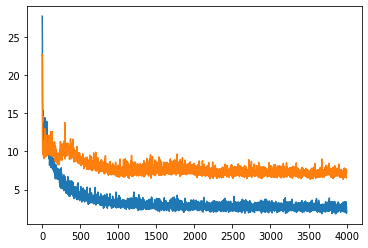

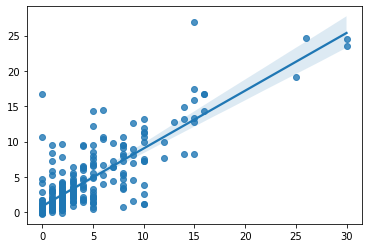

In [14]:
test(model_4, EPOCHS, "flatten_3")

In [15]:
model_5 = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=INPUT_LENGTH),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='linear')
])
print(model_5.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 20, 32)            3168      
                                                                 
 lstm_3 (LSTM)               (None, 20, 32)            8320      
                                                                 
 lstm_4 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 flatten_4 (Flatten)         (None, 16)                0         
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [ ]:
test(model_5, EPOCHS, "flatten_4")

In [ ]:
model_6 = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=INPUT_LENGTH),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='linear')
])
print(model_6.summary())

In [ ]:
test(model_6, EPOCHS, "")

In [ ]:
model_7 = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=INPUT_LENGTH),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='linear')
])
print(model_7.summary())

In [ ]:
test(model_7, EPOCHS, "")